In [1]:
# === Adım 1: Kurulum, Ana Veri Yükleme ve Temel GTFS Hazırlığı ===

# --- 1. Gerekli Kütüphanelerin Import Edilmesi ---
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt # EDA için ileride kullanılacak
import seaborn as sns # EDA için ileride kullanılacak
import logging
import sys
import requests # API istekleri için
# import zipfile # Bu projede zip dosyasıyla doğrudan çalışmıyoruz
# import glob # Bu projede dosya deseniyle doğrudan çalışmıyoruz
# import json # API yanıtları için gerekebilir ama şimdilik doğrudan kullanılmıyor

# --- 2. Logging Kurulumu ---
logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
if not logger.handlers:
    logger.setLevel(logging.INFO)
    ch = logging.StreamHandler(sys.stdout) # Colab'da çıktıyı görmek için stdout
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    logger.info("Logger 'IBB_TopluTasima_Projesi_Yeni_Oturum' başarıyla ayarlandı.")
else:
    logger.info("Logger 'IBB_TopluTasima_Projesi_Yeni_Oturum' zaten ayarlanmış.")

logger.info("===== YENİ OTURUM - ADIM 1 BAŞLATILIYOR: Kurulum, Ana Veri Yükleme, Temel GTFS Hazırlığı =====")

# --- 3. Google Drive Bağlantısı ---
drive_mounted = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_mounted = True
    logger.info("Google Drive başarıyla bağlandı.")
except Exception as e:
    logger.error(f"Google Drive bağlantısı sırasında hata oluştu: {e}")
    logger.error("Lütfen Drive bağlantı iznini verdiğinizden emin olun.")
    logger.warning("Google Drive bağlanamadı. Veriler Colab geçici depolama alanına indirilecek ve oturum sonunda kaybolabilir.")

# --- 4. Mart 2021 Saatlik Kullanım Verisini API'den İndirme/Yükleme ---
CKAN_API_BASE_URL = "https://data.ibb.gov.tr/api/3/action/"
HOURLY_DATA_PACKAGE_ID = "a6855ce7-4092-40a5-82b5-34cf3c7e36e3" # Mart Ayı Toplu Ulaşım Verisi Paket ID'si
HOURLY_DATA_RESOURCE_ID = "ef77dde9-9e0c-4417-a939-3ca4013ef919" # hourly_transportation_202103.csv Kaynak ID'si
hourly_data_filename_original = "hourly_transportation_202103.csv"

# Google Drive'da dosyanın kaydedileceği/okunacağı hedef yol
# LÜTFEN BU YOLU KENDİ DRIVE YAPINIZA GÖRE GÜNCELLEYİN!
# Önceki mesajınızda "/content/drive/MyDrive/Colab Notebooks/Veri Bilimi Projesi/ibb_mart2021_verisi.csv" idi,
# ama İBB'den inen orijinal dosya adı farklı. İBB adını kullanalım ve klasörü belirtelim.
DRIVE_PROJECT_FOLDER = "/content/drive/MyDrive/Colab Notebooks/Veri Bilimi Projesi/" # Klasör yolu
drive_hourly_data_path_target = os.path.join(DRIVE_PROJECT_FOLDER, hourly_data_filename_original)
colab_temp_hourly_data_path = f"/content/{hourly_data_filename_original}" # Colab geçici yolu

df_mart = None

def get_specific_resource_url(package_id, resource_id_to_find):
    action = "package_show"
    params = {"id": package_id}
    logger.info(f"'{package_id}' paketinden '{resource_id_to_find}' kaynak ID'li dosyanın URL'si aranıyor...")
    try:
        response = requests.get(CKAN_API_BASE_URL + action, params=params)
        response.raise_for_status()
        dataset_info = response.json()
        if dataset_info.get("success"):
            resources = dataset_info.get("result", {}).get("resources", [])
            for resource in resources:
                if resource.get('id') == resource_id_to_find:
                    res_url = resource.get('url')
                    res_name = resource.get('name', 'isimsiz_kaynak')
                    logger.info(f"Kaynak bulundu: Ad='{res_name}', URL='{res_url}'")
                    return res_url, res_name
            logger.warning(f"'{package_id}' paketinde '{resource_id_to_find}' ID'li kaynak bulunamadı.")
            return None, None
        else:
            logger.error(f"'{package_id}' paketi için API'den bilgi alınamadı: {dataset_info.get('error')}")
            return None, None
    except requests.exceptions.RequestException as e_req:
        logger.error(f"'{package_id}' paketi için API isteği sırasında hata: {e_req}")
        return None, None

# Veri Yükleme/İndirme Mantığı
hourly_data_loaded_from_drive = False
if drive_mounted and os.path.exists(drive_hourly_data_path_target):
    logger.info(f"'{hourly_data_filename_original}' dosyası Google Drive'da ({drive_hourly_data_path_target}) bulunuyor. Oradan yüklenecek.")
    try:
        df_mart = pd.read_csv(drive_hourly_data_path_target)
        hourly_data_loaded_from_drive = True
        logger.info(f"'{hourly_data_filename_original}' başarıyla Google Drive'dan DataFrame'e yüklendi.")
    except Exception as e_drive_load:
        logger.error(f"Google Drive'daki '{drive_hourly_data_path_target}' dosyasından df_mart yüklenirken hata: {e_drive_load}")
        logger.info("Dosya API'den indirilmeye çalışılacak.")

if not hourly_data_loaded_from_drive:
    if os.path.exists(colab_temp_hourly_data_path):
        logger.info(f"'{hourly_data_filename_original}' dosyası Colab geçici alanında ({colab_temp_hourly_data_path}) bulunuyor. Oradan yüklenecek.")
        try:
            df_mart = pd.read_csv(colab_temp_hourly_data_path)
            logger.info(f"'{hourly_data_filename_original}' başarıyla Colab geçici alanından DataFrame'e yüklendi.")
        except Exception as e_colab_load:
            logger.error(f"Colab geçici alanındaki '{colab_temp_hourly_data_path}' dosyasından df_mart yüklenirken hata: {e_colab_load}")
            logger.info("Dosya API'den yeniden indirilmeye çalışılacak.")
            if os.path.exists(colab_temp_hourly_data_path): # Hatalı dosyayı sil
                 os.remove(colab_temp_hourly_data_path)

    if df_mart is None: # Ne Drive'dan ne de Colab'dan yüklenemediyse API'den indir
        logger.info(f"'{hourly_data_filename_original}' dosyası yerel olarak bulunamadı. API'den indirilecek.")
        hourly_data_url, _ = get_specific_resource_url(HOURLY_DATA_PACKAGE_ID, HOURLY_DATA_RESOURCE_ID)
        if hourly_data_url:
            logger.info(f"'{hourly_data_filename_original}' dosyası indiriliyor (URL: {hourly_data_url})... Bu işlem zaman alabilir.")
            try:
                with requests.get(hourly_data_url, stream=True) as r:
                    r.raise_for_status()
                    with open(colab_temp_hourly_data_path, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=8192*16): # Daha büyük chunk
                            f.write(chunk)
                logger.info(f"'{hourly_data_filename_original}' başarıyla Colab geçici alanına indirildi: {colab_temp_hourly_data_path}")
                df_mart = pd.read_csv(colab_temp_hourly_data_path)
                logger.info(f"'{hourly_data_filename_original}' başarıyla Colab geçici alanından DataFrame'e yüklendi.")

                if drive_mounted: # Drive bağlıysa oraya da kopyala
                    logger.info(f"Dosya Google Drive'a kopyalanıyor: {drive_hourly_data_path_target}")
                    if not os.path.exists(DRIVE_PROJECT_FOLDER):
                        os.makedirs(DRIVE_PROJECT_FOLDER)
                        logger.info(f"Google Drive'da hedef klasör oluşturuldu: {DRIVE_PROJECT_FOLDER}")
                    shutil.copy(colab_temp_hourly_data_path, drive_hourly_data_path_target)
                    logger.info(f"Dosya başarıyla Google Drive'a kopyalandı: {drive_hourly_data_path_target}")
            except Exception as e_download_load:
                logger.error(f"'{hourly_data_filename_original}' indirme/yükleme sırasında hata: {e_download_load}")
        else:
            logger.error(f"Mart 2021 saatlik kullanım verisi için indirme URL'si API'den alınamadı.")

# df_mart yüklendiyse temel bilgileri ve ön işlemeleri yap
if df_mart is not None:
    logger.info(f"Mart 2021 kullanım verisi (df_mart) başarıyla yüklendi: {df_mart.shape[0]:,} satır, {df_mart.shape[1]} sütun.")
    logger.info("İlk 3 satır (df_mart.head(3)):")
    print(df_mart.head(3))
    # logger.info("Genel bilgiler (df_mart.info()):") # Çok uzun olabilir, şimdilik kapalı
    # df_mart.info(verbose=True, show_counts=True)

    logger.info("--- df_mart için Temel Ön İşlemeler ---")
    # Tarih formatını datetime'a çevir
    if 'transition_date' in df_mart.columns:
        df_mart['transition_date'] = pd.to_datetime(df_mart['transition_date'])
        logger.info("'transition_date' sütunu datetime formatına çevrildi.")
    else:
        logger.warning("'transition_date' sütunu df_mart'ta bulunamadı!")

    # line_name sütununu büyük harfe çevir ve boşlukları temizle (eşleştirmeler için önemli)
    if 'line_name' in df_mart.columns:
        df_mart['line_name'] = df_mart['line_name'].astype(str).str.upper().str.strip()
        logger.info("'line_name' sütunu büyük harfe çevrildi ve boşlukları temizlendi.")
    else:
        logger.warning("'line_name' sütunu df_mart'ta bulunamadı!")

    # Eksik 'product_kind' ve 'town' verilerini "Bilinmiyor" ile doldur (önceki çalışmadaki gibi)
    if 'product_kind' in df_mart.columns:
        df_mart['product_kind'].fillna('Bilinmiyor', inplace=True)
        logger.info("Eksik 'product_kind' değerleri 'Bilinmiyor' ile dolduruldu.")
    if 'town' in df_mart.columns:
        df_mart['town'].fillna('Bilinmiyor', inplace=True)
        logger.info("Eksik 'town' değerleri 'Bilinmiyor' ile dolduruldu.")
    logger.info("--- df_mart Temel Ön İşlemeleri Tamamlandı ---\n")
else:
    logger.error("KRİTİK HATA: df_mart DataFrame'i yüklenemedi. Sonraki adımlar çalışmayabilir.")


# --- 5. Temel GTFS Dosyalarını İndirme ve Hazırlama ---
logger.info("--- Temel GTFS Dosyaları İndiriliyor/Yükleniyor ---")

# Kapsamlı GTFS (ID: 121a9892-7945-419a-9b89-49f6083926df) kaynakları
COMP_GTFS_PACKAGE_ID = "121a9892-7945-419a-9b89-49f6083926df"
comp_gtfs_resources_info = {
    "agency": {"id": "42ae499d-ae9c-4906-ac5c-96e0c155e00b", "filename": "comp_agency.csv", "encoding": "iso-8859-9", "make_upper_short": False, "make_upper_long": False},
    "routes": {"id": "36b554c7-cae0-4b7e-978f-fc6a43664e88", "filename": "comp_routes.csv", "encoding": "iso-8859-9", "make_upper_short": True, "make_upper_long": True}
    # Diğer dosyalar (stops, trips, calendar) eşleştirme için şu an doğrudan gerekmiyor, ihtiyaç olursa eklenebilir.
}

# İETT GTFS (ID: 8540e256-6df5-4719-85bc-e64e91508ede) kaynakları
IETT_GTFS_PACKAGE_ID = "8540e256-6df5-4719-85bc-e64e91508ede"
iett_gtfs_resources_info = {
    "routes": {"id": "46dbe388-c8c2-45c4-ac72-c06953de56a2", "filename": "iett_routes.csv", "encoding": "utf-8", "make_upper_short": True, "make_upper_long": True}
}

gtfs_dataframes = {} # İndirilen GTFS DataFrame'lerini saklamak için

def download_and_load_gtfs_file(package_id, resource_meta, target_folder="/content/"):
    resource_id = resource_meta["id"]
    filename = resource_meta["filename"]
    encoding = resource_meta["encoding"]
    make_upper_short = resource_meta.get("make_upper_short", False) # route_short_name için
    make_upper_long = resource_meta.get("make_upper_long", False) # route_long_name için

    local_file_path = os.path.join(target_folder, filename)
    df = None

    # Önce Colab geçici alanında var mı diye kontrol et
    if os.path.exists(local_file_path):
        logger.info(f"'{filename}' dosyası Colab geçici alanında ({local_file_path}) zaten mevcut. Oradan yüklenecek.")
        try:
            df = pd.read_csv(local_file_path, encoding=encoding, low_memory=False)
        except Exception as e_load_local:
            logger.warning(f"Colab'daki '{filename}' yüklenirken hata: {e_load_local}. API'den yeniden indirilecek.")
            if os.path.exists(local_file_path): os.remove(local_file_path) # Hatalıysa sil

    if df is None: # Eğer yüklenemediyse veya yoksa API'den indir
        resource_url, _ = get_specific_resource_url(package_id, resource_id)
        if resource_url:
            logger.info(f"'{filename}' GTFS dosyası indiriliyor...")
            try:
                response = requests.get(resource_url)
                response.raise_for_status()
                with open(local_file_path, 'wb') as f:
                    f.write(response.content)
                df = pd.read_csv(local_file_path, encoding=encoding, low_memory=False)
                logger.info(f"'{filename}' başarıyla indirilip DataFrame'e yüklendi.")
            except Exception as e_download_gtfs:
                logger.error(f"'{filename}' GTFS indirilirken/yüklenirken hata: {e_download_gtfs}")
                return None # Hata durumunda None döndür
        else:
            logger.error(f"'{filename}' için (Kaynak ID: {resource_id}) indirme URL'si alınamadı.")
            return None

    # Yüklendikten sonra gerekli sütunları büyük harfe çevir ve boşlukları temizle
    if df is not None:
        if make_upper_short and 'route_short_name' in df.columns:
            df['route_short_name'] = df['route_short_name'].astype(str).str.upper().str.strip()
        if make_upper_long and 'route_long_name' in df.columns:
            df['route_long_name'] = df['route_long_name'].astype(str).str.upper().str.strip()
    return df

# Kapsamlı GTFS dosyalarını indir/yükle
df_comp_agency = download_and_load_gtfs_file(COMP_GTFS_PACKAGE_ID, comp_gtfs_resources_info["agency"])
df_comp_routes = download_and_load_gtfs_file(COMP_GTFS_PACKAGE_ID, comp_gtfs_resources_info["routes"])

df_routes_comp_enriched = None
if df_comp_routes is not None and df_comp_agency is not None:
    # Kapsamlı GTFS rotalarına ajans isimlerini ekle
    df_routes_comp_enriched = pd.merge(df_comp_routes, df_comp_agency[['agency_id', 'agency_name']], on='agency_id', how='left')
    logger.info("Kapsamlı GTFS Rotaları (df_routes_comp_enriched) ajans isimleriyle zenginleştirildi.")
    logger.info("İlk 3 satır (df_routes_comp_enriched.head(3)):")
    print(df_routes_comp_enriched.head(3))
else:
    logger.error("Kapsamlı GTFS agency veya routes dosyaları yüklenemediği için birleştirme yapılamadı.")

# İETT GTFS dosyalarını indir/yükle
df_routes_iett = download_and_load_gtfs_file(IETT_GTFS_PACKAGE_ID, iett_gtfs_resources_info["routes"])
if df_routes_iett is not None:
    df_routes_iett['agency_name'] = 'İETT' # Manuel olarak ajans ismi ata
    logger.info("İETT GTFS Rotaları (df_routes_iett) yüklendi ve ajans ismi eklendi.")
    logger.info("İlk 3 satır (df_routes_iett.head(3)):")
    print(df_routes_iett.head(3))
else:
    logger.error("İETT GTFS routes dosyası yüklenemedi.")

logger.info("\n===== ADIM 1 TAMAMLANDI: Ana Veri ve Temel GTFS Dosyaları Hazır. =====")
logger.info("Bir sonraki adım, df_mart ile bu GTFS verilerini birleştirmek (Hibrit GTFS Eşleştirme) olacak.")
logger.info("Lütfen bu hücrenin tüm çıktılarını kontrol edin ve bir sorun yoksa onay verin.")

2025-05-21 19:01:36 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Logger 'IBB_TopluTasima_Projesi_Yeni_Oturum' başarıyla ayarlandı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Logger 'IBB_TopluTasima_Projesi_Yeni_Oturum' başarıyla ayarlandı.


2025-05-21 19:01:36 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== YENİ OTURUM - ADIM 1 BAŞLATILIYOR: Kurulum, Ana Veri Yükleme, Temel GTFS Hazırlığı =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== YENİ OTURUM - ADIM 1 BAŞLATILIYOR: Kurulum, Ana Veri Yükleme, Temel GTFS Hazırlığı =====


Mounted at /content/drive
2025-05-21 19:01:58 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Google Drive başarıyla bağlandı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Google Drive başarıyla bağlandı.


2025-05-21 19:01:59 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'hourly_transportation_202103.csv' dosyası Google Drive'da (/content/drive/MyDrive/Colab Notebooks/Veri Bilimi Projesi/hourly_transportation_202103.csv) bulunuyor. Oradan yüklenecek.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'hourly_transportation_202103.csv' dosyası Google Drive'da (/content/drive/MyDrive/Colab Notebooks/Veri Bilimi Projesi/hourly_transportation_202103.csv) bulunuyor. Oradan yüklenecek.


2025-05-21 19:02:13 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'hourly_transportation_202103.csv' başarıyla Google Drive'dan DataFrame'e yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'hourly_transportation_202103.csv' başarıyla Google Drive'dan DataFrame'e yüklendi.


2025-05-21 19:02:13 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Mart 2021 kullanım verisi (df_mart) başarıyla yüklendi: 9,547,171 satır, 13 sütun.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Mart 2021 kullanım verisi (df_mart) başarıyla yüklendi: 9,547,171 satır, 13 sütun.


2025-05-21 19:02:13 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İlk 3 satır (df_mart.head(3)):


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İlk 3 satır (df_mart.head(3)):


  transition_date  transition_hour  transport_type_id road_type  \
0      2021-03-01                0                  1    OTOYOL   
1      2021-03-01                0                  2     RAYLI   
2      2021-03-01                0                  2     RAYLI   

                   line transfer_type  number_of_passage  number_of_passenger  \
0  AVCILAR-ZINCIRLIKUYU        Normal                  1                    1   
1  YENIKAPI - HACIOSMAN        Normal                  3                    3   
2      TOPKAPI-HABIBLER        Normal                  1                    1   

  product_kind transaction_type_desc          town line_name  \
0     UCRETSIZ              Ucretsiz  KUCUKCEKMECE        34   
1          TAM            Tam Kontur       BEYOGLU        M2   
2          TAM            Tam Kontur    EYUPSULTAN        T4   

  station_poi_desc_cd  
0        KUCUKCEKMECE  
1        TAKSIM GUNEY  
2            SEHITLIK  
2025-05-21 19:02:13 - IBB_TopluTasima_Projesi_Yeni_Ot

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- df_mart için Temel Ön İşlemeler ---


2025-05-21 19:02:13 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'transition_date' sütunu datetime formatına çevrildi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'transition_date' sütunu datetime formatına çevrildi.


2025-05-21 19:02:15 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'line_name' sütunu büyük harfe çevrildi ve boşlukları temizlendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'line_name' sütunu büyük harfe çevrildi ve boşlukları temizlendi.
<ipython-input-1-fbb929bd8676>:160: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mart['product_kind'].fillna('Bilinmiyor', inplace=True)


2025-05-21 19:02:16 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Eksik 'product_kind' değerleri 'Bilinmiyor' ile dolduruldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Eksik 'product_kind' değerleri 'Bilinmiyor' ile dolduruldu.
<ipython-input-1-fbb929bd8676>:163: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mart['town'].fillna('Bilinmiyor', inplace=True)


2025-05-21 19:02:16 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Eksik 'town' değerleri 'Bilinmiyor' ile dolduruldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Eksik 'town' değerleri 'Bilinmiyor' ile dolduruldu.


2025-05-21 19:02:16 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- df_mart Temel Ön İşlemeleri Tamamlandı ---



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- df_mart Temel Ön İşlemeleri Tamamlandı ---



2025-05-21 19:02:16 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- Temel GTFS Dosyaları İndiriliyor/Yükleniyor ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- Temel GTFS Dosyaları İndiriliyor/Yükleniyor ---


2025-05-21 19:02:16 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - '121a9892-7945-419a-9b89-49f6083926df' paketinden '42ae499d-ae9c-4906-ac5c-96e0c155e00b' kaynak ID'li dosyanın URL'si aranıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'121a9892-7945-419a-9b89-49f6083926df' paketinden '42ae499d-ae9c-4906-ac5c-96e0c155e00b' kaynak ID'li dosyanın URL'si aranıyor...


2025-05-21 19:02:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kaynak bulundu: Ad='agency', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/42ae499d-ae9c-4906-ac5c-96e0c155e00b/download/agency.csv'


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kaynak bulundu: Ad='agency', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/42ae499d-ae9c-4906-ac5c-96e0c155e00b/download/agency.csv'


2025-05-21 19:02:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_agency.csv' GTFS dosyası indiriliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_agency.csv' GTFS dosyası indiriliyor...


2025-05-21 19:02:19 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_agency.csv' başarıyla indirilip DataFrame'e yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_agency.csv' başarıyla indirilip DataFrame'e yüklendi.


2025-05-21 19:02:19 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - '121a9892-7945-419a-9b89-49f6083926df' paketinden '36b554c7-cae0-4b7e-978f-fc6a43664e88' kaynak ID'li dosyanın URL'si aranıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'121a9892-7945-419a-9b89-49f6083926df' paketinden '36b554c7-cae0-4b7e-978f-fc6a43664e88' kaynak ID'li dosyanın URL'si aranıyor...


2025-05-21 19:02:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kaynak bulundu: Ad='routes', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/36b554c7-cae0-4b7e-978f-fc6a43664e88/download/routes.csv'


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kaynak bulundu: Ad='routes', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/36b554c7-cae0-4b7e-978f-fc6a43664e88/download/routes.csv'


2025-05-21 19:02:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_routes.csv' GTFS dosyası indiriliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_routes.csv' GTFS dosyası indiriliyor...


2025-05-21 19:02:21 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_routes.csv' başarıyla indirilip DataFrame'e yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_routes.csv' başarıyla indirilip DataFrame'e yüklendi.


2025-05-21 19:02:21 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kapsamlı GTFS Rotaları (df_routes_comp_enriched) ajans isimleriyle zenginleştirildi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kapsamlı GTFS Rotaları (df_routes_comp_enriched) ajans isimleriyle zenginleştirildi.


2025-05-21 19:02:21 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İlk 3 satır (df_routes_comp_enriched.head(3)):


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İlk 3 satır (df_routes_comp_enriched.head(3)):


  route_id  agency_id route_short_name  \
0    28195        6.0          BSK-HLC   
1    28194        6.0          KDK-HLC   
2    28191        6.0         ASYN-KCS   

                                     route_long_name  route_desc  route_type  \
0  BEŞİKTAŞ - KABATAŞ - KARAKÖY - KASIMPAŞA - SÜT...         NaN         4.0   
1       KADIKÖY - KASIMPAŞA - FENER - SÜTLÜCE - EYÜP         NaN         4.0   
2             AŞIYAN - ANADOLU HISARI - KÜÇÜKSU RING         NaN         4.0   

                                           route_url  route_color  \
0                                                NaN          NaN   
1                                                NaN          NaN   
2  https://www.sehirhatlari.istanbul/tr/seferler/...          NaN   

   route_text_color        agency_name  
0               NaN  Şehirhatları A.Ş.  
1               NaN  Şehirhatları A.Ş.  
2               NaN  Şehirhatları A.Ş.  
2025-05-21 19:02:21 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - '8

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'8540e256-6df5-4719-85bc-e64e91508ede' paketinden '46dbe388-c8c2-45c4-ac72-c06953de56a2' kaynak ID'li dosyanın URL'si aranıyor...


2025-05-21 19:02:22 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kaynak bulundu: Ad='routes', URL='https://data.ibb.gov.tr/dataset/8540e256-6df5-4719-85bc-e64e91508ede/resource/46dbe388-c8c2-45c4-ac72-c06953de56a2/download/routes.csv'


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kaynak bulundu: Ad='routes', URL='https://data.ibb.gov.tr/dataset/8540e256-6df5-4719-85bc-e64e91508ede/resource/46dbe388-c8c2-45c4-ac72-c06953de56a2/download/routes.csv'


2025-05-21 19:02:22 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'iett_routes.csv' GTFS dosyası indiriliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'iett_routes.csv' GTFS dosyası indiriliyor...


2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'iett_routes.csv' başarıyla indirilip DataFrame'e yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'iett_routes.csv' başarıyla indirilip DataFrame'e yüklendi.


2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İETT GTFS Rotaları (df_routes_iett) yüklendi ve ajans ismi eklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İETT GTFS Rotaları (df_routes_iett) yüklendi ve ajans ismi eklendi.


2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İlk 3 satır (df_routes_iett.head(3)):


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İlk 3 satır (df_routes_iett.head(3)):


  route_id  agency_id route_short_name        route_long_name  route_type  \
0        1        1.0                1  KADIKÖY - KİRAZLITEPE         3.0   
1        2        1.0                1  KADIKÖY - KİRAZLITEPE         3.0   
2        3        1.0                1  KİRAZLITEPE - KADIKÖY         3.0   

                         route_desc route_code agency_name  
0                               NaN     1_D_D0        İETT  
1  SAATLER FERAH CADDESİNDEN GİDER.  1_D_D2784        İETT  
2                               NaN     1_G_D0        İETT  
2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
===== ADIM 1 TAMAMLANDI: Ana Veri ve Temel GTFS Dosyaları Hazır. =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
===== ADIM 1 TAMAMLANDI: Ana Veri ve Temel GTFS Dosyaları Hazır. =====


2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Bir sonraki adım, df_mart ile bu GTFS verilerini birleştirmek (Hibrit GTFS Eşleştirme) olacak.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Bir sonraki adım, df_mart ile bu GTFS verilerini birleştirmek (Hibrit GTFS Eşleştirme) olacak.


2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Lütfen bu hücrenin tüm çıktılarını kontrol edin ve bir sorun yoksa onay verin.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Lütfen bu hücrenin tüm çıktılarını kontrol edin ve bir sorun yoksa onay verin.


In [2]:
# === Hücre 2.0: Hazırlık ve Gerekli Kontroller (Adım 2 Bölümü) ===

import pandas as pd
import numpy as np # pd.NA için pd.NA kullanacağız ama numpy da bulunsun.
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum') # Adım 1'deki logger'ı kullanıyoruz
logger.info("===== HÜCRE 2.0 BAŞLATILIYOR: Hazırlık ve Gerekli Kontroller =====")

# Adım 1'den gelmesi beklenen DataFrame'lerin varlığını kontrol et
error_found_in_prerequisites = False
if 'df_mart' not in locals() or df_mart is None or df_mart.empty:
    logger.error("HATA: 'df_mart' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i başarıyla çalıştırın.")
    error_found_in_prerequisites = True

if 'df_routes_comp_enriched' not in locals() or df_routes_comp_enriched is None:
    logger.error("HATA: 'df_routes_comp_enriched' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i başarıyla çalıştırın.")
    error_found_in_prerequisites = True

if 'df_routes_iett' not in locals() or df_routes_iett is None:
    logger.error("HATA: 'df_routes_iett' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i başarıyla çalıştırın.")
    error_found_in_prerequisites = True

if not error_found_in_prerequisites:
    logger.info("Gerekli DataFrame'ler ('df_mart', 'df_routes_comp_enriched', 'df_routes_iett') başarıyla bulundu.")

    # df_hourly_mart2021'i oluşturalım (Adım 2 boyunca bu DataFrame güncellenecek)
    if 'df_hourly_mart2021' in locals():
        logger.warning("'df_hourly_mart2021' zaten mevcut. Üzerine yazılıyor (Adım 1'den df_mart kopyalanarak).")
    df_hourly_mart2021 = df_mart.copy()
    logger.info("'df_hourly_mart2021' DataFrame'i 'df_mart' kopyalanarak oluşturuldu/üzerine yazıldı.")

    # GTFS bilgilerini eklemek için hedef sütunları oluştur/sıfırla
    gtfs_cols_to_add = ['gtfs_route_id', 'gtfs_route_short_name', 'gtfs_route_long_name',
                        'gtfs_route_type', 'gtfs_agency_name', 'match_source']
    for col in gtfs_cols_to_add:
        df_hourly_mart2021[col] = pd.NA # pd.NA kullanmak daha modern ve tutarlı

    logger.info(f"GTFS eşleştirme için hedef sütunlar ({gtfs_cols_to_add}) df_hourly_mart2021'e eklendi ve pd.NA ile dolduruldu.")
    print(f"df_hourly_mart2021 başlangıç boyutu: {df_hourly_mart2021.shape}")
    print(f"df_hourly_mart2021 ilk 2 satırı (GTFS sütunları ile):")
    print(df_hourly_mart2021.head(2))

    # GTFS route_type tanımlamaları
    # Bu sözlük sonraki hücrelerde (özellikle Hücre 2.4'te) kullanılacak.
    global gtfs_route_type_definitions_map # Diğer hücrelerden erişim için global yapalım
    gtfs_route_type_definitions_map = {
        0.0: "0_Tramvay/LR", 1.0: "1_Metro/Marmaray", 2.0: "2_Tren", 3.0: "3_Otobus/Metrobus",
        4.0: "4_Vapur", 5.0: "5_KabloluTramvay", 6.0: "6_HavaiTramvay", 7.0: "7_Funikuler",
        # Diğer potansiyel GTFS route_type'ları (9.0 Minibüs, 10.0 Diğer Raylı vb.)
        # eşleşme sırasında doğrudan gtfs_route_type olarak atanacak,
        # final_route_type_desc oluşturulurken bu map'te yoksa 'Diger/Bilinmiyor' olacak.
    }
    logger.info("'gtfs_route_type_definitions_map' tanımlandı.")
    logger.info("===== HÜCRE 2.0 TAMAMLANDI: Hazırlıklar yapıldı. =====")
else:
    logger.error("Önkoşul DataFrame'ler eksik olduğu için Hücre 2.0 tamamlanamadı. Lütfen Adım 1'i kontrol edin.")

2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.0 BAŞLATILIYOR: Hazırlık ve Gerekli Kontroller =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.0 BAŞLATILIYOR: Hazırlık ve Gerekli Kontroller =====


2025-05-21 19:02:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Gerekli DataFrame'ler ('df_mart', 'df_routes_comp_enriched', 'df_routes_iett') başarıyla bulundu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Gerekli DataFrame'ler ('df_mart', 'df_routes_comp_enriched', 'df_routes_iett') başarıyla bulundu.


2025-05-21 19:02:26 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_hourly_mart2021' DataFrame'i 'df_mart' kopyalanarak oluşturuldu/üzerine yazıldı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_hourly_mart2021' DataFrame'i 'df_mart' kopyalanarak oluşturuldu/üzerine yazıldı.


2025-05-21 19:02:27 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - GTFS eşleştirme için hedef sütunlar (['gtfs_route_id', 'gtfs_route_short_name', 'gtfs_route_long_name', 'gtfs_route_type', 'gtfs_agency_name', 'match_source']) df_hourly_mart2021'e eklendi ve pd.NA ile dolduruldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:GTFS eşleştirme için hedef sütunlar (['gtfs_route_id', 'gtfs_route_short_name', 'gtfs_route_long_name', 'gtfs_route_type', 'gtfs_agency_name', 'match_source']) df_hourly_mart2021'e eklendi ve pd.NA ile dolduruldu.


df_hourly_mart2021 başlangıç boyutu: (9547171, 19)
df_hourly_mart2021 ilk 2 satırı (GTFS sütunları ile):
  transition_date  transition_hour  transport_type_id road_type  \
0      2021-03-01                0                  1    OTOYOL   
1      2021-03-01                0                  2     RAYLI   

                   line transfer_type  number_of_passage  number_of_passenger  \
0  AVCILAR-ZINCIRLIKUYU        Normal                  1                    1   
1  YENIKAPI - HACIOSMAN        Normal                  3                    3   

  product_kind transaction_type_desc          town line_name  \
0     UCRETSIZ              Ucretsiz  KUCUKCEKMECE        34   
1          TAM            Tam Kontur       BEYOGLU        M2   

  station_poi_desc_cd gtfs_route_id gtfs_route_short_name  \
0        KUCUKCEKMECE          <NA>                  <NA>   
1        TAKSIM GUNEY          <NA>                  <NA>   

  gtfs_route_long_name gtfs_route_type gtfs_agency_name match_source  
0

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'gtfs_route_type_definitions_map' tanımlandı.


2025-05-21 19:02:27 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.0 TAMAMLANDI: Hazırlıklar yapıldı. =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.0 TAMAMLANDI: Hazırlıklar yapıldı. =====


In [3]:
# === Hücre 2.1: Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS ile) (Adım 2 Bölümü) ===

import pandas as pd # Zaten import edilmiş olmalı
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 2.1 BAŞLATILIYOR: Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS) =====")

# Gerekli DataFrame'lerin varlığını kontrol et
error_found_in_prerequisites_2_1 = False
if 'df_hourly_mart2021' not in locals() or df_hourly_mart2021 is None or df_hourly_mart2021.empty:
    logger.error("HATA: 'df_hourly_mart2021' DataFrame'i bellekte bulunamadı. Lütfen Hücre 2.0'ı çalıştırın.")
    error_found_in_prerequisites_2_1 = True

if 'df_routes_comp_enriched' not in locals() or df_routes_comp_enriched is None:
    logger.error("HATA: 'df_routes_comp_enriched' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i çalıştırın.")
    error_found_in_prerequisites_2_1 = True

if not error_found_in_prerequisites_2_1:
    logger.info("'df_hourly_mart2021' ve 'df_routes_comp_enriched' DataFrame'leri bulundu. Eşleştirmeye devam ediliyor...")

    # priority_map_comp_gtfs'i tanımla (Hücre 2.0'da tanımlanmamıştı, burada tanımlanmalı)
    # Not: agency_id'ler Kapsamlı GTFS'teki (comp_agency.csv) ID'lerdir.
    # Metro İstanbul: 11.0, TCDD: 4.0 (float olarak teyit edin)
    priority_map_comp_gtfs = {
        "M1": (11.0, ["M1", "M1A", "M1B"]), "M2": (11.0, ["M2"]), "M3": (11.0, ["M3"]),
        "M4": (11.0, ["M4"]), "M5": (11.0, ["M5"]), "M6": (11.0, ["M6"]), "M7": (11.0, ["M7"]),
        "M8": (11.0, ["M8"]), "M9": (11.0, ["M9"]), # M8, M9 Mart 2021'de var mıydı kontrol edilebilir, GTFS'te varsa eşleşir.
        "T1": (11.0, ["T1"]), "T3": (11.0, ["T3"]), "T4": (11.0, ["T4"]),
        "T5": (11.0, ["T5"]), # T5 için Kapsamlı GTFS'te eşleşme bulunamayabilir (uyarı logu beklenir)
        "F1": (11.0, ["F1"]), "F2": (11.0, ["F2"]), "F3": (11.0, ["F3"]),
        "F4": (11.0, ["F4"]), # F4 Mart 2021'de var mıydı kontrol edilebilir, GTFS'te varsa eşleşir.
        "TF1": (11.0, ["TF1"]), "TF2": (11.0, ["TF2"]),
        "NOSTRAM": (11.0, ["T3"]),
        "TUNEL": (11.0, ["F2"]),
        "MARMARAY": (4.0, ["MARMARAY", "HALKALI-GEBZE", "GEBZE-HALKALI"]), # Kapsamlı GTFS'teki Marmaray route_short_name'lerine göre güncelleyin
    }
    logger.info("'priority_map_comp_gtfs' tanımlandı.")

    matched_count_step1_total = 0 # Bu hücrede güncellenen toplam kayıt sayısı

    for hourly_ln_key, (agency_id_val, gtfs_short_names_list) in priority_map_comp_gtfs.items():
        # df_hourly_mart2021'deki line_name'ler büyük harf ve temizlenmişti.
        mask_hourly = (df_hourly_mart2021['line_name'] == hourly_ln_key) & (df_hourly_mart2021['match_source'].isna())

        if mask_hourly.any():
            gtfs_match_candidates = df_routes_comp_enriched[
                (df_routes_comp_enriched['agency_id'] == agency_id_val) &
                (df_routes_comp_enriched['route_short_name'].isin(gtfs_short_names_list))
            ]

            if not gtfs_match_candidates.empty:
                # Öncelik, df_hourly_mart2021['line_name'] ile GTFS['route_short_name']'in doğrudan eşleşmesi
                gtfs_route_info = gtfs_match_candidates[gtfs_match_candidates['route_short_name'] == hourly_ln_key].head(1)
                if gtfs_route_info.empty: # Doğrudan eşleşme yoksa listedeki ilkini al (örn: M1 -> M1A/M1B durumu)
                     gtfs_route_info = gtfs_match_candidates.drop_duplicates(subset=['route_short_name'], keep='first').head(1)

                if not gtfs_route_info.empty:
                    idx_to_update = df_hourly_mart2021[mask_hourly].index

                    df_hourly_mart2021.loc[idx_to_update, 'gtfs_route_id'] = gtfs_route_info['route_id'].iloc[0]
                    df_hourly_mart2021.loc[idx_to_update, 'gtfs_route_short_name'] = gtfs_route_info['route_short_name'].iloc[0]
                    df_hourly_mart2021.loc[idx_to_update, 'gtfs_route_long_name'] = gtfs_route_info['route_long_name'].iloc[0]
                    df_hourly_mart2021.loc[idx_to_update, 'gtfs_route_type'] = gtfs_route_info['route_type'].iloc[0]
                    df_hourly_mart2021.loc[idx_to_update, 'gtfs_agency_name'] = gtfs_route_info['agency_name'].iloc[0]
                    df_hourly_mart2021.loc[idx_to_update, 'match_source'] = 'Priority_Comp_GTFS'

                    count_updated_this_key = len(idx_to_update)
                    matched_count_step1_total += count_updated_this_key
                    logger.info(f"'{hourly_ln_key}' -> Kapsamlı GTFS '{gtfs_route_info['route_short_name'].iloc[0]}' ({gtfs_route_info['agency_name'].iloc[0]}) ile eşleştirildi ({count_updated_this_key} kayıt).")
                else:
                    logger.warning(f"'{hourly_ln_key}' (Agency ID: {agency_id_val}) için Kapsamlı GTFS'te ({gtfs_short_names_list}) uygun aday bulunamadı.")
            else:
                # Bu uyarı, Kapsamlı GTFS'te ilgili agency_id veya short_name listesinde hiç kayıt olmadığını gösterir.
                logger.warning(f"'{hourly_ln_key}' (Agency ID: {agency_id_val}) için Kapsamlı GTFS'te ({gtfs_short_names_list}) HİÇ aday bulunamadı.")

    logger.info(f"--- Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS) Bu Hücrede Tamamlandı. Bu hücrede toplam {matched_count_step1_total} kayıt güncellendi. ---")
    logger.info(f"df_hourly_mart2021 güncel boyutu: {df_hourly_mart2021.shape}")
    logger.info(f"match_source sütunundaki mevcut değerlerin dağılımı:")
    print(df_hourly_mart2021['match_source'].value_counts(dropna=False).to_string())
    logger.info("===== HÜCRE 2.1 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame'ler eksik olduğu için Hücre 2.1 çalıştırılamadı.")

2025-05-21 19:02:27 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.1 BAŞLATILIYOR: Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS) =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.1 BAŞLATILIYOR: Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS) =====


2025-05-21 19:02:27 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_hourly_mart2021' ve 'df_routes_comp_enriched' DataFrame'leri bulundu. Eşleştirmeye devam ediliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_hourly_mart2021' ve 'df_routes_comp_enriched' DataFrame'leri bulundu. Eşleştirmeye devam ediliyor...


2025-05-21 19:02:27 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'priority_map_comp_gtfs' tanımlandı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'priority_map_comp_gtfs' tanımlandı.


2025-05-21 19:02:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M1' -> Kapsamlı GTFS 'M1B' (Metro İstanbul) ile eşleştirildi (284959 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M1' -> Kapsamlı GTFS 'M1B' (Metro İstanbul) ile eşleştirildi (284959 kayıt).


2025-05-21 19:02:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M2' -> Kapsamlı GTFS 'M2' (Metro İstanbul) ile eşleştirildi (306010 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M2' -> Kapsamlı GTFS 'M2' (Metro İstanbul) ile eşleştirildi (306010 kayıt).


2025-05-21 19:02:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M3' -> Kapsamlı GTFS 'M3' (Metro İstanbul) ile eşleştirildi (103815 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M3' -> Kapsamlı GTFS 'M3' (Metro İstanbul) ile eşleştirildi (103815 kayıt).


2025-05-21 19:02:30 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M4' -> Kapsamlı GTFS 'M4' (Metro İstanbul) ile eşleştirildi (269195 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M4' -> Kapsamlı GTFS 'M4' (Metro İstanbul) ile eşleştirildi (269195 kayıt).


2025-05-21 19:02:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M5' -> Kapsamlı GTFS 'M5' (Metro İstanbul) ile eşleştirildi (219614 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M5' -> Kapsamlı GTFS 'M5' (Metro İstanbul) ile eşleştirildi (219614 kayıt).


2025-05-21 19:02:32 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M6' -> Kapsamlı GTFS 'M6' (Metro İstanbul) ile eşleştirildi (22482 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M6' -> Kapsamlı GTFS 'M6' (Metro İstanbul) ile eşleştirildi (22482 kayıt).


2025-05-21 19:02:32 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'M7' -> Kapsamlı GTFS 'M7' (Metro İstanbul) ile eşleştirildi (234917 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'M7' -> Kapsamlı GTFS 'M7' (Metro İstanbul) ile eşleştirildi (234917 kayıt).


2025-05-21 19:02:35 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'T1' -> Kapsamlı GTFS 'T1' (Metro İstanbul) ile eşleştirildi (353976 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'T1' -> Kapsamlı GTFS 'T1' (Metro İstanbul) ile eşleştirildi (353976 kayıt).


2025-05-21 19:02:35 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'T3' -> Kapsamlı GTFS 'T3' (Metro İstanbul) ile eşleştirildi (6610 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'T3' -> Kapsamlı GTFS 'T3' (Metro İstanbul) ile eşleştirildi (6610 kayıt).


2025-05-21 19:02:36 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'T4' -> Kapsamlı GTFS 'T4' (Metro İstanbul) ile eşleştirildi (240991 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'T4' -> Kapsamlı GTFS 'T4' (Metro İstanbul) ile eşleştirildi (240991 kayıt).


2025-05-21 19:02:37 - IBB_TopluTasima_Projesi_Yeni_Oturum - WARNING - 'T5' (Agency ID: 11.0) için Kapsamlı GTFS'te (['T5']) HİÇ aday bulunamadı.


2025-05-21 19:02:37 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'F1' -> Kapsamlı GTFS 'F1' (Metro İstanbul) ile eşleştirildi (14297 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'F1' -> Kapsamlı GTFS 'F1' (Metro İstanbul) ile eşleştirildi (14297 kayıt).


2025-05-21 19:02:40 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'TF1' -> Kapsamlı GTFS 'TF1' (Metro İstanbul) ile eşleştirildi (2264 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'TF1' -> Kapsamlı GTFS 'TF1' (Metro İstanbul) ile eşleştirildi (2264 kayıt).


2025-05-21 19:02:40 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'TF2' -> Kapsamlı GTFS 'TF2' (Metro İstanbul) ile eşleştirildi (5966 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'TF2' -> Kapsamlı GTFS 'TF2' (Metro İstanbul) ile eşleştirildi (5966 kayıt).


2025-05-21 19:02:41 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'NOSTRAM' -> Kapsamlı GTFS 'T3' (Metro İstanbul) ile eşleştirildi (2786 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'NOSTRAM' -> Kapsamlı GTFS 'T3' (Metro İstanbul) ile eşleştirildi (2786 kayıt).


2025-05-21 19:02:42 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'TUNEL' -> Kapsamlı GTFS 'F2' (Metro İstanbul) ile eşleştirildi (15885 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'TUNEL' -> Kapsamlı GTFS 'F2' (Metro İstanbul) ile eşleştirildi (15885 kayıt).


2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'MARMARAY' -> Kapsamlı GTFS 'MARMARAY' (TCDD) ile eşleştirildi (410507 kayıt).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'MARMARAY' -> Kapsamlı GTFS 'MARMARAY' (TCDD) ile eşleştirildi (410507 kayıt).


2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS) Bu Hücrede Tamamlandı. Bu hücrede toplam 2494274 kayıt güncellendi. ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- Öncelikli Hedefli Eşleştirme (Kapsamlı GTFS) Bu Hücrede Tamamlandı. Bu hücrede toplam 2494274 kayıt güncellendi. ---


2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_hourly_mart2021 güncel boyutu: (9547171, 19)


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_hourly_mart2021 güncel boyutu: (9547171, 19)


2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - match_source sütunundaki mevcut değerlerin dağılımı:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:match_source sütunundaki mevcut değerlerin dağılımı:


match_source
<NA>                  7052897
Priority_Comp_GTFS    2494274
2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.1 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.1 TAMAMLANDI =====


In [4]:
# === Hücre 2.2: Vapur Hatları İçin Gelişmiş Eşleştirme (Kapsamlı GTFS ile) (Adım 2 Bölümü) ===

import pandas as pd # Zaten import edilmiş olmalı
import re # Metin normalleştirme için
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 2.2 BAŞLATILIYOR: Vapur Hatları İçin Gelişmiş Eşleştirme (Kapsamlı GTFS) =====")

# Gerekli DataFrame'lerin varlığını kontrol et
error_found_in_prerequisites_2_2 = False
if 'df_hourly_mart2021' not in locals() or df_hourly_mart2021 is None or df_hourly_mart2021.empty:
    logger.error("HATA: 'df_hourly_mart2021' DataFrame'i bellekte bulunamadı. Lütfen Hücre 2.0 ve 2.1'i çalıştırın.")
    error_found_in_prerequisites_2_2 = True

if 'df_routes_comp_enriched' not in locals() or df_routes_comp_enriched is None:
    logger.error("HATA: 'df_routes_comp_enriched' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i çalıştırın.")
    error_found_in_prerequisites_2_2 = True

if not error_found_in_prerequisites_2_2:
    logger.info("'df_hourly_mart2021' ve 'df_routes_comp_enriched' DataFrame'leri bulundu. Vapur eşleştirmesine devam ediliyor...")

    # df_hourly_mart2021'de 'road_type' Deniz olan ve henüz eşleşmemiş kayıtları bul
    # ('match_source' sütunu pd.NA olanlar)
    mask_deniz_unmatched = (df_hourly_mart2021['road_type'] == 'DENİZ') & (df_hourly_mart2021['match_source'].isna())
    indices_deniz_unmatched = df_hourly_mart2021[mask_deniz_unmatched].index

    matched_count_step2_total = 0 # Bu hücrede güncellenen toplam kayıt sayısı

    if not indices_deniz_unmatched.empty:
        logger.info(f"Eşleşmemiş {len(indices_deniz_unmatched)} DENİZ kaydı için vapur eşleştirmesi deneniyor... Bu işlem biraz zaman alabilir.")

        # Kapsamlı GTFS'teki vapur rotalarını filtrele (route_type == 4.0)
        # Ajans ID'leri: Şehir Hatları (6.0), İDO (20.0), Turyol (48.0), Dentur Avrasya (33.0)
        # Bu ID'ler comp_agency.csv'den teyit edilmişti.
        vapur_agency_ids = [6.0, 20.0, 33.0, 48.0] # float olarak kontrol et
        vapur_routes_gtfs_candidates = df_routes_comp_enriched[
            (df_routes_comp_enriched['agency_id'].isin(vapur_agency_ids)) &
            (df_routes_comp_enriched['route_type'] == 4.0) # GTFS'te vapur için route_type genellikle 4'tür.
        ].copy() # .copy() ile SettingWithCopyWarning'den kaçınalım

        if not vapur_routes_gtfs_candidates.empty:
            # Metin normalleştirme fonksiyonu
            def normalize_text_for_ferry(text):
                if pd.isna(text): return ""
                text_str = str(text).upper() # Önce büyük harf
                # Türkçe karakterleri İngilizce benzerlerine çevir
                replacements_turkish = {'İ': 'I', 'Ü': 'U', 'Ş': 'S', 'Ğ': 'G', 'Ö': 'O', 'Ç': 'C'}
                for old, new in replacements_turkish.items():
                    text_str = text_str.replace(old, new)
                # Özel karakterleri ve boşlukları kaldır
                text_str = re.sub(r'[\-\s\.]+', '', text_str) # Tire, boşluk, nokta kaldır
                text_str = re.sub(r'[^A-Z0-9]+', '', text_str) # Sadece harf ve rakam kalsın
                return text_str

            # GTFS vapur rotalarının isimlerini normalleştir (bir kere yapılır)
            vapur_routes_gtfs_candidates['norm_short_name'] = vapur_routes_gtfs_candidates['route_short_name'].apply(normalize_text_for_ferry)
            vapur_routes_gtfs_candidates['norm_long_name'] = vapur_routes_gtfs_candidates['route_long_name'].apply(normalize_text_for_ferry)
            logger.info(f"{len(vapur_routes_gtfs_candidates)} adet potansiyel GTFS vapur rotası normalleştirildi.")

            # Eşleşmemiş deniz kayıtları üzerinde döngü
            for idx_hourly in indices_deniz_unmatched:
                hourly_ln = df_hourly_mart2021.loc[idx_hourly, 'line_name'] # Bu zaten büyük harf ve Adım 1'de strip() yapılmıştı.
                hourly_ln_norm = normalize_text_for_ferry(hourly_ln)
                best_match_route = None

                # 1. Kriter: GTFS norm_short_name ile doğrudan eşleşme
                if hourly_ln_norm: # Boş değilse ara
                    possible_matches_short = vapur_routes_gtfs_candidates[vapur_routes_gtfs_candidates['norm_short_name'] == hourly_ln_norm]
                    if not possible_matches_short.empty:
                        best_match_route = possible_matches_short.iloc[0] # İlk eşleşeni al

                # 2. Kriter: Eğer short_name ile eşleşme yoksa, long_name içinde parçalı eşleşme
                if best_match_route is None and hourly_ln_norm:
                    # Saatlik verideki line_name'in parçalarını (örn: "KADIKOY", "EMINONU") GTFS long_name'de ara
                    # Parçaları ayırırken sadece anlamlı olabilecekleri al (çok kısa olanları atla)
                    # Örnek: "KADIKOY-EMINONU" -> ["KADIKOY", "EMINONU"]
                    # Örnek: "ADALAR" -> ["ADALAR"]
                    # normalize_text_for_ferry zaten tire ve boşlukları kaldırdığı için split anlamsız olabilir.
                    # Bunun yerine, hourly_ln_norm'un, gtfs_ln_norm içinde geçip geçmediğine bakalım, ya da tam tersi.
                    # Veya daha sofistike bir "set intersection" mantığı kurulabilir.
                    # Şimdilik basit bir "contains" veya "startswith/endswith" deneyelim.
                    # Ya da önceki gibi parçalara ayırıp tüm parçalar GTFS long_name'de var mı diye bakalım.

                    # Önceki parçalı arama mantığını koruyalım:
                    # hourly_ln_norm'dan (örn: USKUDARHALIC) potansiyel iskele isimlerini çıkarmak zor.
                    # Bu yüzden hourly_ln'in orijinalini (tireli/boşluklu) kullanıp, parçaları normalize edelim.
                    original_parts = re.split(r'[\-\s]', str(df_hourly_mart2021.loc[idx_hourly, 'line_name']))
                    normalized_parts = [normalize_text_for_ferry(part) for part in original_parts if len(normalize_text_for_ferry(part)) > 2]

                    if normalized_parts: # Eğer anlamlı normalize edilmiş parça varsa
                        for _, gtfs_route_candidate in vapur_routes_gtfs_candidates.iterrows():
                            gtfs_ln_norm = gtfs_route_candidate['norm_long_name']
                            if not gtfs_ln_norm: continue

                            all_parts_found_in_gtfs_long = True
                            for part_norm in normalized_parts:
                                if part_norm not in gtfs_ln_norm:
                                    all_parts_found_in_gtfs_long = False
                                    break
                            if all_parts_found_in_gtfs_long:
                                best_match_route = gtfs_route_candidate
                                break # İlk tüm parçaları içeren eşleşmeyi al

                # Eşleşme bulunduysa DataFrame'i güncelle
                if best_match_route is not None:
                    df_hourly_mart2021.loc[idx_hourly, 'gtfs_route_id'] = best_match_route['route_id']
                    df_hourly_mart2021.loc[idx_hourly, 'gtfs_route_short_name'] = best_match_route['route_short_name']
                    df_hourly_mart2021.loc[idx_hourly, 'gtfs_route_long_name'] = best_match_route['route_long_name']
                    df_hourly_mart2021.loc[idx_hourly, 'gtfs_route_type'] = best_match_route['route_type']
                    df_hourly_mart2021.loc[idx_hourly, 'gtfs_agency_name'] = best_match_route['agency_name']
                    df_hourly_mart2021.loc[idx_hourly, 'match_source'] = 'Fuzzy_Vapur_Comp_GTFS'
                    matched_count_step2_total += 1

            logger.info(f"Vapur hatları için gelişmiş eşleştirme döngüsü tamamlandı. Bu hücrede toplam {matched_count_step2_total} kayıt güncellendi.")
        else:
            logger.warning("Kapsamlı GTFS'te (route_type=4.0 ve belirtilen ajanslar için) vapur rotası bulunamadı. Eşleştirme yapılamıyor.")
    else:
        logger.info("Bu aşamada eşleşmemiş DENİZ kaydı bulunmuyor veya vapur eşleştirme adımı atlanıyor.")

    logger.info(f"--- Vapur Hatları İçin Gelişmiş Eşleştirme Bu Hücrede Tamamlandı. Bu hücrede toplam {matched_count_step2_total} kayıt güncellendi. ---")
    logger.info(f"df_hourly_mart2021 güncel boyutu: {df_hourly_mart2021.shape}")
    logger.info(f"match_source sütunundaki mevcut değerlerin dağılımı:")
    print(df_hourly_mart2021['match_source'].value_counts(dropna=False).to_string())
    logger.info("===== HÜCRE 2.2 TAMAMLANDI =====")

else:
    logger.error("Önkoşul DataFrame'ler eksik olduğu için Hücre 2.2 çalıştırılamadı.")

2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.2 BAŞLATILIYOR: Vapur Hatları İçin Gelişmiş Eşleştirme (Kapsamlı GTFS) =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.2 BAŞLATILIYOR: Vapur Hatları İçin Gelişmiş Eşleştirme (Kapsamlı GTFS) =====


2025-05-21 19:02:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_hourly_mart2021' ve 'df_routes_comp_enriched' DataFrame'leri bulundu. Vapur eşleştirmesine devam ediliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_hourly_mart2021' ve 'df_routes_comp_enriched' DataFrame'leri bulundu. Vapur eşleştirmesine devam ediliyor...


2025-05-21 19:02:44 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Eşleşmemiş 336659 DENİZ kaydı için vapur eşleştirmesi deneniyor... Bu işlem biraz zaman alabilir.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Eşleşmemiş 336659 DENİZ kaydı için vapur eşleştirmesi deneniyor... Bu işlem biraz zaman alabilir.


2025-05-21 19:02:44 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 100 adet potansiyel GTFS vapur rotası normalleştirildi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:100 adet potansiyel GTFS vapur rotası normalleştirildi.


2025-05-21 19:17:10 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Vapur hatları için gelişmiş eşleştirme döngüsü tamamlandı. Bu hücrede toplam 178413 kayıt güncellendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Vapur hatları için gelişmiş eşleştirme döngüsü tamamlandı. Bu hücrede toplam 178413 kayıt güncellendi.


2025-05-21 19:17:10 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- Vapur Hatları İçin Gelişmiş Eşleştirme Bu Hücrede Tamamlandı. Bu hücrede toplam 178413 kayıt güncellendi. ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- Vapur Hatları İçin Gelişmiş Eşleştirme Bu Hücrede Tamamlandı. Bu hücrede toplam 178413 kayıt güncellendi. ---


2025-05-21 19:17:10 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_hourly_mart2021 güncel boyutu: (9547171, 19)


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_hourly_mart2021 güncel boyutu: (9547171, 19)


2025-05-21 19:17:10 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - match_source sütunundaki mevcut değerlerin dağılımı:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:match_source sütunundaki mevcut değerlerin dağılımı:


match_source
<NA>                     6874484
Priority_Comp_GTFS       2494274
Fuzzy_Vapur_Comp_GTFS     178413
2025-05-21 19:17:11 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.2 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.2 TAMAMLANDI =====


In [5]:
# === Hücre 2.3: Kalanlar İçin İETT GTFS İle Eşleştirme (Adım 2 Bölümü) ===

import pandas as pd # Zaten import edilmiş olmalı
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 2.3 BAŞLATILIYOR: Kalanlar İçin İETT GTFS İle Eşleştirme =====")

# Gerekli DataFrame'lerin varlığını kontrol et
error_found_in_prerequisites_2_3 = False
if 'df_hourly_mart2021' not in locals() or df_hourly_mart2021 is None or df_hourly_mart2021.empty:
    logger.error("HATA: 'df_hourly_mart2021' DataFrame'i bellekte bulunamadı. Lütfen Hücre 2.0, 2.1 ve 2.2'yi çalıştırın.")
    error_found_in_prerequisites_2_3 = True

if 'df_routes_iett' not in locals() or df_routes_iett is None:
    logger.error("HATA: 'df_routes_iett' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i çalıştırın.")
    error_found_in_prerequisites_2_3 = True

if not error_found_in_prerequisites_2_3:
    logger.info("'df_hourly_mart2021' ve 'df_routes_iett' DataFrame'leri bulundu. İETT eşleştirmesine devam ediliyor...")

    # Henüz `match_source` atanmamış (pd.NA olan) kayıtları al
    mask_remaining_for_iett = df_hourly_mart2021['match_source'].isna()
    indices_to_match_iett = df_hourly_mart2021[mask_remaining_for_iett].index

    matched_count_step3_total = 0 # Bu hücrede güncellenen toplam kayıt sayısı

    if not indices_to_match_iett.empty:
        logger.info(f"Kalan {len(indices_to_match_iett)} eşleşmemiş kayıt için İETT GTFS ile eşleştirme denenecek...")

        # İETT GTFS rotalarında (df_routes_iett) 'line_name' (saatlik veriden) ile 'route_short_name' (İETT GTFS'den) eşleştir.
        # df_routes_iett'deki route_short_name'leri benzersiz hale getirerek merge yapalım (ilkini al)
        # Bu, aynı route_short_name'e sahip birden fazla İETT rotası varsa (farklı yön veya varyantlar için)
        # sadece bir tanesiyle eşleşmeyi sağlar. Bu genellikle yeterlidir, ancak daha karmaşık senaryolarda
        # route_desc gibi ek alanlara bakılarak daha hassas bir eşleştirme yapılabilir.
        df_iett_routes_unique_for_merge = df_routes_iett.drop_duplicates(subset=['route_short_name'], keep='first')

        # Sadece eşleşmemiş kayıtların 'line_name' ve orijinal index'ini alıp merge edelim
        temp_df_to_merge = df_hourly_mart2021.loc[indices_to_match_iett, ['line_name']].copy()
        temp_df_to_merge.reset_index(inplace=True) # Orijinal index'i ('index' sütun adı ile) korumak için

        # Merge işlemi
        # Sağdan (IETT) gelen sütunlar, solda (temp_df) aynı isimde sütun olmadığı için
        # (merge key olan 'route_short_name' hariç) orijinal isimleriyle merged_iett_results'e eklenecektir.
        merged_iett_results = pd.merge(
            temp_df_to_merge,
            df_iett_routes_unique_for_merge[['route_id', 'route_short_name', 'route_long_name', 'route_type', 'agency_name']],
            left_on='line_name',        # Bu temp_df_to_merge'den (orijinali df_hourly_mart2021'den)
            right_on='route_short_name',# Bu df_iett_routes_unique_for_merge'den
            how='left'
            # suffixes parametresine gerek yok çünkü sağdan gelen ve key olmayan sütunların isimleri solda yok.
        )

        # Başarılı eşleşmeleri filtrele (IETT'den gelen 'route_short_name' NaN değilse)
        # Bu sütun, merge işleminden sonra sağdaki DataFrame'den geldiği için 'route_short_name' olarak adlandırılır.
        successful_iett_matches = merged_iett_results[merged_iett_results['route_short_name'].notna()]

        if not successful_iett_matches.empty:
            logger.info(f"İETT GTFS ile {len(successful_iett_matches)} potansiyel eşleşme bulundu. Ana DataFrame güncelleniyor...")

            update_indices = successful_iett_matches['index'].tolist() # df_hourly_mart2021'in orijinal index'leri

            # Atanacak GTFS sütunları ve merged_iett_results'daki kaynak sütun adları
            # (merged_iett_results'da _x, _y ekleri oluşmadığı için orijinal isimler)
            cols_to_assign_map = {
                'gtfs_route_id': 'route_id',
                'gtfs_route_short_name': 'route_short_name',
                'gtfs_route_long_name': 'route_long_name',
                'gtfs_route_type': 'route_type',
                'gtfs_agency_name': 'agency_name' # Bu, df_routes_iett'ye manuel olarak 'İETT' atanmıştı
            }

            for target_col, source_col_from_merge in cols_to_assign_map.items():
                if source_col_from_merge in successful_iett_matches.columns:
                     df_hourly_mart2021.loc[update_indices, target_col] = successful_iett_matches[source_col_from_merge].values
                else:
                    # Bu hata normalde olmamalı, çünkü cols_to_assign_map'teki source_col'ler merge'den gelmeli.
                    logger.error(f"KRİTİK HATA! Beklenen kaynak sütun '{source_col_from_merge}' successful_iett_matches içinde bulunamadı. Sütunlar: {successful_iett_matches.columns.tolist()}")

            df_hourly_mart2021.loc[update_indices, 'match_source'] = 'IETT_GTFS'
            matched_count_step3_total = len(update_indices) # Güncellenen kayıt sayısı
            logger.info(f"İETT GTFS ile {matched_count_step3_total} kayıt güncellendi.")
        else:
            logger.info("İETT GTFS ile yeni eşleşme bulunamadı.")
    else:
        logger.info("Bu aşamada İETT GTFS ile eşleştirilecek kayıt kalmadı (önceki adımlarda hepsi eşleşmiş veya hiçbiri kalmamış olabilir).")

    logger.info(f"--- Kalanlar İçin İETT GTFS İle Eşleştirilmesi Bu Hücrede Tamamlandı. Bu hücrede toplam {matched_count_step3_total} kayıt güncellendi. ---")
    logger.info(f"df_hourly_mart2021 güncel boyutu: {df_hourly_mart2021.shape}")
    logger.info(f"match_source sütunundaki mevcut değerlerin dağılımı:")
    print(df_hourly_mart2021['match_source'].value_counts(dropna=False).to_string())
    logger.info("===== HÜCRE 2.3 TAMAMLANDI =====")

else:
    logger.error("Önkoşul DataFrame'ler eksik olduğu için Hücre 2.3 çalıştırılamadı.")

2025-05-21 19:17:11 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.3 BAŞLATILIYOR: Kalanlar İçin İETT GTFS İle Eşleştirme =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.3 BAŞLATILIYOR: Kalanlar İçin İETT GTFS İle Eşleştirme =====


2025-05-21 19:17:11 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_hourly_mart2021' ve 'df_routes_iett' DataFrame'leri bulundu. İETT eşleştirmesine devam ediliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_hourly_mart2021' ve 'df_routes_iett' DataFrame'leri bulundu. İETT eşleştirmesine devam ediliyor...


2025-05-21 19:17:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kalan 6874484 eşleşmemiş kayıt için İETT GTFS ile eşleştirme denenecek...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kalan 6874484 eşleşmemiş kayıt için İETT GTFS ile eşleştirme denenecek...


2025-05-21 19:17:15 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İETT GTFS ile 6662934 potansiyel eşleşme bulundu. Ana DataFrame güncelleniyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İETT GTFS ile 6662934 potansiyel eşleşme bulundu. Ana DataFrame güncelleniyor...


2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İETT GTFS ile 6662934 kayıt güncellendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İETT GTFS ile 6662934 kayıt güncellendi.


2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- Kalanlar İçin İETT GTFS İle Eşleştirilmesi Bu Hücrede Tamamlandı. Bu hücrede toplam 6662934 kayıt güncellendi. ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- Kalanlar İçin İETT GTFS İle Eşleştirilmesi Bu Hücrede Tamamlandı. Bu hücrede toplam 6662934 kayıt güncellendi. ---


2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_hourly_mart2021 güncel boyutu: (9547171, 19)


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_hourly_mart2021 güncel boyutu: (9547171, 19)


2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - match_source sütunundaki mevcut değerlerin dağılımı:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:match_source sütunundaki mevcut değerlerin dağılımı:


match_source
IETT_GTFS                6662934
Priority_Comp_GTFS       2494274
<NA>                      211550
Fuzzy_Vapur_Comp_GTFS     178413
2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.3 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.3 TAMAMLANDI =====


In [6]:
# === Hücre 2.4: Sonuçların Birleştirilmesi, Analizi ve df_analysis_mart2021'in Oluşturulması (Adım 2 Bölümü) ===

import pandas as pd # Zaten import edilmiş olmalı
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 2.4 BAŞLATILIYOR: Sonuçların Birleştirilmesi, Analizi ve df_analysis_mart2021 Oluşturma =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_hourly_mart2021' not in locals() or df_hourly_mart2021 is None or df_hourly_mart2021.empty:
    logger.error("HATA: 'df_hourly_mart2021' DataFrame'i bellekte bulunamadı. Lütfen Hücre 2.0, 2.1, 2.2 ve 2.3'ü sırayla çalıştırın.")
elif 'gtfs_route_type_definitions_map' not in globals():
    logger.error("HATA: 'gtfs_route_type_definitions_map' sözlüğü tanımlanmamış. Lütfen Hücre 2.0'ı çalıştırın.")
else:
    logger.info("'df_hourly_mart2021' DataFrame'i ve 'gtfs_route_type_definitions_map' bulundu. Sonuçlar birleştiriliyor...")

    # Nihai analiz DataFrame'ini oluşturalım
    # Eğer daha önceki bir çalıştırmadan df_analysis_mart2021 varsa üzerine yazılacak.
    df_analysis_mart2021 = df_hourly_mart2021.copy()
    logger.info(f"'df_analysis_mart2021' DataFrame'i oluşturuldu. Boyut: {df_analysis_mart2021.shape}")

    # --- Genel Eşleştirme Özeti ---
    logger.info("## HİBRİT GTFS EŞLEŞTİRME SONRASI GENEL VERİ ÖZETİ ##")

    matched_final_count = df_analysis_mart2021['match_source'].notna().sum()
    total_final_count = len(df_analysis_mart2021)
    percent_matched_final = (matched_final_count / total_final_count * 100) if total_final_count > 0 else 0

    logger.info(f"Toplam {total_final_count:,} kayıttan {matched_final_count:,} tanesi bir GTFS kaynağı ile eşleşti (% {percent_matched_final:.2f}).")
    logger.info(f"Eşleşmeyen kayıt sayısı: {total_final_count - matched_final_count:,} (% {(100 - percent_matched_final):.2f}).")

    # --- final_route_type_desc Sütununun Oluşturulması ---
    # gtfs_route_type (sayısal) sütununu, gtfs_route_type_definitions_map sözlüğü ile metin açıklamalarına çevir.
    # Eşleşmeyenler (gtfs_route_type == pd.NA) veya map'te olmayan route_type'lar 'Diger/Bilinmiyor' olacak.
    df_analysis_mart2021['final_route_type_desc'] = df_analysis_mart2021['gtfs_route_type'].map(gtfs_route_type_definitions_map).fillna('Diger/Bilinmiyor')
    logger.info("'final_route_type_desc' sütunu başarıyla oluşturuldu.")

    # --- Eşleşme Kaynağı ve Rota Tipi Dağılımlarının Detaylı Çıktısı ---
    logger.info("\n--- Eşleşme Kaynağına (match_source) Göre Kayıt Sayısı Dağılımı ---")
    # dropna=False ile pd.NA olanları da sayarız (eşleşmeyenler)
    print(df_analysis_mart2021['match_source'].value_counts(dropna=False).to_string())

    logger.info("\n--- Nihai GTFS Rota Tipine (final_route_type_desc) Göre Toplam Geçiş Sayıları ---")
    passage_by_final_route_type = df_analysis_mart2021.groupby('final_route_type_desc')['number_of_passage'].sum().sort_values(ascending=False)
    print(passage_by_final_route_type.to_string())

    # --- Eşleşmeyen Kayıtların Detaylandırılması ---
    # 'match_source' sütunu pd.NA olanlar artık 'final_route_type_desc' == 'Diger/Bilinmiyor' olanların çoğunu oluşturmalı.
    # Yine de doğrudan 'match_source'.isna() üzerinden gidelim.
    unmatched_lines_df_final = df_analysis_mart2021[df_analysis_mart2021['match_source'].isna()]
    if not unmatched_lines_df_final.empty:
        unmatched_unique_lines_count_final = unmatched_lines_df_final['line_name'].nunique()
        logger.info(f"\n--- Son Durumda Eşleşmeyen Kayıt Detayları ({unmatched_lines_df_final['number_of_passage'].sum():,} geçiş) ---")
        logger.info(f"Eşleşmeyen toplam {unmatched_unique_lines_count_final} benzersiz 'line_name' bulunmaktadır.")

        logger.info("Eşleşmeyen ilk 20 'line_name', bu hatlardaki toplam geçiş sayısı ve orijinal 'road_type'ları:")
        unmatched_summary_final = unmatched_lines_df_final.groupby(['line_name', 'road_type'])['number_of_passage'].sum().nlargest(20)
        if not unmatched_summary_final.empty:
            print(unmatched_summary_final.to_string())
        else:
            logger.info("Eşleşmeyen hatlar için özet oluşturulamadı (belki hepsi tekil ve az geçişli).")

        # T5 hattının durumu (eğer hala eşleşmediyse)
        t5_unmatched_data = unmatched_lines_df_final[unmatched_lines_df_final['line_name'] == 'T5']
        if not t5_unmatched_data.empty:
            logger.info(f"T5 hattı hala eşleşmemiş görünüyor. Toplam geçiş: {t5_unmatched_data['number_of_passage'].sum():,}, road_type: {t5_unmatched_data['road_type'].unique()}")
        else:
            # Bu durum, T5'in bir şekilde eşleştiği anlamına gelir ki bu beklenmedik olur.
            # Veya df_mart'ta hiç T5 yoktu.
            logger.info("T5 hattı ya eşleşmiş ya da 'Diger/Bilinmiyor' kategorisinde değil veya df_mart'ta hiç bulunmuyor.")

    else:
        logger.info("\nTüm kayıtlar bir GTFS kaynağı ile başarıyla eşleşmiş görünüyor (match_source pd.NA olan kayıt yok). Bu harika bir durum!")

    # İlerideki EDA ve analizler için df_analysis_mart2021 artık hazır.
    # Örnek olarak ilk birkaç satırını ve info'sunu gösterelim.
    logger.info("\n--- df_analysis_mart2021 DataFrame'inden Örnekler ve Bilgiler ---")
    logger.info("İlk 5 satır:")
    print(df_analysis_mart2021.head().to_string())
    logger.info("\nGenel Bilgiler (Info):")
    # .info() çıktısı çok uzun olabileceğinden, temel bilgileri (shape, dtypes) gösterelim
    # df_analysis_mart2021.info(verbose=False) # verbose=False ile sütun detaylarını kısaltır
    print(f"Shape: {df_analysis_mart2021.shape}")
    print("Data Types:")
    print(df_analysis_mart2021.dtypes.to_string())


    # Bellek optimizasyonu için artık df_hourly_mart2021'e ihtiyacımız yok, silebiliriz.
    # (Eğer bellek gerçekten sorun oluyorsa bu adımı aktifleştirin)
    # logger.info("Artık ihtiyaç duyulmayan 'df_hourly_mart2021' DataFrame'i bellekten siliniyor...")
    # del df_hourly_mart2021
    # import gc
    # gc.collect() # Garbage collector'ı çalıştır
    # logger.info("'df_hourly_mart2021' silindi ve bellek temizlendi.")

    logger.info("\n===== HÜCRE 2.4 TAMAMLANDI: 'df_analysis_mart2021' analiz için hazır! =====")
    logger.info("Bir sonraki adım, bu zenginleştirilmiş DataFrame üzerinde detaylı Keşifsel Veri Analizi (EDA) yapmak olacak.")

2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.4 BAŞLATILIYOR: Sonuçların Birleştirilmesi, Analizi ve df_analysis_mart2021 Oluşturma =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.4 BAŞLATILIYOR: Sonuçların Birleştirilmesi, Analizi ve df_analysis_mart2021 Oluşturma =====


2025-05-21 19:17:18 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_hourly_mart2021' DataFrame'i ve 'gtfs_route_type_definitions_map' bulundu. Sonuçlar birleştiriliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_hourly_mart2021' DataFrame'i ve 'gtfs_route_type_definitions_map' bulundu. Sonuçlar birleştiriliyor...


2025-05-21 19:17:22 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' DataFrame'i oluşturuldu. Boyut: (9547171, 19)


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' DataFrame'i oluşturuldu. Boyut: (9547171, 19)


2025-05-21 19:17:22 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ## HİBRİT GTFS EŞLEŞTİRME SONRASI GENEL VERİ ÖZETİ ##


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:## HİBRİT GTFS EŞLEŞTİRME SONRASI GENEL VERİ ÖZETİ ##


2025-05-21 19:17:22 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Toplam 9,547,171 kayıttan 9,335,621 tanesi bir GTFS kaynağı ile eşleşti (% 97.78).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Toplam 9,547,171 kayıttan 9,335,621 tanesi bir GTFS kaynağı ile eşleşti (% 97.78).


2025-05-21 19:17:22 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Eşleşmeyen kayıt sayısı: 211,550 (% 2.22).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Eşleşmeyen kayıt sayısı: 211,550 (% 2.22).


2025-05-21 19:17:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'final_route_type_desc' sütunu başarıyla oluşturuldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'final_route_type_desc' sütunu başarıyla oluşturuldu.


2025-05-21 19:17:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Eşleşme Kaynağına (match_source) Göre Kayıt Sayısı Dağılımı ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Eşleşme Kaynağına (match_source) Göre Kayıt Sayısı Dağılımı ---


match_source
IETT_GTFS                6662934
Priority_Comp_GTFS       2494274
<NA>                      211550
Fuzzy_Vapur_Comp_GTFS     178413
2025-05-21 19:17:24 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Nihai GTFS Rota Tipine (final_route_type_desc) Göre Toplam Geçiş Sayıları ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Nihai GTFS Rota Tipine (final_route_type_desc) Göre Toplam Geçiş Sayıları ---


final_route_type_desc
3_Otobus/Metrobus    72252927
1_Metro/Marmaray     33445501
0_Tramvay/LR         11510284
Diger/Bilinmiyor      1766223
4_Vapur               1610845
7_Funikuler            291883
6_HavaiTramvay          49680
2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Son Durumda Eşleşmeyen Kayıt Detayları (1,766,223 geçiş) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Son Durumda Eşleşmeyen Kayıt Detayları (1,766,223 geçiş) ---


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Eşleşmeyen toplam 26 benzersiz 'line_name' bulunmaktadır.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Eşleşmeyen toplam 26 benzersiz 'line_name' bulunmaktadır.


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Eşleşmeyen ilk 20 'line_name', bu hatlardaki toplam geçiş sayısı ve orijinal 'road_type'ları:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Eşleşmeyen ilk 20 'line_name', bu hatlardaki toplam geçiş sayısı ve orijinal 'road_type'ları:


line_name       road_type
USKUDAR-EMN     DENİZ        277837
KADIKOY-EMN     DENİZ        235415
EMINONU-KDK     DENİZ        209091
T5              RAYLI        200288
Y.KADIKOY-EMN   DENİZ        173855
E.KADIKOY-BSK   DENİZ        133287
BARBAROS-E.KDK  DENİZ        109025
KARAKOY-Y.KDK   DENİZ         99473
ADALAR-KBT      DENİZ         67154
KARAKOY-KDK     DENİZ         62555
İDO-İST2        DENİZ         61317
İDO-KRFZ        DENİZ         22400
YENIKOY-BKZ     DENİZ         20830
ISTINYE-CBK     DENİZ         20812
BEYKOZ-YKY      DENİZ         19825
ADALAR-BST      DENİZ         18104
E.KADIKOY-ADA   DENİZ         15951
USKUDAR-BGZ     DENİZ          8548
KARAKOY-BST     DENİZ          5876
BOSTANCI-KRK    DENİZ          3610
2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - T5 hattı hala eşleşmemiş görünüyor. Toplam geçiş: 200,288, road_type: ['RAYLI']


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:T5 hattı hala eşleşmemiş görünüyor. Toplam geçiş: 200,288, road_type: ['RAYLI']


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- df_analysis_mart2021 DataFrame'inden Örnekler ve Bilgiler ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- df_analysis_mart2021 DataFrame'inden Örnekler ve Bilgiler ---


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - İlk 5 satır:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:İlk 5 satır:


  transition_date  transition_hour  transport_type_id road_type                   line transfer_type  number_of_passage  number_of_passenger product_kind transaction_type_desc          town line_name station_poi_desc_cd gtfs_route_id gtfs_route_short_name                 gtfs_route_long_name gtfs_route_type gtfs_agency_name        match_source final_route_type_desc
0      2021-03-01                0                  1    OTOYOL   AVCILAR-ZINCIRLIKUYU        Normal                  1                    1     UCRETSIZ              Ucretsiz  KUCUKCEKMECE        34        KUCUKCEKMECE          4649                    34  ZİNCİRLİKUYU - AVCILAR MRK.ÜNV.KMP.             3.0             İETT           IETT_GTFS     3_Otobus/Metrobus
1      2021-03-01                0                  2     RAYLI   YENIKAPI - HACIOSMAN        Normal                  3                    3          TAM            Tam Kontur       BEYOGLU        M2        TAKSIM GUNEY          1298                    M2         

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
Genel Bilgiler (Info):


Shape: (9547171, 20)
Data Types:
transition_date          datetime64[ns]
transition_hour                   int64
transport_type_id                 int64
road_type                        object
line                             object
transfer_type                    object
number_of_passage                 int64
number_of_passenger               int64
product_kind                     object
transaction_type_desc            object
town                             object
line_name                        object
station_poi_desc_cd              object
gtfs_route_id                    object
gtfs_route_short_name            object
gtfs_route_long_name             object
gtfs_route_type                  object
gtfs_agency_name                 object
match_source                     object
final_route_type_desc            object
2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
===== HÜCRE 2.4 TAMAMLANDI: 'df_analysis_mart2021' analiz için hazır! =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
===== HÜCRE 2.4 TAMAMLANDI: 'df_analysis_mart2021' analiz için hazır! =====


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Bir sonraki adım, bu zenginleştirilmiş DataFrame üzerinde detaylı Keşifsel Veri Analizi (EDA) yapmak olacak.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Bir sonraki adım, bu zenginleştirilmiş DataFrame üzerinde detaylı Keşifsel Veri Analizi (EDA) yapmak olacak.


In [7]:
# === Hücre 2.5: Ek GTFS Dosyalarının (trips, frequencies) İndirilmesi ve df_route_frequencies Oluşturma - GÜNCELLENMİŞ ===

import pandas as pd
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 2.5 BAŞLATILIYOR: Ek GTFS (trips, frequencies) İndirme ve Hazırlama (Veri Tipi Düzeltmesi) =====")

error_found_in_prerequisites_2_5 = False
if 'df_routes_comp_enriched' not in locals() or df_routes_comp_enriched is None:
    logger.error("HATA: 'df_routes_comp_enriched' DataFrame'i bellekte bulunamadı. Lütfen Adım 1'i başarıyla çalıştırın.")
    error_found_in_prerequisites_2_5 = True
if 'download_and_load_gtfs_file' not in globals(): # Bu fonksiyon Adım 1'de tanımlanmıştı
    logger.error("HATA: 'download_and_load_gtfs_file' fonksiyonu tanımlanmamış. Lütfen Adım 1 kodunu kontrol edin.")
    error_found_in_prerequisites_2_5 = True

COMP_GTFS_PACKAGE_ID = "121a9892-7945-419a-9b89-49f6083926df"

if not error_found_in_prerequisites_2_5:
    logger.info("'df_routes_comp_enriched' DataFrame'i ve 'download_and_load_gtfs_file' fonksiyonu bulundu.")

    comp_gtfs_trips_meta = {
        "id": "dcee1700-e59f-4a5f-8009-f602045a4507",
        "filename": "comp_trips.csv",
        "encoding": "iso-8859-9"
    }
    df_trips_comp = download_and_load_gtfs_file(COMP_GTFS_PACKAGE_ID, comp_gtfs_trips_meta)

    comp_gtfs_freq_meta = {
        "id": "a4c86ce6-64da-41e2-9584-5d83b5fb895c",
        "filename": "comp_frequencies.csv",
        "encoding": "iso-8859-9"
    }
    df_frequencies_comp = download_and_load_gtfs_file(COMP_GTFS_PACKAGE_ID, comp_gtfs_freq_meta)

    df_route_frequencies = None

    if df_trips_comp is not None and df_frequencies_comp is not None:
        logger.info(f"Kapsamlı GTFS'ten df_trips_comp ({df_trips_comp.shape}) ve df_frequencies_comp ({df_frequencies_comp.shape}) başarıyla yüklendi.")

        # --- VERİ TİPİ DÜZELTMESİ BAŞLANGIÇ ---
        # route_id sütunlarını string (object) tipine çevirerek merge hatasını giderelim
        if 'route_id' in df_trips_comp.columns:
            df_trips_comp['route_id'] = df_trips_comp['route_id'].astype(str)
            logger.info("df_trips_comp['route_id'] tipi str olarak ayarlandı.")
        else:
            logger.warning("df_trips_comp içinde 'route_id' sütunu bulunamadı!")

        if 'route_id' in df_routes_comp_enriched.columns: # Bu DataFrame Adım 1'de oluşturulmuştu.
            df_routes_comp_enriched['route_id'] = df_routes_comp_enriched['route_id'].astype(str)
            logger.info("df_routes_comp_enriched['route_id'] tipi str olarak ayarlandı.")
        else:
            logger.warning("df_routes_comp_enriched içinde 'route_id' sütunu bulunamadı!")

        # trip_id sütunlarını da string yapalım, her ihtimale karşı (frequencies ve trips arasında)
        if 'trip_id' in df_frequencies_comp.columns:
            df_frequencies_comp['trip_id'] = df_frequencies_comp['trip_id'].astype(str)
        if 'trip_id' in df_trips_comp.columns:
            df_trips_comp['trip_id'] = df_trips_comp['trip_id'].astype(str)
        logger.info("df_frequencies_comp ve df_trips_comp içindeki 'trip_id' sütunları str tipine çevrildi.")
        # --- VERİ TİPİ DÜZELTMESİ SON ---

        df_trip_freq = pd.merge(df_frequencies_comp[['trip_id', 'start_time', 'end_time', 'headway_secs']],
                                df_trips_comp[['trip_id', 'route_id', 'service_id']],
                                on='trip_id',
                                how='inner')

        if not df_trip_freq.empty:
            logger.info(f"Frekanslar ve Tripler birleştirildi (df_trip_freq boyutu: {df_trip_freq.shape}).")

            df_route_frequencies = pd.merge(df_trip_freq,
                                            df_routes_comp_enriched[['route_id', 'route_short_name', 'agency_id', 'agency_name', 'route_type']],
                                            on='route_id', # Artık her iki tarafta da str olmalı
                                            how='inner')

            if not df_route_frequencies.empty:
                logger.info(f"Trip-Frekans verisi Rotalarla birleştirildi (df_route_frequencies boyutu: {df_route_frequencies.shape}).")
                logger.info("df_route_frequencies ilk 5 satır:")
                print(df_route_frequencies.head().to_string())

                def convert_gtfs_time_to_hour(time_str):
                    try:
                        parts = str(time_str).split(':')
                        hour = int(parts[0])
                        return hour
                    except:
                        return pd.NA

                df_route_frequencies['start_hour'] = df_route_frequencies['start_time'].apply(convert_gtfs_time_to_hour)
                df_route_frequencies['end_hour'] = df_route_frequencies['end_time'].apply(convert_gtfs_time_to_hour)
                logger.info("'start_hour' ve 'end_hour' sütunları oluşturuldu (yaklaşık saat).")
                logger.info("Dönüştürülmüş saatlerle df_route_frequencies ilk 5 satır:")
                print(df_route_frequencies[['trip_id', 'route_short_name', 'start_time', 'start_hour', 'end_time', 'end_hour', 'headway_secs']].head().to_string())
            else:
                logger.error("Trip-Frekans verisi Rotalarla birleştirilemedi veya sonuç boş. Veri tiplerini kontrol edin.")
        else:
            logger.error("Frekanslar ve Tripler birleştirilemedi veya sonuç boş. Veri tiplerini kontrol edin.")
    else:
        if df_trips_comp is None: logger.error("Kapsamlı GTFS 'trips' dosyası yüklenemedi.")
        if df_frequencies_comp is None: logger.error("Kapsamlı GTFS 'frequencies' dosyası yüklenemedi.")

    logger.info("===== HÜCRE 2.5 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame'ler veya fonksiyonlar eksik olduğu için Hücre 2.5 çalıştırılamadı.")

2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.5 BAŞLATILIYOR: Ek GTFS (trips, frequencies) İndirme ve Hazırlama (Veri Tipi Düzeltmesi) =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.5 BAŞLATILIYOR: Ek GTFS (trips, frequencies) İndirme ve Hazırlama (Veri Tipi Düzeltmesi) =====


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_routes_comp_enriched' DataFrame'i ve 'download_and_load_gtfs_file' fonksiyonu bulundu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_routes_comp_enriched' DataFrame'i ve 'download_and_load_gtfs_file' fonksiyonu bulundu.


2025-05-21 19:17:25 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - '121a9892-7945-419a-9b89-49f6083926df' paketinden 'dcee1700-e59f-4a5f-8009-f602045a4507' kaynak ID'li dosyanın URL'si aranıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'121a9892-7945-419a-9b89-49f6083926df' paketinden 'dcee1700-e59f-4a5f-8009-f602045a4507' kaynak ID'li dosyanın URL'si aranıyor...


2025-05-21 19:17:26 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kaynak bulundu: Ad='trips', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/dcee1700-e59f-4a5f-8009-f602045a4507/download/trips.csv'


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kaynak bulundu: Ad='trips', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/dcee1700-e59f-4a5f-8009-f602045a4507/download/trips.csv'


2025-05-21 19:17:26 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_trips.csv' GTFS dosyası indiriliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_trips.csv' GTFS dosyası indiriliyor...


2025-05-21 19:17:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_trips.csv' başarıyla indirilip DataFrame'e yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_trips.csv' başarıyla indirilip DataFrame'e yüklendi.


2025-05-21 19:17:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - '121a9892-7945-419a-9b89-49f6083926df' paketinden 'a4c86ce6-64da-41e2-9584-5d83b5fb895c' kaynak ID'li dosyanın URL'si aranıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'121a9892-7945-419a-9b89-49f6083926df' paketinden 'a4c86ce6-64da-41e2-9584-5d83b5fb895c' kaynak ID'li dosyanın URL'si aranıyor...


2025-05-21 19:17:30 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kaynak bulundu: Ad='frequencies', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/a4c86ce6-64da-41e2-9584-5d83b5fb895c/download/frequencies.csv'


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kaynak bulundu: Ad='frequencies', URL='https://data.ibb.gov.tr/dataset/121a9892-7945-419a-9b89-49f6083926df/resource/a4c86ce6-64da-41e2-9584-5d83b5fb895c/download/frequencies.csv'


2025-05-21 19:17:30 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_frequencies.csv' GTFS dosyası indiriliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_frequencies.csv' GTFS dosyası indiriliyor...


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'comp_frequencies.csv' başarıyla indirilip DataFrame'e yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'comp_frequencies.csv' başarıyla indirilip DataFrame'e yüklendi.


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Kapsamlı GTFS'ten df_trips_comp ((14389, 10)) ve df_frequencies_comp ((2310, 5)) başarıyla yüklendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Kapsamlı GTFS'ten df_trips_comp ((14389, 10)) ve df_frequencies_comp ((2310, 5)) başarıyla yüklendi.


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_trips_comp['route_id'] tipi str olarak ayarlandı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_trips_comp['route_id'] tipi str olarak ayarlandı.


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_routes_comp_enriched['route_id'] tipi str olarak ayarlandı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_routes_comp_enriched['route_id'] tipi str olarak ayarlandı.


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_frequencies_comp ve df_trips_comp içindeki 'trip_id' sütunları str tipine çevrildi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_frequencies_comp ve df_trips_comp içindeki 'trip_id' sütunları str tipine çevrildi.


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Frekanslar ve Tripler birleştirildi (df_trip_freq boyutu: (2310, 6)).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Frekanslar ve Tripler birleştirildi (df_trip_freq boyutu: (2310, 6)).


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Trip-Frekans verisi Rotalarla birleştirildi (df_route_frequencies boyutu: (2304, 10)).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Trip-Frekans verisi Rotalarla birleştirildi (df_route_frequencies boyutu: (2304, 10)).


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - df_route_frequencies ilk 5 satır:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:df_route_frequencies ilk 5 satır:


  trip_id start_time  end_time  headway_secs route_id  service_id route_short_name  agency_id        agency_name  route_type
0  890306   08:00:00  10:00:00           900     7044          26        İST - ÇBK        6.0  Şehirhatları A.Ş.         4.0
1  466953   06:30:00  07:00:00          1800      802          27          KRK-KDK        6.0  Şehirhatları A.Ş.         4.0
2  466953   07:00:00  19:20:00          1200      802          27          KRK-KDK        6.0  Şehirhatları A.Ş.         4.0
3  466953   19:20:00  19:45:00          1500      802          27          KRK-KDK        6.0  Şehirhatları A.Ş.         4.0
4  466964   07:10:00  20:30:00          1200      830          28          ÜSK-EMN        6.0  Şehirhatları A.Ş.         4.0
2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'start_hour' ve 'end_hour' sütunları oluşturuldu (yaklaşık saat).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'start_hour' ve 'end_hour' sütunları oluşturuldu (yaklaşık saat).


2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Dönüştürülmüş saatlerle df_route_frequencies ilk 5 satır:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Dönüştürülmüş saatlerle df_route_frequencies ilk 5 satır:


  trip_id route_short_name start_time  start_hour  end_time  end_hour  headway_secs
0  890306        İST - ÇBK   08:00:00           8  10:00:00        10           900
1  466953          KRK-KDK   06:30:00           6  07:00:00         7          1800
2  466953          KRK-KDK   07:00:00           7  19:20:00        19          1200
3  466953          KRK-KDK   19:20:00          19  19:45:00        19          1500
4  466964          ÜSK-EMN   07:10:00           7  20:30:00        20          1200
2025-05-21 19:17:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.5 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.5 TAMAMLANDI =====


In [9]:
# === Hücre 2.6: Frekans Bilgisinin Ana Analiz DataFrame'ine Eklenmesi (Iterative - Memory Optimized) ===

import pandas as pd
import numpy as np # pd.NA için
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum') # Adım 1'deki logger
logger.info("===== HÜCRE 2.6 BAŞLATILIYOR: Frekans Bilgisinin Ana Analiz DataFrame'ine Eklenmesi (Iterative - Memory Optimized) =====")

error_found_in_prerequisites_2_6 = False
if 'df_analysis_mart2021' not in locals() or df_analysis_mart2021 is None or df_analysis_mart2021.empty:
    logger.error("HATA: 'df_analysis_mart2021' DataFrame'i bellekte bulunamadı. Lütfen Hücre 2.4'ü başarıyla çalıştırın.")
    error_found_in_prerequisites_2_6 = True

if 'df_route_frequencies' not in locals() or df_route_frequencies is None or df_route_frequencies.empty:
    logger.error("HATA: 'df_route_frequencies' DataFrame'i bellekte bulunamadı. Lütfen Hücre 2.5'i başarıyla çalıştırın.")
    error_found_in_prerequisites_2_6 = True

if not error_found_in_prerequisites_2_6:
    logger.info("'df_analysis_mart2021' ve 'df_route_frequencies' DataFrame'leri bulundu. Frekans bilgisi ekleniyor (iteratif yöntem)...")

    # Hedef sütunları df_analysis_mart2021'e ekle veya sıfırla (varsa)
    for col in ['gtfs_headway_secs', 'gtfs_frequency_start_hour', 'gtfs_frequency_end_hour']:
        if col not in df_analysis_mart2021.columns:
            df_analysis_mart2021[col] = pd.NA
        else: # Eğer hücre tekrar çalıştırılırsa temiz bir başlangıç için sıfırla
            df_analysis_mart2021[col] = pd.NA

    # Eşleştirme için kullanılacak ID sütunlarının veri tiplerini kesinleştir (string)
    # ve geçici string sütunlar oluştur
    temp_gtfs_route_id_col = None
    if 'gtfs_route_id' in df_analysis_mart2021.columns:
        df_analysis_mart2021['temp_gtfs_route_id_str'] = df_analysis_mart2021['gtfs_route_id'].astype(str)
        temp_gtfs_route_id_col = 'temp_gtfs_route_id_str'
    else:
        logger.error("KRİTİK HATA: 'gtfs_route_id' sütunu df_analysis_mart2021'de bulunmuyor!")
        error_found_in_prerequisites_2_6 = True

    temp_route_id_freq_col = None
    if not error_found_in_prerequisites_2_6 and 'route_id' in df_route_frequencies.columns:
        df_route_frequencies['temp_route_id_str'] = df_route_frequencies['route_id'].astype(str)
        temp_route_id_freq_col = 'temp_route_id_str'
    elif not error_found_in_prerequisites_2_6 :
        logger.error("KRİTİK HATA: 'route_id' sütunu df_route_frequencies'de bulunmuyor!")
        error_found_in_prerequisites_2_6 = True

    # df_route_frequencies'deki saat ve headway sütunlarını sayısal yapalım (hatalı girişleri NA yapar)
    if not error_found_in_prerequisites_2_6:
        # Bu dönüşümler Hücre 2.5'te yapılmıştı, ama burada tekrar etmekte sakınca yok,
        # özellikle df_route_frequencies üzerinde değişiklik yapılmışsa.
        df_route_frequencies['start_hour'] = pd.to_numeric(df_route_frequencies['start_hour'], errors='coerce')
        df_route_frequencies['end_hour'] = pd.to_numeric(df_route_frequencies['end_hour'], errors='coerce')
        df_route_frequencies['headway_secs'] = pd.to_numeric(df_route_frequencies['headway_secs'], errors='coerce')

        # Sadece geçerli (NaN olmayan) frekans kurallarını al
        valid_freq_rules = df_route_frequencies.dropna(
            subset=[temp_route_id_freq_col, 'start_hour', 'end_hour', 'headway_secs']
        ).copy() # .copy() ile warning'lerden kaçınalım
        logger.info(f"{len(valid_freq_rules)} adet geçerli frekans kuralı üzerinden iterasyon yapılacak...")

        processed_rows_count = 0

        # Her bir frekans kuralını df_analysis_mart2021'deki uygun satırlara uygula
        # Bu döngü, valid_freq_rules sayısı kadar çalışır (örn: ~2300)
        # (Not: Bu döngü büyük veri setinde yavaş olabilir, ancak RAM dostudur)
        logger.info("Frekans atama döngüsü başlatılıyor... Bu işlem birkaç dakika sürebilir.")
        for _, freq_rule in valid_freq_rules.iterrows():
            route_id_from_freq = freq_rule[temp_route_id_freq_col]
            start_hour_from_freq = freq_rule['start_hour']
            end_hour_from_freq = freq_rule['end_hour']
            headway_value = freq_rule['headway_secs']

            # df_analysis_mart2021'de bu route_id'ye sahip,
            # saat aralığına uyan VE henüz headway atanmamış satırları bul
            # GTFS'te end_time genellikle exclusive'dir (dahil değildir). start_time <= X < end_time
            mask_to_update = (
                (df_analysis_mart2021[temp_gtfs_route_id_col] == route_id_from_freq) &
                (df_analysis_mart2021['transition_hour'] >= start_hour_from_freq) &
                (df_analysis_mart2021['transition_hour'] < end_hour_from_freq) &
                (df_analysis_mart2021['gtfs_headway_secs'].isna()) # Sadece henüz atanmamışlara ata (ilk eşleşen kazanır)
            )

            num_rows_to_update_this_iter = mask_to_update.sum()
            if num_rows_to_update_this_iter > 0:
                df_analysis_mart2021.loc[mask_to_update, 'gtfs_headway_secs'] = headway_value
                df_analysis_mart2021.loc[mask_to_update, 'gtfs_frequency_start_hour'] = start_hour_from_freq
                df_analysis_mart2021.loc[mask_to_update, 'gtfs_frequency_end_hour'] = end_hour_from_freq
                processed_rows_count += num_rows_to_update_this_iter

        logger.info(f"Frekans atama döngüsü tamamlandı. Toplam {processed_rows_count:,} adet yolculuk kaydına headway bilgisi atandı (veya atanmaya çalışıldı).")

        # Geçici string ID sütunlarını kaldır
        if temp_gtfs_route_id_col in df_analysis_mart2021.columns:
            del df_analysis_mart2021[temp_gtfs_route_id_col]
        if temp_route_id_freq_col in df_route_frequencies.columns:
             del df_route_frequencies[temp_route_id_freq_col]


        # --- Sonucu Kontrol Et ---
        logger.info("\n--- Frekans Bilgisi Eklendikten Sonra df_analysis_mart2021 ---")
        logger.info(f"Shape: {df_analysis_mart2021.shape}")
        headway_filled_count = df_analysis_mart2021['gtfs_headway_secs'].notna().sum()
        logger.info(f"gtfs_headway_secs sütununda {headway_filled_count:,} adet dolu değer var.")

        cols_to_show_freq = ['line_name', 'transition_hour', 'gtfs_route_id', 'gtfs_agency_name',
                        'gtfs_headway_secs', 'gtfs_frequency_start_hour', 'gtfs_frequency_end_hour', 'match_source']

        preview_df_freq = df_analysis_mart2021[
            df_analysis_mart2021['gtfs_headway_secs'].notna() & # Sadece headway olanlar
            df_analysis_mart2021['match_source'].isin(['Priority_Comp_GTFS', 'Fuzzy_Vapur_Comp_GTFS']) # Frekansın Kapsamlı GTFS'ten geldiği varsayımı
        ]
        if not preview_df_freq.empty:
            logger.info("Frekans bilgisi eklenmiş (Kapsamlı GTFS kaynaklı olduğu varsayılan) ilk 10 satır:")
            print(preview_df_freq[cols_to_show_freq].head(10).to_string())
        else:
            logger.info("Frekans bilgisi atanmış ve Kapsamlı GTFS kaynaklı (Priority veya Fuzzy Vapur) gösterilecek örnek bulunamadı.")

        if headway_filled_count == 0 and len(valid_freq_rules) > 0 :
            logger.warning("UYARI: Hiçbir kayda frekans bilgisi eklenemedi (valid_freq_rules olmasına rağmen). Lütfen eşleştirme mantığını, veri tiplerini ve saat koşullarını kontrol edin.")

    logger.info("\n===== HÜCRE 2.6 (ITERATIVE - MEMORY OPTIMIZED) TAMAMLANDI =====")

else:
    logger.error("Önkoşul DataFrame'ler eksik olduğu için Hücre 2.6 çalıştırılamadı.")

2025-05-21 19:20:01 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 2.6 BAŞLATILIYOR: Frekans Bilgisinin Ana Analiz DataFrame'ine Eklenmesi (Iterative - Memory Optimized) =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 2.6 BAŞLATILIYOR: Frekans Bilgisinin Ana Analiz DataFrame'ine Eklenmesi (Iterative - Memory Optimized) =====


2025-05-21 19:20:01 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' ve 'df_route_frequencies' DataFrame'leri bulundu. Frekans bilgisi ekleniyor (iteratif yöntem)...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' ve 'df_route_frequencies' DataFrame'leri bulundu. Frekans bilgisi ekleniyor (iteratif yöntem)...


2025-05-21 19:20:01 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 2304 adet geçerli frekans kuralı üzerinden iterasyon yapılacak...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:2304 adet geçerli frekans kuralı üzerinden iterasyon yapılacak...


2025-05-21 19:20:01 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Frekans atama döngüsü başlatılıyor... Bu işlem birkaç dakika sürebilir.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Frekans atama döngüsü başlatılıyor... Bu işlem birkaç dakika sürebilir.


2025-05-21 19:43:05 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Frekans atama döngüsü tamamlandı. Toplam 802,442 adet yolculuk kaydına headway bilgisi atandı (veya atanmaya çalışıldı).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Frekans atama döngüsü tamamlandı. Toplam 802,442 adet yolculuk kaydına headway bilgisi atandı (veya atanmaya çalışıldı).


2025-05-21 19:43:05 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Frekans Bilgisi Eklendikten Sonra df_analysis_mart2021 ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Frekans Bilgisi Eklendikten Sonra df_analysis_mart2021 ---


2025-05-21 19:43:05 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Shape: (9547171, 24)


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Shape: (9547171, 24)


2025-05-21 19:43:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - gtfs_headway_secs sütununda 802,442 adet dolu değer var.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:gtfs_headway_secs sütununda 802,442 adet dolu değer var.


2025-05-21 19:43:07 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Frekans bilgisi eklenmiş (Kapsamlı GTFS kaynaklı olduğu varsayılan) ilk 10 satır:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Frekans bilgisi eklenmiş (Kapsamlı GTFS kaynaklı olduğu varsayılan) ilk 10 satır:


    line_name  transition_hour gtfs_route_id gtfs_agency_name gtfs_headway_secs gtfs_frequency_start_hour gtfs_frequency_end_hour        match_source
38         M7                0         28189   Metro İstanbul              1200                         0                       6  Priority_Comp_GTFS
69         M7                0         28189   Metro İstanbul              1200                         0                       6  Priority_Comp_GTFS
95         M7                0         28189   Metro İstanbul              1200                         0                       6  Priority_Comp_GTFS
96         M7                0         28189   Metro İstanbul              1200                         0                       6  Priority_Comp_GTFS
116        M7                0         28189   Metro İstanbul              1200                         0                       6  Priority_Comp_GTFS
178        M7                0         28189   Metro İstanbul              1200                     

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
===== HÜCRE 2.6 (ITERATIVE - MEMORY OPTIMIZED) TAMAMLANDI =====


2025-05-21 19:46:56 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.0 BAŞLATILIYOR: EDA Başlangıç - Kurulum, Zamansal Analizler ve Mod Bazlı İlk Bakış =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.0 BAŞLATILIYOR: EDA Başlangıç - Kurulum, Zamansal Analizler ve Mod Bazlı İlk Bakış =====


2025-05-21 19:46:56 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' DataFrame başarıyla bulundu. EDA için ön hazırlıklar yapılıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' DataFrame başarıyla bulundu. EDA için ön hazırlıklar yapılıyor...


2025-05-21 19:46:58 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'display_route_name_eda' sütunu (analiz için hat adı) oluşturuldu/güncellendi.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'display_route_name_eda' sütunu (analiz için hat adı) oluşturuldu/güncellendi.


2025-05-21 19:46:58 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## 1. Zamansal Analizler (Mart 2021) ##


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## 1. Zamansal Analizler (Mart 2021) ##


2025-05-21 19:46:58 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- a. Günlük Toplam Geçiş Sayıları ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- a. Günlük Toplam Geçiş Sayıları ---


Günlük Toplam Geçiş Sayıları (İlk 5 Gün):
date_only
2021-03-01    4301883
2021-03-02    4048245
2021-03-03    4238844
2021-03-04    4351391
2021-03-05    4609833


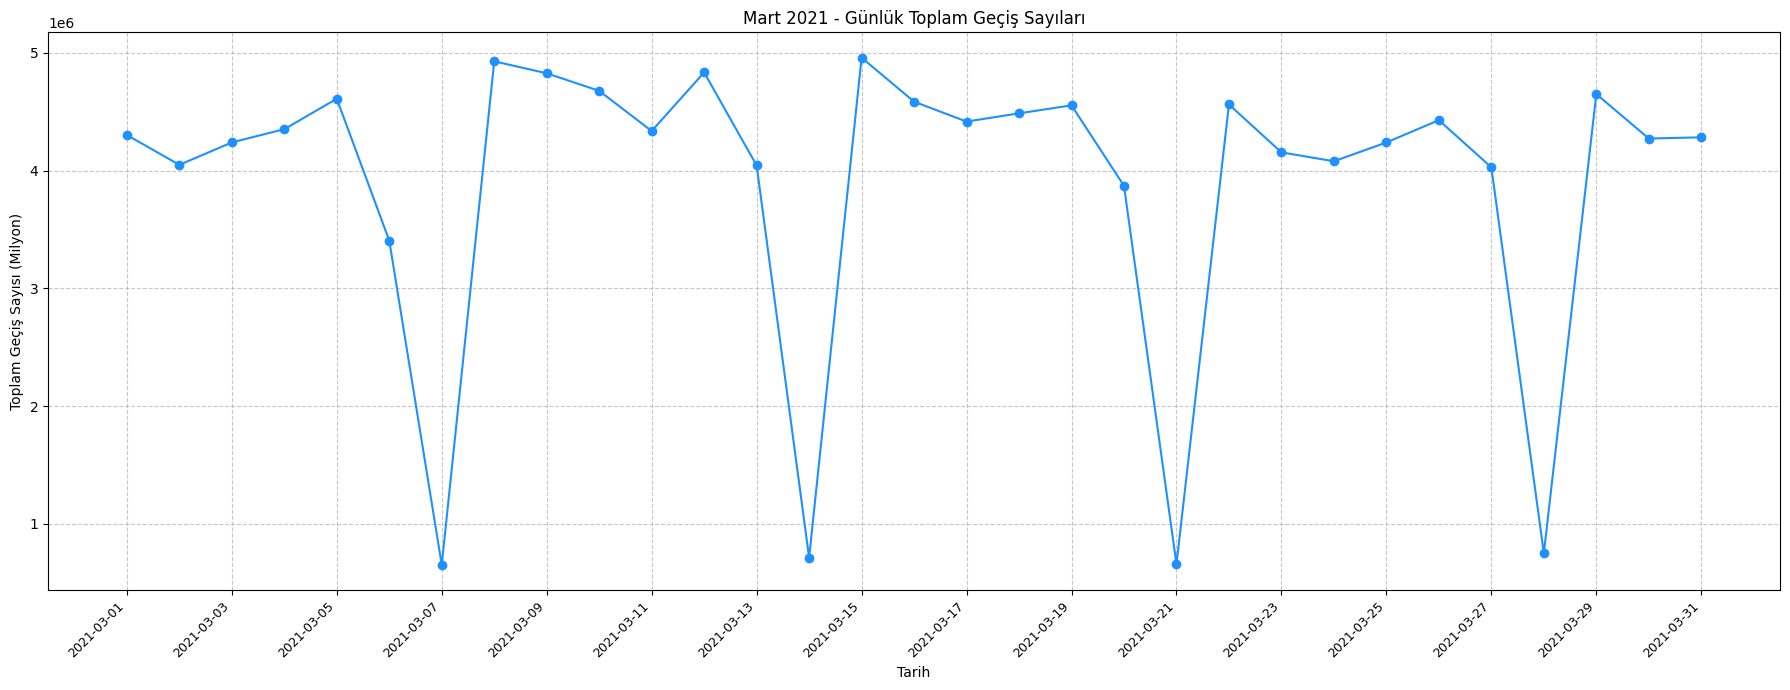

2025-05-21 19:47:00 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Mart 2021 - Günlük Toplam Geçiş Sayıları oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Mart 2021 - Günlük Toplam Geçiş Sayıları oluşturuldu.



2025-05-21 19:47:00 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- b. Haftanın Gününe Göre Ortalama Günlük Geçiş Sayıları ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- b. Haftanın Gününe Göre Ortalama Günlük Geçiş Sayıları ---


Haftanın Gününe Göre Ortalama Günlük Geçiş Sayıları:
day_of_week_name_cat
Monday       4679674.40
Tuesday      4377058.80
Wednesday    4338517.00
Thursday     4352837.25
Friday       4606201.00
Saturday     3836344.75
Sunday        692390.00


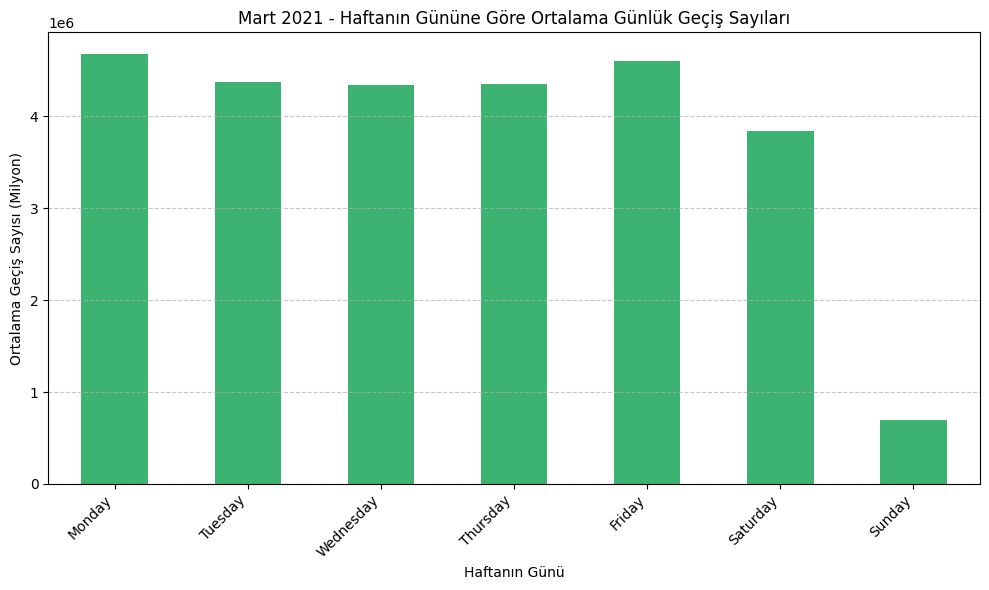

2025-05-21 19:47:03 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Mart 2021 - Haftanın Gününe Göre Ortalama Geçiş Sayıları oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Mart 2021 - Haftanın Gününe Göre Ortalama Geçiş Sayıları oluşturuldu.



2025-05-21 19:47:03 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ## 2. Ulaşım Modları ve Frekans Bilgisine İlk Bakış (Mart 2021) ##



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:## 2. Ulaşım Modları ve Frekans Bilgisine İlk Bakış (Mart 2021) ##



2025-05-21 19:47:03 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- a. Ana Ulaşım Modlarına Göre Saatlik Toplam Geçiş Profilleri ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- a. Ana Ulaşım Modlarına Göre Saatlik Toplam Geçiş Profilleri ---


2025-05-21 19:47:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 3_Otobus/Metrobus (Saatlik Toplam Geçişler) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 3_Otobus/Metrobus (Saatlik Toplam Geçişler) ---


transition_hour
0       36164
1        9179
2        4526
3        4213
4       13573
5      402942
6     2918746
7     6792037
8     7003198
9     4556205
10    3561967
11    3493541
12    3736177
13    4000680
14    4121181
15    4167227
16    4677527
17    5597695
18    6104122
19    5412718
20    3672279
21    1294199
22     488600
23     184231


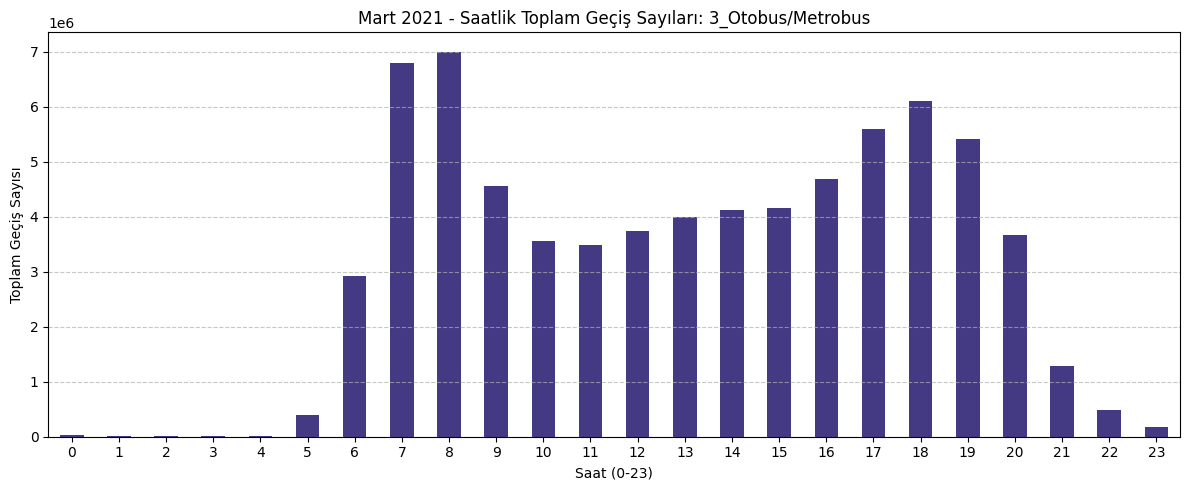

2025-05-21 19:47:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 3_Otobus/Metrobus için Saatlik Toplam Geçiş Sayıları oluşturuldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 3_Otobus/Metrobus için Saatlik Toplam Geçiş Sayıları oluşturuldu.


2025-05-21 19:47:08 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 1_Metro/Marmaray (Saatlik Toplam Geçişler) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 1_Metro/Marmaray (Saatlik Toplam Geçişler) ---


transition_hour
0        3788
1           6
2           3
3           2
4           4
5       78926
6      760611
7     2380808
8     3096294
9     1983190
10    1516681
11    1517039
12    1670026
13    1863721
14    1986512
15    2065192
16    2371823
17    3074396
18    3631078
19    2971665
20    1710532
21     470831
22     200439
23      91934


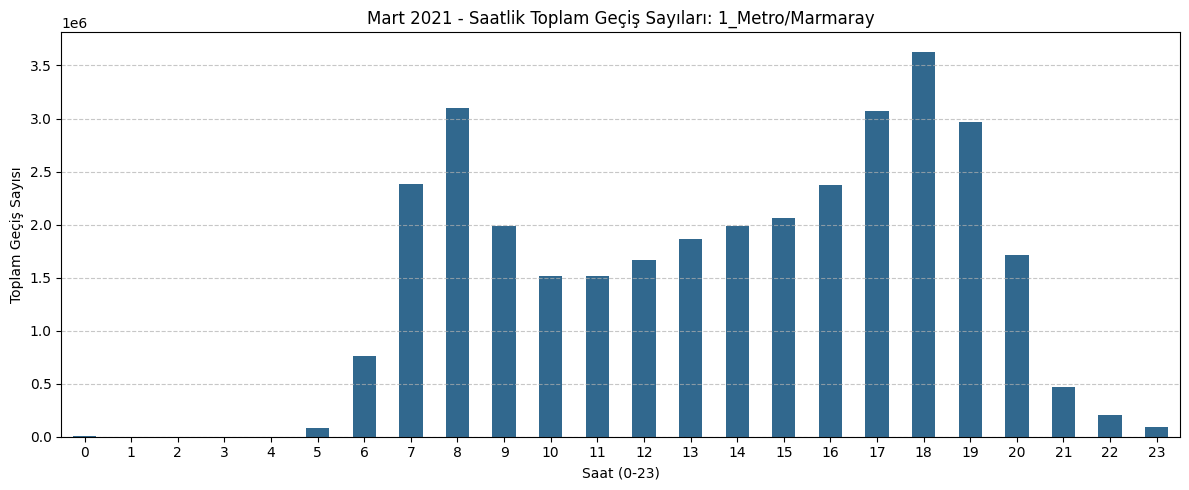

2025-05-21 19:47:08 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 1_Metro/Marmaray için Saatlik Toplam Geçiş Sayıları oluşturuldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 1_Metro/Marmaray için Saatlik Toplam Geçiş Sayıları oluşturuldu.


2025-05-21 19:47:09 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 0_Tramvay/LR (Saatlik Toplam Geçişler) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 0_Tramvay/LR (Saatlik Toplam Geçişler) ---


transition_hour
0        3899
1           5
2           2
4          88
5       14681
6      210067
7      754015
8     1009215
9      660260
10     588475
11     608114
12     679432
13     743690
14     806929
15     821222
16     833146
17     906192
18    1047170
19     973486
20     540297
21     189037
22      79539
23      41323


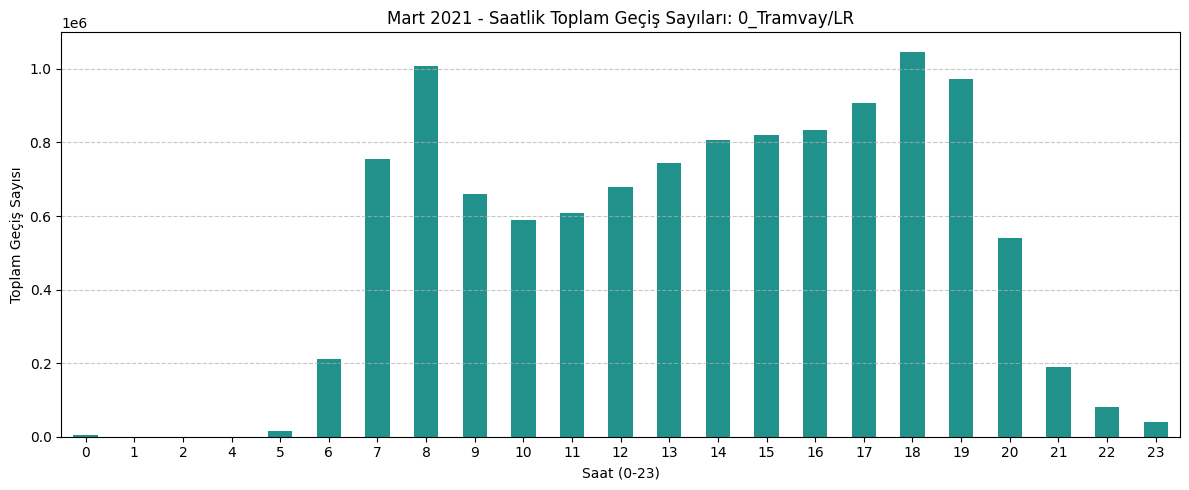

2025-05-21 19:47:10 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 0_Tramvay/LR için Saatlik Toplam Geçiş Sayıları oluşturuldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 0_Tramvay/LR için Saatlik Toplam Geçiş Sayıları oluşturuldu.


2025-05-21 19:47:11 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 4_Vapur (Saatlik Toplam Geçişler) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 4_Vapur (Saatlik Toplam Geçişler) ---


transition_hour
0         16
1         50
3          4
4         38
5        288
6      17609
7      91666
8     112265
9      80345
10     70115
11     76913
12     90845
13    102934
14    113949
15    131648
16    153151
17    192717
18    192136
19    125542
20     45800
21      9694
22      1770
23      1350


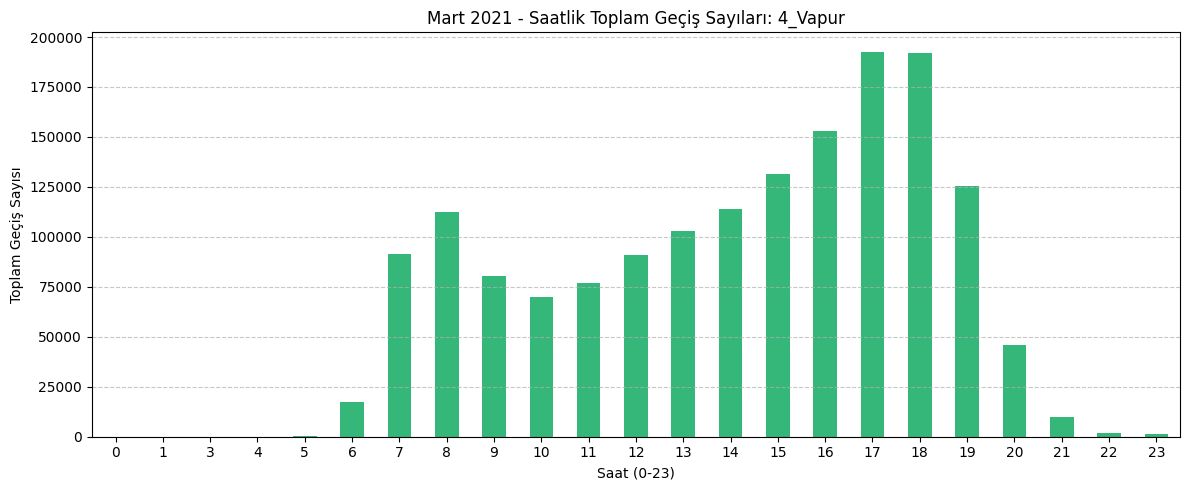

2025-05-21 19:47:11 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 4_Vapur için Saatlik Toplam Geçiş Sayıları oluşturuldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 4_Vapur için Saatlik Toplam Geçiş Sayıları oluşturuldu.


2025-05-21 19:47:11 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: Diger/Bilinmiyor (Saatlik Toplam Geçişler) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: Diger/Bilinmiyor (Saatlik Toplam Geçişler) ---


transition_hour
0        199
1         43
2        108
3         72
4        216
5       2830
6      27589
7      88441
8     107788
9      88233
10     93952
11    108184
12    127020
13    140668
14    153725
15    156325
16    157115
17    170589
18    160099
19    121577
20     47698
21      9056
22      3098
23      1598


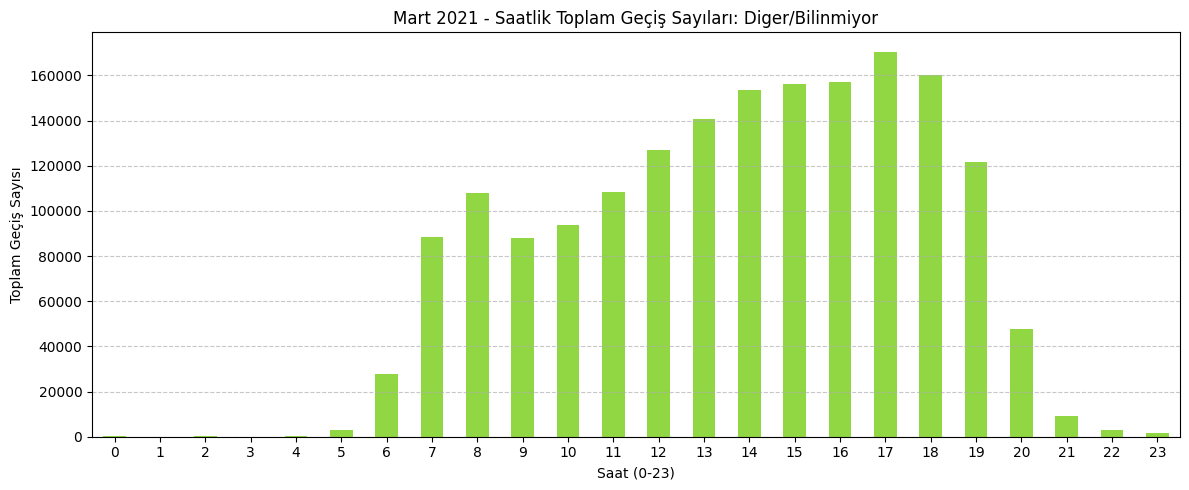

2025-05-21 19:47:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Diger/Bilinmiyor için Saatlik Toplam Geçiş Sayıları oluşturuldu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Diger/Bilinmiyor için Saatlik Toplam Geçiş Sayıları oluşturuldu.


2025-05-21 19:47:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:


2025-05-21 19:47:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- b. Frekans Bilgisi (gtfs_headway_secs) Atanmış Kayıtların Mod Dağılımı ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- b. Frekans Bilgisi (gtfs_headway_secs) Atanmış Kayıtların Mod Dağılımı ---


2025-05-21 19:47:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Toplam 802,442 kayda headway bilgisi atanmış.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Toplam 802,442 kayda headway bilgisi atanmış.


Headway Atanmış Kayıtların Mod Dağılımı (Kayıt Sayısı):
final_route_type_desc
1_Metro/Marmaray     638270
3_Otobus/Metrobus     75182
4_Vapur               65030
7_Funikuler           15804
6_HavaiTramvay         8156

Headway Atanmış Kayıtların Mod Dağılımı (Toplam Geçiş Sayısı):
final_route_type_desc
1_Metro/Marmaray     10507299
3_Otobus/Metrobus      845382
4_Vapur                620754
7_Funikuler            162991
6_HavaiTramvay          49563


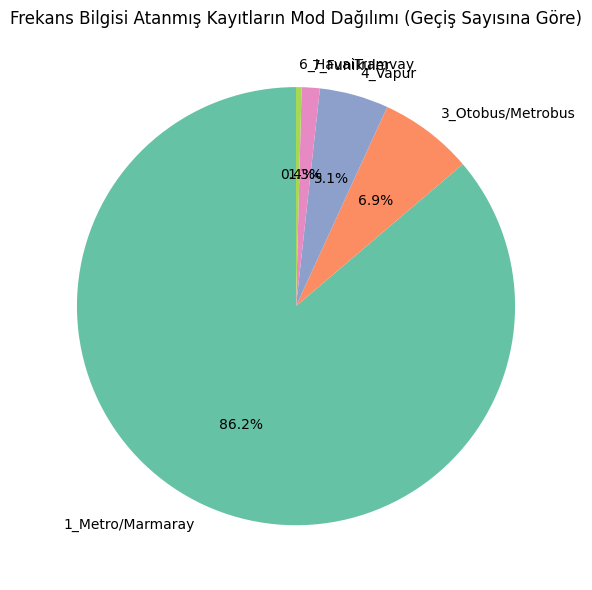

2025-05-21 19:47:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Frekans Bilgisi Atanmış Kayıtların Mod Dağılımı (Pie Chart) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Frekans Bilgisi Atanmış Kayıtların Mod Dağılımı (Pie Chart) oluşturuldu.



2025-05-21 19:47:12 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- c. Frekans Bilgisi Olan Modlar İçin Ortalama Sefer Sıklıkları ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- c. Frekans Bilgisi Olan Modlar İçin Ortalama Sefer Sıklıkları ---
<ipython-input-10-61b281cb4073>:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_headway['gtfs_headway_mins'] = df_with_headway['gtfs_headway_secs'] / 60


Modlara Göre Ortalama Sefer Sıklığı (Dakika):
final_route_type_desc
7_Funikuler                7.0
6_HavaiTramvay            10.0
1_Metro/Marmaray     11.800418
3_Otobus/Metrobus    22.810699
4_Vapur              59.155774


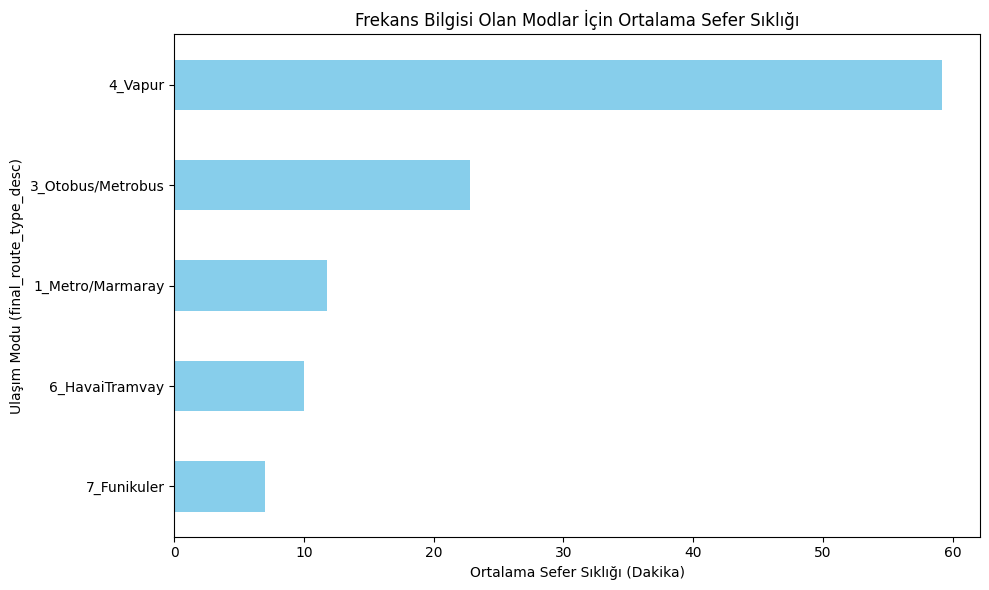

2025-05-21 19:47:13 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Modlara Göre Ortalama Sefer Sıklıkları oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Modlara Göre Ortalama Sefer Sıklıkları oluşturuldu.



2025-05-21 19:47:13 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.0 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.0 TAMAMLANDI =====


In [10]:
# === Hücre 3.0: EDA Başlangıç - Kurulum, Zamansal Analizler ve Mod Bazlı İlk Bakış ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Grafiklerde ve hesaplamalarda gerekebilir
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum') # Önceki logger'ı kullanıyoruz
logger.info("===== HÜCRE 3.0 BAŞLATILIYOR: EDA Başlangıç - Kurulum, Zamansal Analizler ve Mod Bazlı İlk Bakış =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_analysis_mart2021' not in locals() or df_analysis_mart2021 is None or df_analysis_mart2021.empty:
    logger.error("HATA: 'df_analysis_mart2021' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen Adım 1 ve Adım 2'ye ait tüm hücreleri (2.0'dan 2.6'ya kadar) başarıyla çalıştırdığınızdan emin olun.")
    error_in_eda_setup = True
else:
    error_in_eda_setup = False
    logger.info("'df_analysis_mart2021' DataFrame başarıyla bulundu. EDA için ön hazırlıklar yapılıyor...")

    # --- Gerekli Ön İşlemler ve Sütun Kontrolleri (EDA için) ---
    # transition_date'in datetime olduğundan emin ol (Adım 1'de yapılmıştı)
    if not pd.api.types.is_datetime64_any_dtype(df_analysis_mart2021['transition_date']):
        logger.warning("Uyarı: 'transition_date' sütunu datetime formatında değil. Çevriliyor...")
        df_analysis_mart2021['transition_date'] = pd.to_datetime(df_analysis_mart2021['transition_date'])

    # final_route_type_desc sütununun varlığını kontrol et (Hücre 2.4'te oluşturulmuştu)
    if 'final_route_type_desc' not in df_analysis_mart2021.columns:
        logger.error("HATA: 'final_route_type_desc' sütunu bulunamadı. Lütfen Hücre 2.4'ü kontrol edin.")
        error_in_eda_setup = True

    # EDA'da kullanılacak genel bir hat adı sütunu oluşturalım (önceki EDA'lardaki gibi)
    # gtfs_route_long_name varsa onu, yoksa gtfs_route_short_name'i, o da yoksa orijinal line_name'i kullan
    if not error_in_eda_setup:
        df_analysis_mart2021['display_route_name_eda'] = df_analysis_mart2021['gtfs_route_long_name'].fillna(
                                                        df_analysis_mart2021['gtfs_route_short_name'].fillna(
                                                        df_analysis_mart2021['line_name']))
        logger.info("'display_route_name_eda' sütunu (analiz için hat adı) oluşturuldu/güncellendi.")

if not error_in_eda_setup:
    # --- 1. Zamansal Analizler (Mart 2021) ---
    logger.info("\n## 1. Zamansal Analizler (Mart 2021) ##")

    # a. Günlük Toplam Geçiş Sayıları
    logger.info("\n--- a. Günlük Toplam Geçiş Sayıları ---")
    # `date_only` sütunu oluştur (eğer yoksa veya farklı bir hücrede kaldıysa)
    df_analysis_mart2021['date_only'] = df_analysis_mart2021['transition_date'].dt.date
    daily_passages_mart2021 = df_analysis_mart2021.groupby('date_only')['number_of_passage'].sum()

    print("Günlük Toplam Geçiş Sayıları (İlk 5 Gün):")
    print(daily_passages_mart2021.head().to_string())

    plt.figure(figsize=(18, 7))
    daily_passages_mart2021.plot(kind='line', marker='o', linestyle='-', color='dodgerblue')
    plt.title('Mart 2021 - Günlük Toplam Geçiş Sayıları')
    plt.xlabel('Tarih')
    plt.ylabel('Toplam Geçiş Sayısı (Milyon)')
    plt.grid(True, linestyle='--', alpha=0.7)
    # X ekseni etiketlerini daha okunabilir yapalım
    tick_locations = daily_passages_mart2021.index
    if len(tick_locations) > 0 and hasattr(tick_locations[0], 'strftime'): # strftime için kontrol
        tick_labels = [date_obj.strftime('%Y-%m-%d') for date_obj in tick_locations]
        label_frequency = max(1, len(tick_labels) // 15) # Çok fazla etiket olmasın
        plt.xticks(ticks=tick_locations[::label_frequency], labels=tick_labels[::label_frequency], rotation=45, ha='right', fontsize=9)
    plt.tight_layout()
    plt.show()
    logger.info("Grafik: Mart 2021 - Günlük Toplam Geçiş Sayıları oluşturuldu.\n")

    # b. Haftanın Gününe Göre Ortalama Geçiş Sayıları
    logger.info("--- b. Haftanın Gününe Göre Ortalama Günlük Geçiş Sayıları ---")
    df_analysis_mart2021['day_of_week_name'] = df_analysis_mart2021['transition_date'].dt.day_name()
    # Günleri İngilizce sıralayalım (Türkçe locale ayarı yoksa sorun olabilir, ama genelde çalışır)
    days_ordered = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    try:
        df_analysis_mart2021['day_of_week_name_cat'] = pd.Categorical(df_analysis_mart2021['day_of_week_name'], categories=days_ordered, ordered=True)
        sum_passages_by_dayofweek = df_analysis_mart2021.groupby('day_of_week_name_cat', observed=False)['number_of_passage'].sum()
        num_occurrences_of_day = df_analysis_mart2021.groupby('day_of_week_name_cat', observed=False)['date_only'].nunique()
        avg_passages_by_dayofweek = (sum_passages_by_dayofweek / num_occurrences_of_day).reindex(days_ordered).dropna()
    except Exception as e_cat_day:
        logger.warning(f"Uyarı: Gün isimleri sıralanırken hata ({e_cat_day}), sırasız devam edilecek.")
        sum_passages_by_dayofweek = df_analysis_mart2021.groupby('day_of_week_name')['number_of_passage'].sum()
        num_occurrences_of_day = df_analysis_mart2021.groupby('day_of_week_name')['date_only'].nunique()
        avg_passages_by_dayofweek = (sum_passages_by_dayofweek / num_occurrences_of_day).dropna().reindex(days_ordered, fill_value=0)


    print("Haftanın Gününe Göre Ortalama Günlük Geçiş Sayıları:")
    print(avg_passages_by_dayofweek.to_string())
    plt.figure(figsize=(10, 6))
    avg_passages_by_dayofweek.plot(kind='bar', color='mediumseagreen')
    plt.title('Mart 2021 - Haftanın Gününe Göre Ortalama Günlük Geçiş Sayıları')
    plt.xlabel('Haftanın Günü')
    plt.ylabel('Ortalama Geçiş Sayısı (Milyon)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    logger.info("Grafik: Mart 2021 - Haftanın Gününe Göre Ortalama Geçiş Sayıları oluşturuldu.\n")

    # --- 2. Ulaşım Modları ve Frekans Bilgisine İlk Bakış ---
    logger.info("## 2. Ulaşım Modları ve Frekans Bilgisine İlk Bakış (Mart 2021) ##\n")

    # a. Ana Ulaşım Modlarına Göre Saatlik Yoğunluk Profilleri (final_route_type_desc üzerinden)
    # (Bu, önceki EDA'daki gibi, frekanssız genel bir bakış)
    logger.info("--- a. Ana Ulaşım Modlarına Göre Saatlik Toplam Geçiş Profilleri ---")
    main_modes_for_profile = ["3_Otobus/Metrobus", "1_Metro/Marmaray", "0_Tramvay/LR", "4_Vapur", "Diger/Bilinmiyor"]
    # Renk paleti belirleyelim
    mode_colors = sns.color_palette("viridis", len(main_modes_for_profile))

    for i, mode in enumerate(main_modes_for_profile):
        df_mode_subset = df_analysis_mart2021[df_analysis_mart2021['final_route_type_desc'] == mode]
        if df_mode_subset.empty:
            logger.info(f"Mod: {mode} için Mart 2021'de kayıt bulunmamaktadır.")
            continue

        hourly_summary_mode = df_mode_subset.groupby('transition_hour')['number_of_passage'].sum()
        logger.info(f"\n--- Mod: {mode} (Saatlik Toplam Geçişler) ---")
        print(hourly_summary_mode.to_string())

        plt.figure(figsize=(12, 5))
        hourly_summary_mode.plot(kind='bar', color=mode_colors[i])
        plt.title(f'Mart 2021 - Saatlik Toplam Geçiş Sayıları: {mode}')
        plt.xlabel('Saat (0-23)')
        plt.ylabel('Toplam Geçiş Sayısı')
        plt.xticks(rotation=0)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        logger.info(f"Grafik: {mode} için Saatlik Toplam Geçiş Sayıları oluşturuldu.")
    logger.info("")

    # b. Frekans Bilgisi Atanmış Kayıtların Mod Dağılımı
    logger.info("--- b. Frekans Bilgisi (gtfs_headway_secs) Atanmış Kayıtların Mod Dağılımı ---")
    if 'gtfs_headway_secs' in df_analysis_mart2021.columns:
        df_with_headway = df_analysis_mart2021[df_analysis_mart2021['gtfs_headway_secs'].notna()]
        if not df_with_headway.empty:
            headway_mod_dist = df_with_headway['final_route_type_desc'].value_counts()
            total_with_headway = len(df_with_headway)
            logger.info(f"Toplam {total_with_headway:,} kayda headway bilgisi atanmış.")
            print("Headway Atanmış Kayıtların Mod Dağılımı (Kayıt Sayısı):")
            print(headway_mod_dist.to_string())

            passage_with_headway_mod_dist = df_with_headway.groupby('final_route_type_desc')['number_of_passage'].sum().sort_values(ascending=False)
            print("\nHeadway Atanmış Kayıtların Mod Dağılımı (Toplam Geçiş Sayısı):")
            print(passage_with_headway_mod_dist.to_string())

            plt.figure(figsize=(10,6))
            passage_with_headway_mod_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
            plt.title('Frekans Bilgisi Atanmış Kayıtların Mod Dağılımı (Geçiş Sayısına Göre)')
            plt.ylabel('') # y ekseni etiketini kaldır (pie chart için)
            plt.tight_layout()
            plt.show()
            logger.info("Grafik: Frekans Bilgisi Atanmış Kayıtların Mod Dağılımı (Pie Chart) oluşturuldu.\n")

            # c. Modlara Göre Ortalama Sefer Sıklıkları (Headway)
            logger.info("--- c. Frekans Bilgisi Olan Modlar İçin Ortalama Sefer Sıklıkları ---")
            # headway_secs saniye cinsinden, dakikaya çevirelim
            df_with_headway['gtfs_headway_mins'] = df_with_headway['gtfs_headway_secs'] / 60
            avg_headway_by_mode = df_with_headway.groupby('final_route_type_desc')['gtfs_headway_mins'].mean().sort_values()
            print("Modlara Göre Ortalama Sefer Sıklığı (Dakika):")
            print(avg_headway_by_mode.to_string())

            if not avg_headway_by_mode.empty:
                plt.figure(figsize=(10,6))
                avg_headway_by_mode.plot(kind='barh', color='skyblue')
                plt.title('Frekans Bilgisi Olan Modlar İçin Ortalama Sefer Sıklığı')
                plt.xlabel('Ortalama Sefer Sıklığı (Dakika)')
                plt.ylabel('Ulaşım Modu (final_route_type_desc)')
                plt.tight_layout()
                plt.show()
                logger.info("Grafik: Modlara Göre Ortalama Sefer Sıklıkları oluşturuldu.\n")

        else:
            logger.info("Hiçbir kayda headway bilgisi atanmamış. Frekansla ilgili mod analizleri atlanıyor.")
    else:
        logger.warning("'gtfs_headway_secs' sütunu df_analysis_mart2021'de bulunmuyor. Frekans analizleri atlanıyor.")

    logger.info("===== HÜCRE 3.0 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame veya sütunlar eksik olduğu için Hücre 3.0 (EDA Başlangıç) çalıştırılamadı.")

2025-05-21 19:51:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.1 BAŞLATILIYOR: En Yoğun Hatlar ve İlçeler Analizi =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.1 BAŞLATILIYOR: En Yoğun Hatlar ve İlçeler Analizi =====


2025-05-21 19:51:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' DataFrame başarıyla bulundu. Analizlere devam ediliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' DataFrame başarıyla bulundu. Analizlere devam ediliyor...


2025-05-21 19:51:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## 1. En Yoğun Hat Analizleri (Mart 2021) ##


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## 1. En Yoğun Hat Analizleri (Mart 2021) ##


2025-05-21 19:51:43 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- a. Genel Olarak En Yoğun İlk 15 Hat ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- a. Genel Olarak En Yoğun İlk 15 Hat ---


Genel Olarak En Yoğun İlk 15 Hat (Toplam Geçiş Sayısı):
display_route_name_eda
ZİNCİRLİKUYU - AVCILAR MRK.ÜNV.KMP.        13914237
GEBZE-HALKALI                               8044421
BAĞCILAR - KABATAŞ                          7955103
YENİKAPI - HACIOSMAN                        6991057
YENİKAPI - KİRAZLI                          6901846
ÜSKÜDAR - ÇEKMEKÖY                          3780156
KADIKÖY - TAVŞANTEPE                        3648834
TOPKAPI - MESCİD-İ SELAM                    3507523
YILDIZ - MAHMUTBEY                          2485745
SÖĞÜTLÜÇEŞME - CEVİZLİBAĞ                   2180990
KİRAZLI - OLİMPİYAT - BAŞAKŞEHİR            1421240
KADIKÖY - YENİDOĞAN PERONLAR                1278365
ÇENGELKÖY - İSTİNYE                          811047
CEVİZLİBAĞ - ŞİFA SONDURAK                   752764
ÜSKÜDAR MARMARAY - SULTANBEYLİ PERONLAR      642539


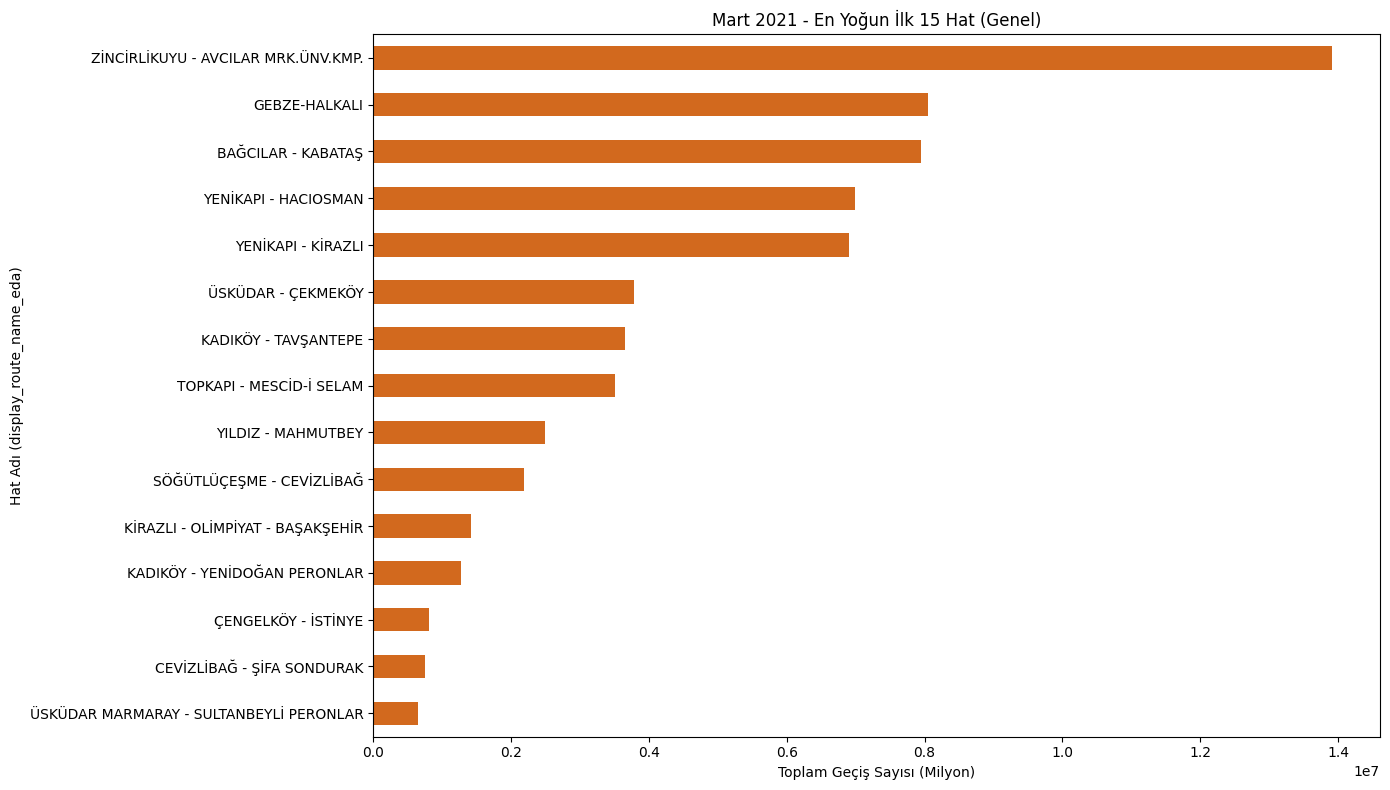

2025-05-21 19:51:44 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Mart 2021 - En Yoğun İlk 15 Hat (Genel) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Mart 2021 - En Yoğun İlk 15 Hat (Genel) oluşturuldu.



2025-05-21 19:51:44 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- b. Ana Ulaşım Modlarına Göre En Yoğun İlk 5 Hat ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- b. Ana Ulaşım Modlarına Göre En Yoğun İlk 5 Hat ---


2025-05-21 19:51:46 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 3_Otobus/Metrobus - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 3_Otobus/Metrobus - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


display_route_name_eda
ZİNCİRLİKUYU - AVCILAR MRK.ÜNV.KMP.        13914237
SÖĞÜTLÜÇEŞME - CEVİZLİBAĞ                   2180990
KADIKÖY - YENİDOĞAN PERONLAR                1278365
CEVİZLİBAĞ - ŞİFA SONDURAK                   752764
ÜSKÜDAR MARMARAY - SULTANBEYLİ PERONLAR      642539


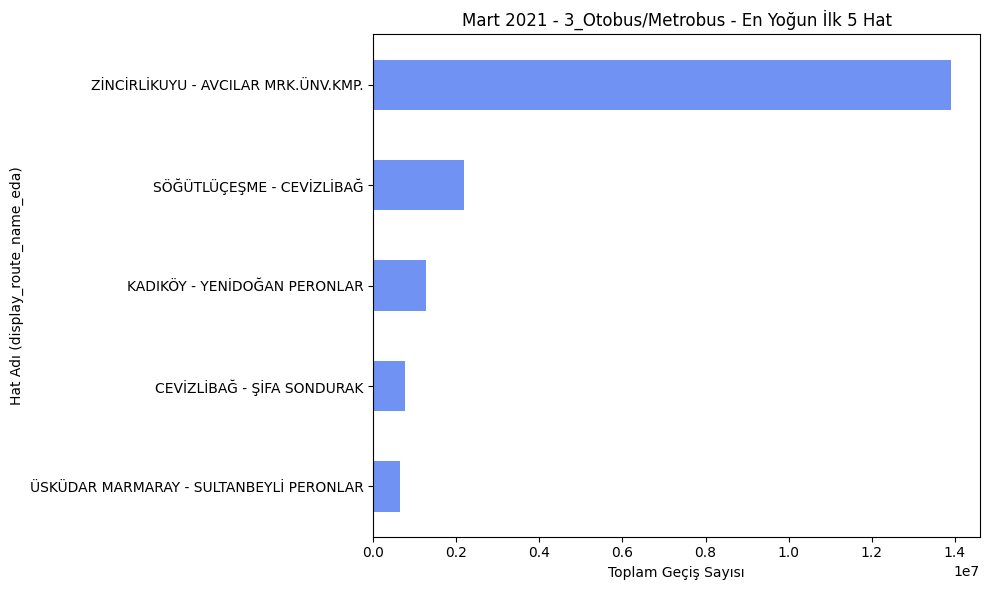

2025-05-21 19:51:46 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 3_Otobus/Metrobus - En Yoğun İlk 5 Hat oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 3_Otobus/Metrobus - En Yoğun İlk 5 Hat oluşturuldu.



2025-05-21 19:51:48 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 1_Metro/Marmaray - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 1_Metro/Marmaray - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


display_route_name_eda
GEBZE-HALKALI           8044421
YENİKAPI - HACIOSMAN    6991057
YENİKAPI - KİRAZLI      6901846
ÜSKÜDAR - ÇEKMEKÖY      3780156
KADIKÖY - TAVŞANTEPE    3648834


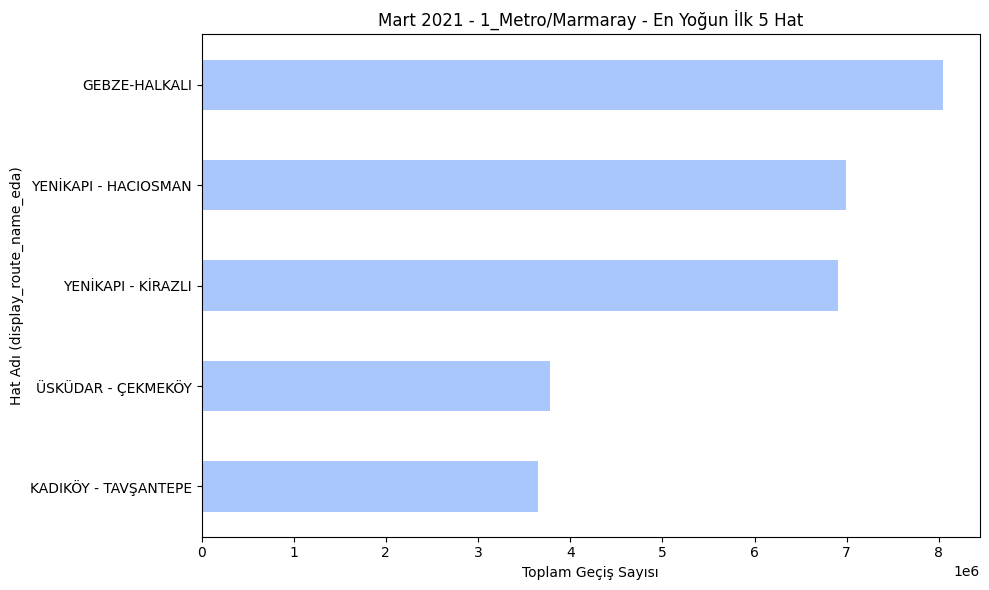

2025-05-21 19:51:48 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 1_Metro/Marmaray - En Yoğun İlk 5 Hat oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 1_Metro/Marmaray - En Yoğun İlk 5 Hat oluşturuldu.



2025-05-21 19:51:49 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 0_Tramvay/LR - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 0_Tramvay/LR - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


display_route_name_eda
BAĞCILAR - KABATAŞ          7955103
TOPKAPI - MESCİD-İ SELAM    3507523
KADIKÖY - MODA                47658


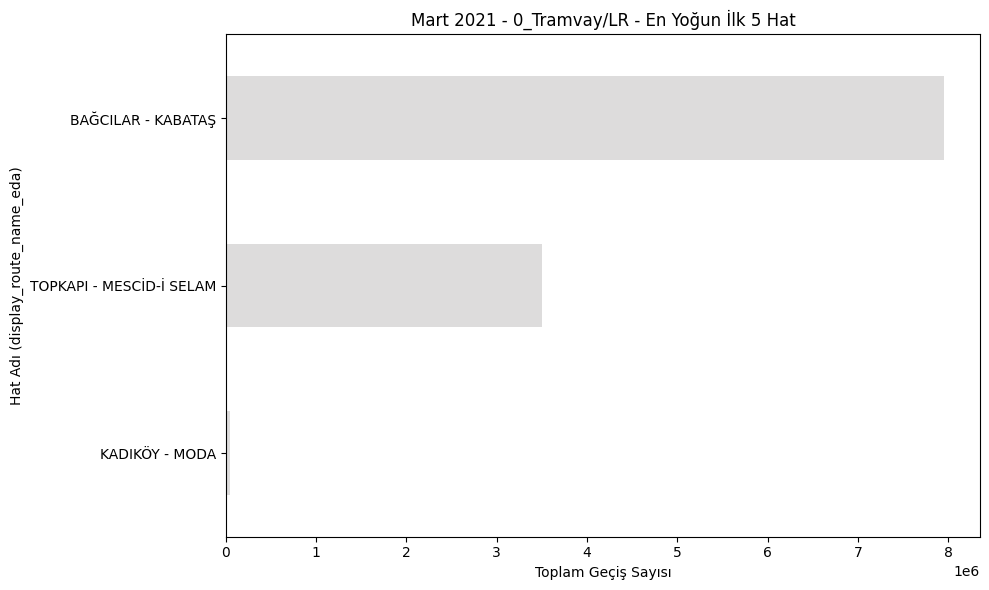

2025-05-21 19:51:49 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 0_Tramvay/LR - En Yoğun İlk 5 Hat oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 0_Tramvay/LR - En Yoğun İlk 5 Hat oluşturuldu.



2025-05-21 19:51:50 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- Mod: 4_Vapur - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- Mod: 4_Vapur - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---


display_route_name_eda
ÇENGELKÖY - İSTİNYE                           811047
ÜSKÜDAR-EMİNÖNÜ                               220222
BOĞAZA GİDİŞ                                  181836
HEYBELİADA-BÜYÜKADA                           174875
ÜSKÜDAR-KARAKÖY-EMİNÖNÜ-EYÜP (HALİÇ HATTI)    156201


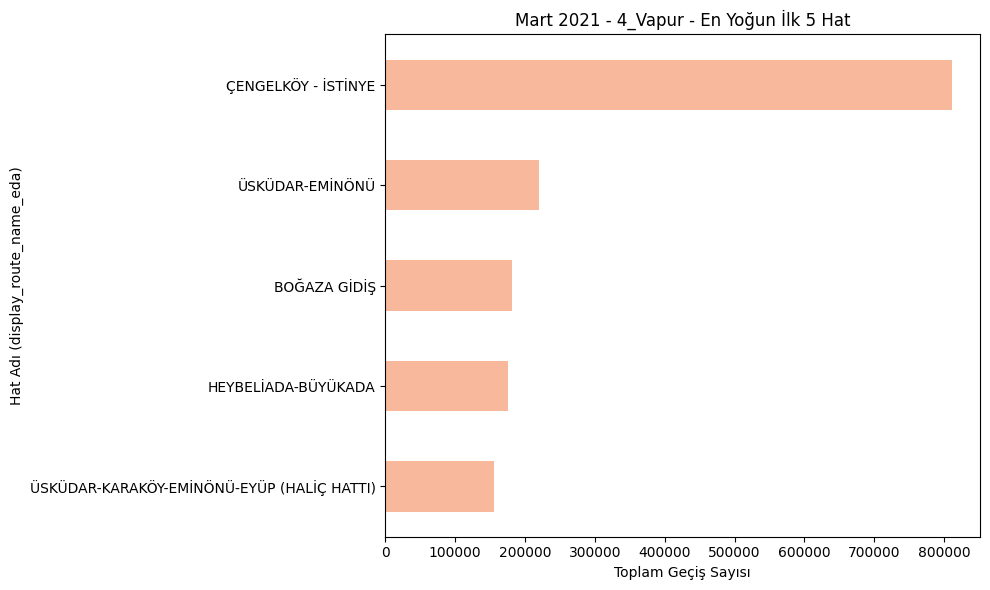

2025-05-21 19:51:50 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: 4_Vapur - En Yoğun İlk 5 Hat oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: 4_Vapur - En Yoğun İlk 5 Hat oluşturuldu.



2025-05-21 19:51:50 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- c. Frekans Bilgisi (gtfs_headway_secs) Olan En Yoğun Hatların Ortalama Frekansları ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- c. Frekans Bilgisi (gtfs_headway_secs) Olan En Yoğun Hatların Ortalama Frekansları ---


2025-05-21 19:51:51 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Frekans Bilgisi Olan En Yoğun İlk 10 Hat ve Ortalama Sefer Sıklıkları:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Frekans Bilgisi Olan En Yoğun İlk 10 Hat ve Ortalama Sefer Sıklıkları:


                                            total_passages avg_headway_mins
display_route_name_eda                                                     
GEBZE-HALKALI                                      8021554             15.0
YILDIZ - MAHMUTBEY                                 2485745          6.30673
MEHMETÇİK SOKAK - EMİNÖNÜ MISIR ÇARŞISI             271018        22.681135
ÇENGELKÖY - İSTİNYE                                 230924       155.678457
ÜSKÜDAR-EMİNÖNÜ                                     220032         20.45846
NİŞANGAH - EMİNÖNÜ                                  183896        22.287647
KARAKÖY - BEYOĞLU                                   162991              7.0
AYDINLI TOKİ PERONLAR - KARTAL                      161204         9.063792
ÜSKÜDAR-KARAKÖY-EMİNÖNÜ-EYÜP (HALİÇ HATTI)          153438        61.380843
KADIKÖY - SABİHA GÖKÇEN HAVALİMANI                   73059        22.731229
2025-05-21 19:51:51 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## 2. En Yoğun İlçe 

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## 2. En Yoğun İlçe Analizleri (Mart 2021) ##


2025-05-21 19:51:51 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- a. En Yoğun İlk 15 İlçe (Toplam Geçiş Sayısına Göre) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- a. En Yoğun İlk 15 İlçe (Toplam Geçiş Sayısına Göre) ---


En Yoğun İlk 15 İlçe (Toplam Geçiş Sayısı):
town
BAKIRKOY        44005787
FATIH           11382514
USKUDAR          5871461
SISLI            5288839
KUCUKCEKMECE     4352725
SARIYER          4178315
KADIKOY          4122744
ZEYTINBURNU      3826569
PENDIK           3196905
KARTAL           2770494
ATASEHIR         2593281
KAGITHANE        2342818
BEYOGLU          2312009
EYUPSULTAN       1784545
BAGCILAR         1654967


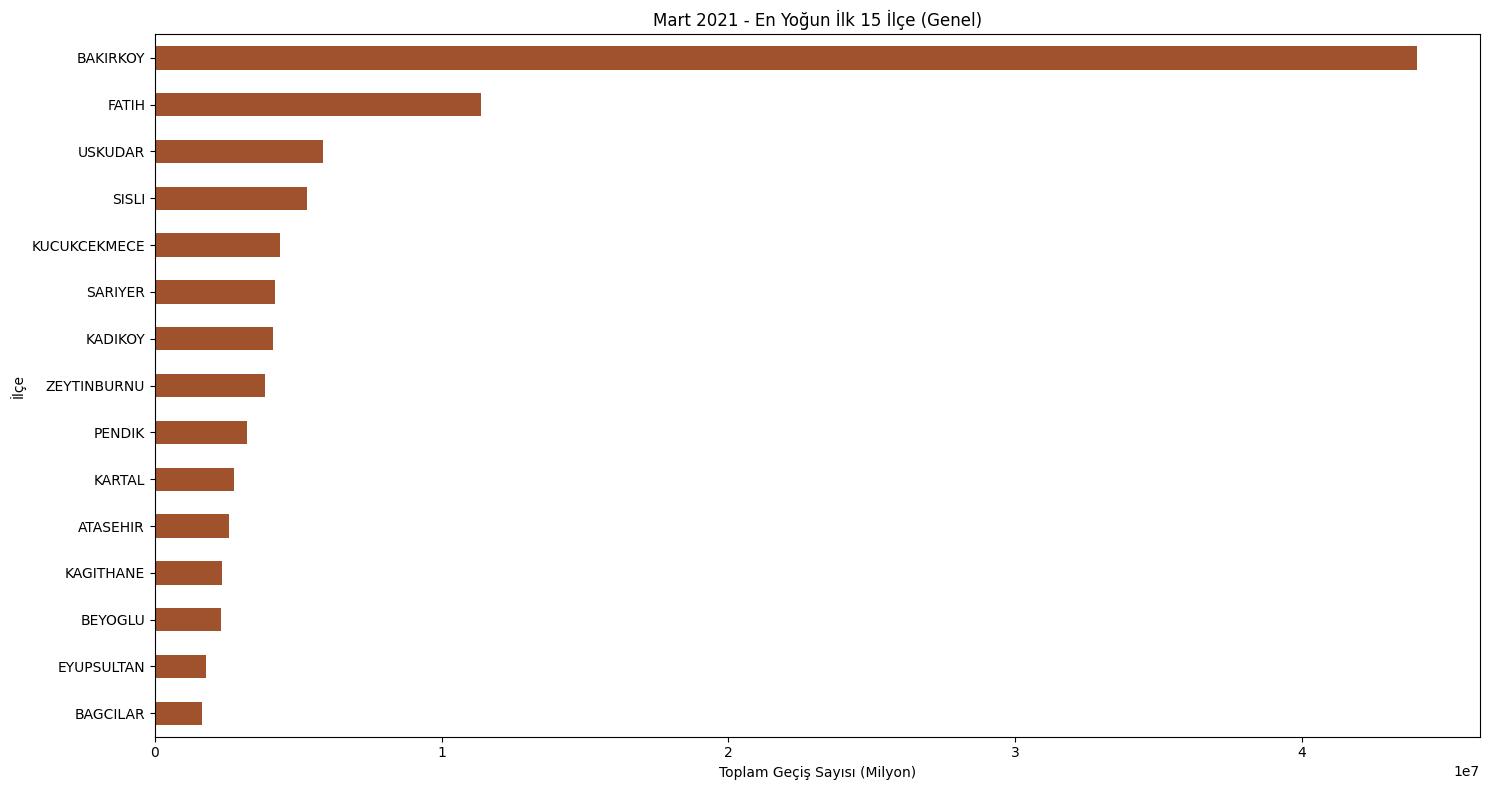

2025-05-21 19:51:52 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Mart 2021 - En Yoğun İlk 15 İlçe (Genel) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Mart 2021 - En Yoğun İlk 15 İlçe (Genel) oluşturuldu.



2025-05-21 19:51:52 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - --- b. En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı (Geçiş Sayısına Göre) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:--- b. En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı (Geçiş Sayısına Göre) ---


En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı (Toplam Geçiş Sayısı):
final_route_type_desc  0_Tramvay/LR  1_Metro/Marmaray  3_Otobus/Metrobus  4_Vapur  Diger/Bilinmiyor
town                                                                                               
BAKIRKOY                     652340           1854379           41365559    22500            111009
FATIH                       3920361           5832960             932615   256730            439848
USKUDAR                           0           3569237            1541261   427613            333350


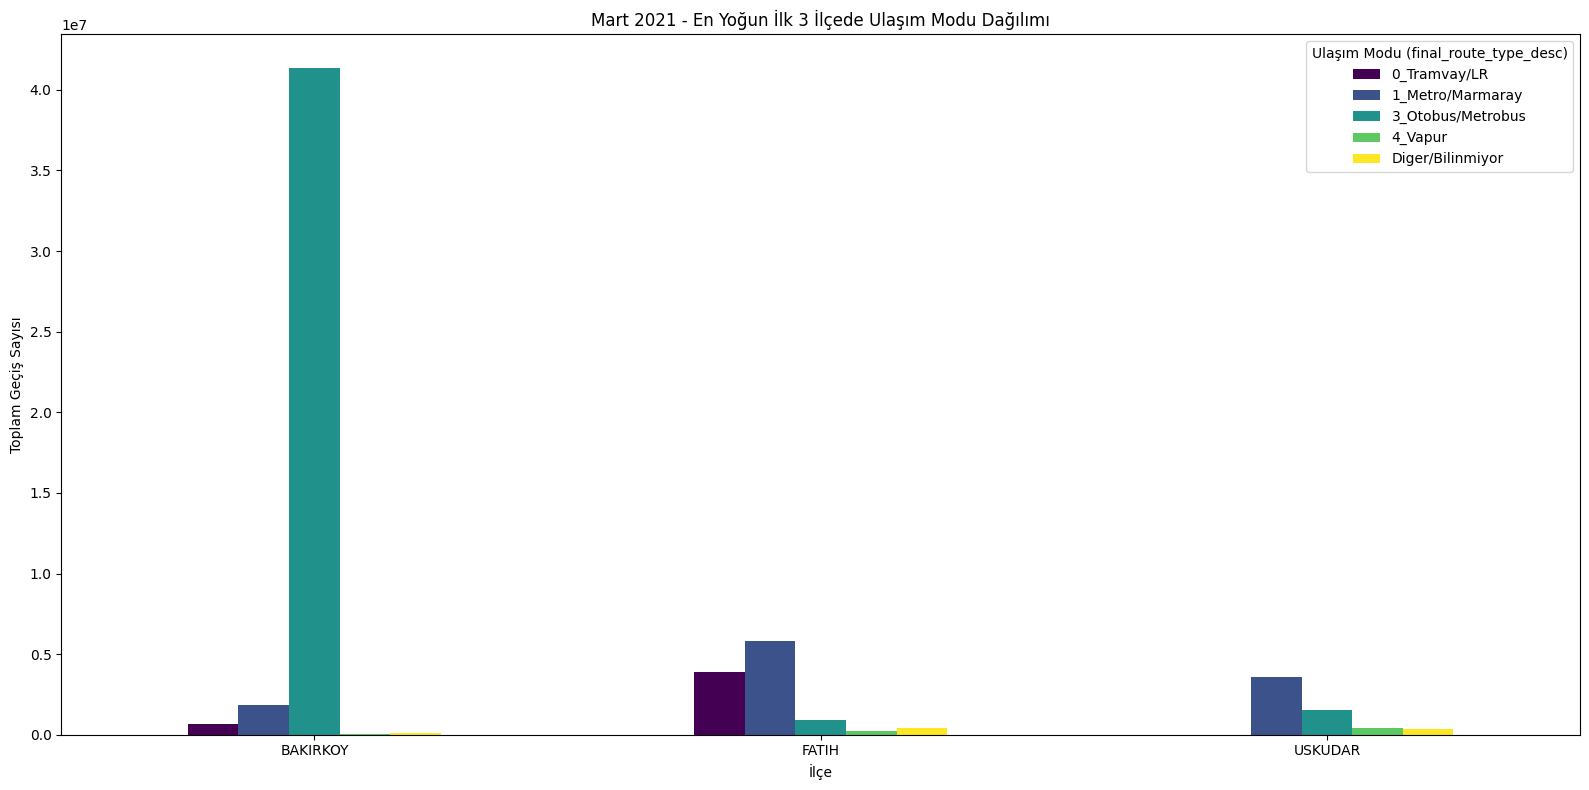

2025-05-21 19:51:54 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı oluşturuldu.



2025-05-21 19:51:54 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.1 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.1 TAMAMLANDI =====


In [11]:
# === Hücre 3.1: En Yoğun Hatlar ve İlçeler Analizi ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 3.1 BAŞLATILIYOR: En Yoğun Hatlar ve İlçeler Analizi =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_analysis_mart2021' not in locals() or df_analysis_mart2021 is None or df_analysis_mart2021.empty:
    logger.error("HATA: 'df_analysis_mart2021' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen Adım 1 ve Adım 2'ye ait tüm hücreleri (2.0'dan 2.6'ya kadar) ve Hücre 3.0'ı başarıyla çalıştırdığınızdan emin olun.")
    error_in_eda_3_1 = True
else:
    error_in_eda_3_1 = False
    logger.info("'df_analysis_mart2021' DataFrame başarıyla bulundu. Analizlere devam ediliyor...")
    # display_route_name_eda ve final_route_type_desc sütunlarının Hücre 3.0'da oluşturulduğunu varsayıyoruz.

if not error_in_eda_3_1:
    # --- 1. En Yoğun Hat Analizleri ---
    logger.info("\n## 1. En Yoğun Hat Analizleri (Mart 2021) ##")

    # a. Genel Olarak En Yoğun İlk 15 Hat (Toplam Geçiş Sayısına Göre)
    logger.info("\n--- a. Genel Olarak En Yoğun İlk 15 Hat ---")
    if 'display_route_name_eda' in df_analysis_mart2021.columns and 'number_of_passage' in df_analysis_mart2021.columns:
        top_15_lines_overall = df_analysis_mart2021.groupby('display_route_name_eda')['number_of_passage'].sum().nlargest(15)
        print("Genel Olarak En Yoğun İlk 15 Hat (Toplam Geçiş Sayısı):")
        print(top_15_lines_overall.to_string())

        plt.figure(figsize=(14, 8))
        top_15_lines_overall.sort_values(ascending=True).plot(kind='barh', color='chocolate') # sort_values ile daha iyi görünüm
        plt.title('Mart 2021 - En Yoğun İlk 15 Hat (Genel)')
        plt.xlabel('Toplam Geçiş Sayısı (Milyon)')
        plt.ylabel('Hat Adı (display_route_name_eda)')
        # plt.gca().invert_yaxis() # sort_values(ascending=True) ile gerek kalmadı
        plt.tight_layout()
        plt.show()
        logger.info("Grafik: Mart 2021 - En Yoğun İlk 15 Hat (Genel) oluşturuldu.\n")
    else:
        logger.warning("En yoğun hat analizi için 'display_route_name_eda' veya 'number_of_passage' sütunları bulunamadı.")

    # b. Ana Ulaşım Modlarına Göre En Yoğun İlk 5 Hat
    logger.info("--- b. Ana Ulaşım Modlarına Göre En Yoğun İlk 5 Hat ---")
    if 'final_route_type_desc' in df_analysis_mart2021.columns:
        # main_modes_for_profile Hücre 3.0'da tanımlanmıştı, burada tekrar tanımlayalım veya global kullanalım.
        # Şimdilik burada tekrar tanımlayalım, daha sık kullanılanları alalım.
        main_modes_for_top_lines = ["3_Otobus/Metrobus", "1_Metro/Marmaray", "0_Tramvay/LR", "4_Vapur"]
        # mode_colors_top = sns.color_palette("Set1", len(main_modes_for_top_lines)) # Farklı bir palet

        for i, mode in enumerate(main_modes_for_top_lines):
            df_mode_lines = df_analysis_mart2021[df_analysis_mart2021['final_route_type_desc'] == mode]
            if df_mode_lines.empty:
                logger.info(f"Mod: {mode} için Mart 2021'de kayıt bulunmamaktadır.")
                continue

            top_5_lines_mode = df_mode_lines.groupby('display_route_name_eda')['number_of_passage'].sum().nlargest(5)
            logger.info(f"\n--- Mod: {mode} - En Yoğun İlk 5 Hat (Toplam Geçiş Sayısı) ---")
            print(top_5_lines_mode.to_string())

            if not top_5_lines_mode.empty:
                plt.figure(figsize=(10, 6))
                top_5_lines_mode.sort_values(ascending=True).plot(kind='barh', color=sns.color_palette("coolwarm", 5)[i % 5]) # Her mod için farklı renk tonu
                plt.title(f'Mart 2021 - {mode} - En Yoğun İlk 5 Hat')
                plt.xlabel('Toplam Geçiş Sayısı')
                plt.ylabel('Hat Adı (display_route_name_eda)')
                plt.tight_layout()
                plt.show()
                logger.info(f"Grafik: {mode} - En Yoğun İlk 5 Hat oluşturuldu.\n")
            else:
                logger.info(f"Mod: {mode} için yoğun hat bulunamadı (belki hiç hat yok veya geçiş sayısı az).\n")
    else:
        logger.warning("Mod bazlı en yoğun hat analizi için 'final_route_type_desc' sütunu bulunamadı.")

    # c. Frekans Bilgisi Olan En Yoğun Hatların Frekansları
    logger.info("--- c. Frekans Bilgisi (gtfs_headway_secs) Olan En Yoğun Hatların Ortalama Frekansları ---")
    if 'gtfs_headway_secs' in df_analysis_mart2021.columns:
        df_with_headway_info = df_analysis_mart2021[df_analysis_mart2021['gtfs_headway_secs'].notna()]
        if not df_with_headway_info.empty:
            # Frekans bilgisi olan hatların toplam geçişlerini bul
            passage_by_line_with_headway = df_with_headway_info.groupby('display_route_name_eda')['number_of_passage'].sum()
            # Bu hatların ortalama headway'lerini bul (dakika cinsinden)
            # .loc kullanarak SettingWithCopyWarning'den kaçınalım
            df_with_headway_info_copy = df_with_headway_info.copy() # Kopyasını alalım
            df_with_headway_info_copy['gtfs_headway_mins'] = df_with_headway_info_copy['gtfs_headway_secs'] / 60

            # Aynı hat için birden fazla headway tanımı olabilir (farklı zaman aralıkları için).
            # Burada ortalama headway'i alıyoruz.
            avg_headway_by_line = df_with_headway_info_copy.groupby('display_route_name_eda')['gtfs_headway_mins'].mean()

            # Yoğunluk ve ortalama headway'i birleştirelim
            df_line_passage_avg_headway = pd.concat([passage_by_line_with_headway, avg_headway_by_line], axis=1)
            df_line_passage_avg_headway.columns = ['total_passages', 'avg_headway_mins']
            df_line_passage_avg_headway = df_line_passage_avg_headway.sort_values(by='total_passages', ascending=False)

            logger.info("Frekans Bilgisi Olan En Yoğun İlk 10 Hat ve Ortalama Sefer Sıklıkları:")
            print(df_line_passage_avg_headway.head(10).to_string())
        else:
            logger.info("Frekans bilgisi olan hat bulunamadı.")
    else:
        logger.warning("Frekans bilgisi analizi için 'gtfs_headway_secs' sütunu bulunamadı.")


    # --- 2. En Yoğun İlçe Analizleri ---
    logger.info("\n## 2. En Yoğun İlçe Analizleri (Mart 2021) ##")

    # a. Genel Olarak En Yoğun İlk 15 İlçe
    logger.info("\n--- a. En Yoğun İlk 15 İlçe (Toplam Geçiş Sayısına Göre) ---")
    if 'town' in df_analysis_mart2021.columns:
        top_15_towns = df_analysis_mart2021.groupby('town')['number_of_passage'].sum().nlargest(16) # Bilinmiyor'u çıkarınca 15 kalsın diye
        # 'Bilinmiyor' ilçesini çıkaralım (eğer varsa)
        if 'Bilinmiyor' in top_15_towns.index:
            top_15_towns = top_15_towns.drop('Bilinmiyor', errors='ignore')
        top_15_towns = top_15_towns.nlargest(15) # Tekrar en büyük 15'i al

        print("En Yoğun İlk 15 İlçe (Toplam Geçiş Sayısı):")
        print(top_15_towns.to_string())

        if not top_15_towns.empty:
            plt.figure(figsize=(15, 8))
            top_15_towns.sort_values(ascending=True).plot(kind='barh', color='sienna')
            plt.title('Mart 2021 - En Yoğun İlk 15 İlçe (Genel)')
            plt.xlabel('Toplam Geçiş Sayısı (Milyon)')
            plt.ylabel('İlçe')
            plt.tight_layout()
            plt.show()
            logger.info("Grafik: Mart 2021 - En Yoğun İlk 15 İlçe (Genel) oluşturuldu.\n")
        else:
            logger.info("Yoğun ilçe bulunamadı.\n")

    else:
        logger.warning("İlçe bazlı analiz için 'town' sütunu bulunamadı.")

    # b. Seçilen Birkaç Yoğun İlçede Ulaşım Modu Dağılımı
    logger.info("--- b. En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı (Geçiş Sayısına Göre) ---")
    if 'town' in df_analysis_mart2021.columns and 'final_route_type_desc' in df_analysis_mart2021.columns and not top_15_towns.empty:
        # En yoğun ilk 3 ilçeyi alalım (top_15_towns'dan)
        towns_to_analyze_mode_dist = top_15_towns.index[:3].tolist()

        if towns_to_analyze_mode_dist:
            df_top_towns_for_mode_analysis = df_analysis_mart2021[df_analysis_mart2021['town'].isin(towns_to_analyze_mode_dist)]
            passages_by_town_and_mode = df_top_towns_for_mode_analysis.groupby(['town', 'final_route_type_desc'])['number_of_passage'].sum().unstack(fill_value=0)

            # İlçeleri top_15_towns sırasına göre sırala (grafikte daha anlamlı olur)
            passages_by_town_and_mode = passages_by_town_and_mode.reindex(towns_to_analyze_mode_dist)

            print("En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı (Toplam Geçiş Sayısı):")
            print(passages_by_town_and_mode.to_string())

            if not passages_by_town_and_mode.empty:
                passages_by_town_and_mode.plot(kind='bar', stacked=False, figsize=(16,8), colormap='viridis', rot=0) # stacked=False daha iyi karşılaştırma sağlar
                plt.title('Mart 2021 - En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı')
                plt.xlabel('İlçe')
                plt.ylabel('Toplam Geçiş Sayısı')
                # plt.xticks(rotation=45, ha='right') # rot=0 ile gerek kalmadı
                plt.legend(title='Ulaşım Modu (final_route_type_desc)')
                plt.tight_layout()
                plt.show()
                logger.info("Grafik: En Yoğun İlk 3 İlçede Ulaşım Modu Dağılımı oluşturuldu.\n")
        else:
            logger.warning("İlçe bazlı mod dağılım analizi için yeterli ilçe bulunamadı (top_15_towns boş olabilir).")
    else:
        logger.warning("İlçe bazlı mod dağılım analizi için 'town' veya 'final_route_type_desc' sütunları bulunamadı veya yoğun ilçe listesi boş.")


    logger.info("===== HÜCRE 3.1 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame veya sütunlar eksik olduğu için Hücre 3.1 (En Yoğun Hatlar ve İlçeler EDA) çalıştırılamadı.")

2025-05-21 19:54:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.2 BAŞLATILIYOR: Aktarma ve Bilet Türü Analizleri =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.2 BAŞLATILIYOR: Aktarma ve Bilet Türü Analizleri =====


2025-05-21 19:54:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' DataFrame başarıyla bulundu. Analizlere devam ediliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' DataFrame başarıyla bulundu. Analizlere devam ediliyor...


2025-05-21 19:54:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## 1. Aktarma Türlerinin Genel Dağılımı (Mart 2021) ##


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## 1. Aktarma Türlerinin Genel Dağılımı (Mart 2021) ##


2025-05-21 19:54:28 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- a. Aktarma Türlerinin Dağılımı (Kayıt Sayısına Göre Yüzdesel) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- a. Aktarma Türlerinin Dağılımı (Kayıt Sayısına Göre Yüzdesel) ---


Aktarma Türü Dağılımı (Yüzdesel):
transfer_type
Normal     82.373731
Aktarma    17.626269


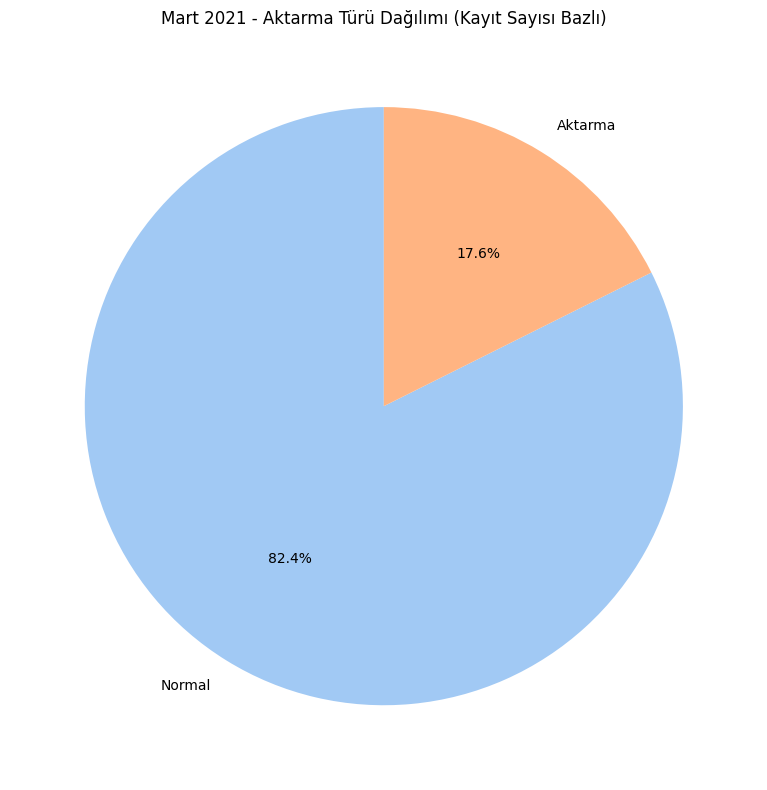

2025-05-21 19:54:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Aktarma Türü Dağılımı (Pie Chart) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Aktarma Türü Dağılımı (Pie Chart) oluşturuldu.



2025-05-21 19:54:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## 2. Bilet Türlerinin Genel Dağılımı (Mart 2021) ##


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## 2. Bilet Türlerinin Genel Dağılımı (Mart 2021) ##


2025-05-21 19:54:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- a. Bilet Türlerinin Dağılımı (Toplam Geçiş Sayısına Göre) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- a. Bilet Türlerinin Dağılımı (Toplam Geçiş Sayısına Göre) ---


En Yaygın Bilet Türleri (Toplam Geçiş Sayısına Göre - İlk 10):
product_kind
TAM                    61710698
INDIRIMLI1             37691686
UCRETSIZ               17559281
INDIRIMLI2              3547537
PERSONEL                 411351
DENETIM                    4624
KULLANILMAYAN_GRUBU        2165
Bilinmiyor                    1


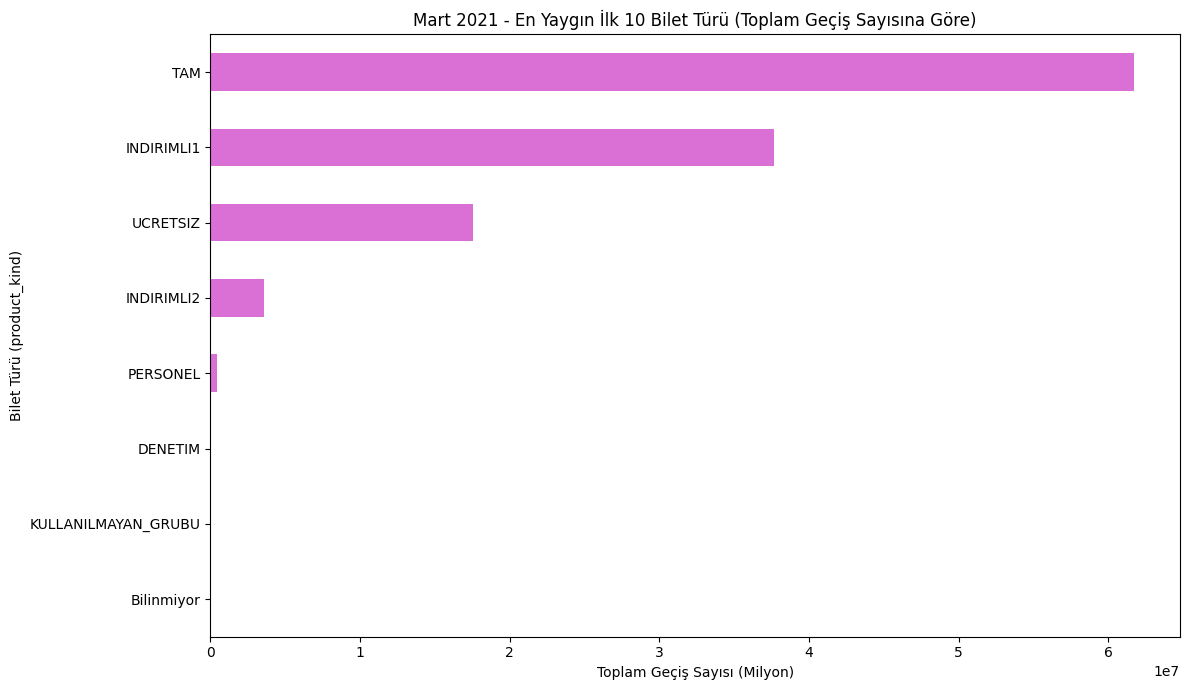

2025-05-21 19:54:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: En Yaygın Bilet Türleri (Geçiş Sayısına Göre) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: En Yaygın Bilet Türleri (Geçiş Sayısına Göre) oluşturuldu.



2025-05-21 19:54:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## 3. Ana Ulaşım Modlarına Göre Bilet Türü Dağılımı (Mart 2021) ##


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## 3. Ana Ulaşım Modlarına Göre Bilet Türü Dağılımı (Mart 2021) ##


2025-05-21 19:54:29 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
--- a. Ana Ulaşım Modları İçin En Yaygın Bilet Türlerinin Yüzdesel Dağılımı (Geçiş Sayısına Göre) ---


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
--- a. Ana Ulaşım Modları İçin En Yaygın Bilet Türlerinin Yüzdesel Dağılımı (Geçiş Sayısına Göre) ---


Ana Ulaşım Modlarına Göre Bilet Türü Dağılımı (Yüzdesel %):
product_kind            TAM  INDIRIMLI1  UCRETSIZ  INDIRIMLI2  PERSONEL  DENETIM
final_route_type_desc                                                           
0_Tramvay/LR           56.3        27.9      13.2         2.4       0.2      0.0
1_Metro/Marmaray       51.1        34.1      11.8         2.7       0.3      0.0
3_Otobus/Metrobus      49.9        30.5      16.2         3.1       0.4      0.0
4_Vapur                54.4        30.4      10.8         4.2       0.2      0.0


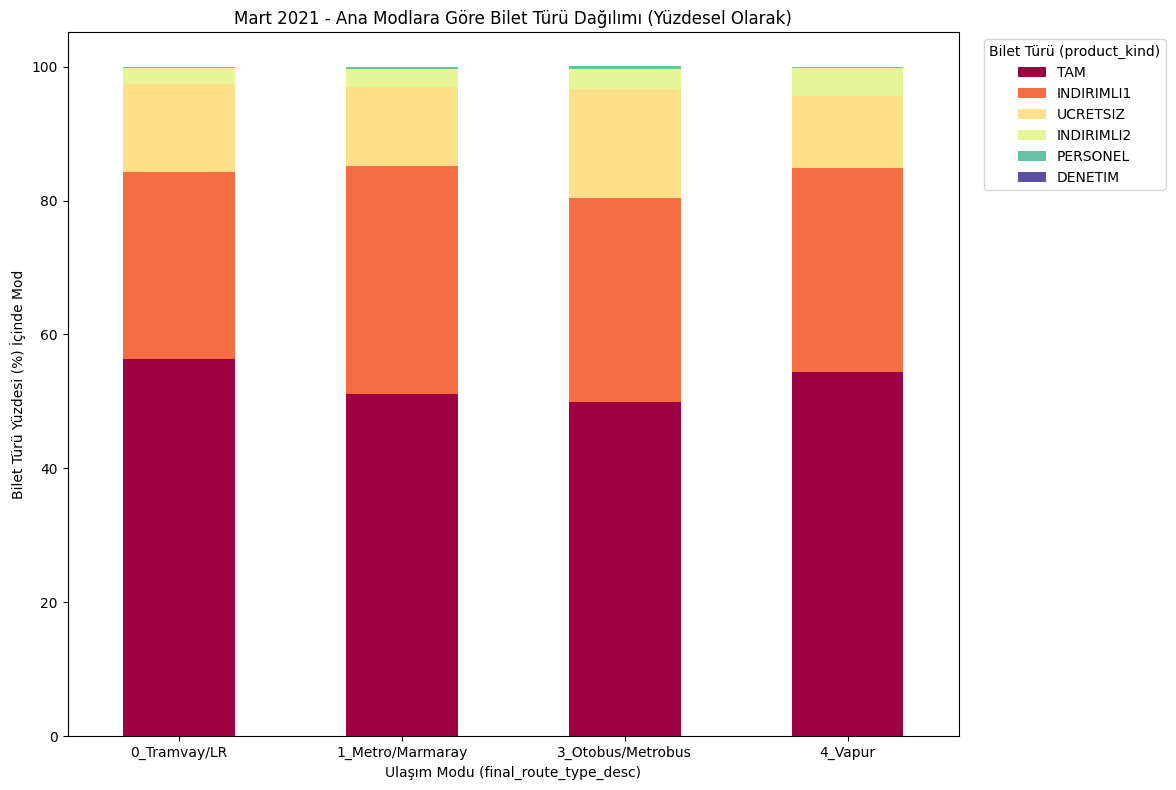

2025-05-21 19:54:33 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Ana Modlara Göre Bilet Türü Dağılımı (Yüzdesel) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Ana Modlara Göre Bilet Türü Dağılımı (Yüzdesel) oluşturuldu.



2025-05-21 19:54:33 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.2 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.2 TAMAMLANDI =====


In [12]:
# === Hücre 3.2: Aktarma ve Bilet Türü Analizleri ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 3.2 BAŞLATILIYOR: Aktarma ve Bilet Türü Analizleri =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_analysis_mart2021' not in locals() or df_analysis_mart2021 is None or df_analysis_mart2021.empty:
    logger.error("HATA: 'df_analysis_mart2021' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen Adım 1, Adım 2 (tüm alt hücreler) ve Hücre 3.0 ile 3.1'i başarıyla çalıştırdığınızdan emin olun.")
    error_in_eda_3_2 = True
else:
    error_in_eda_3_2 = False
    logger.info("'df_analysis_mart2021' DataFrame başarıyla bulundu. Analizlere devam ediliyor...")
    # Gerekli sütunların varlığını kontrol edelim
    required_cols_3_2 = ['transfer_type', 'product_kind', 'number_of_passage', 'final_route_type_desc']
    if not all(col in df_analysis_mart2021.columns for col in required_cols_3_2):
        logger.error(f"HATA: Bu analiz için gerekli sütunlardan biri veya birkaçı df_analysis_mart2021'de bulunmuyor. Eksik olabilecekler: {required_cols_3_2}")
        error_in_eda_3_2 = True

if not error_in_eda_3_2:
    # --- 1. Aktarma Türlerinin Genel Dağılımı ---
    logger.info("\n## 1. Aktarma Türlerinin Genel Dağılımı (Mart 2021) ##")
    logger.info("\n--- a. Aktarma Türlerinin Dağılımı (Kayıt Sayısına Göre Yüzdesel) ---")

    transfer_type_distribution = df_analysis_mart2021['transfer_type'].value_counts(normalize=True, dropna=False) * 100
    print("Aktarma Türü Dağılımı (Yüzdesel):")
    print(transfer_type_distribution.to_string())

    if not transfer_type_distribution.empty:
        plt.figure(figsize=(8, 8))
        transfer_type_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90,
                                        colors=sns.color_palette("pastel", len(transfer_type_distribution)))
        plt.title('Mart 2021 - Aktarma Türü Dağılımı (Kayıt Sayısı Bazlı)')
        plt.ylabel('') # y ekseni etiketini kaldır (pie chart için)
        plt.tight_layout()
        plt.show()
        logger.info("Grafik: Aktarma Türü Dağılımı (Pie Chart) oluşturuldu.\n")
    else:
        logger.info("Aktarma türü dağılımı için veri bulunamadı.\n")

    # --- 2. Bilet Türlerinin ('product_kind') Genel Dağılımı ---
    logger.info("\n## 2. Bilet Türlerinin Genel Dağılımı (Mart 2021) ##")
    logger.info("\n--- a. Bilet Türlerinin Dağılımı (Toplam Geçiş Sayısına Göre) ---")

    product_kind_passages = df_analysis_mart2021.groupby('product_kind')['number_of_passage'].sum().sort_values(ascending=False)
    print("En Yaygın Bilet Türleri (Toplam Geçiş Sayısına Göre - İlk 10):")
    print(product_kind_passages.head(10).to_string()) # İlk 10'u gösterelim

    if not product_kind_passages.empty:
        plt.figure(figsize=(12, 7))
        product_kind_passages.head(10).sort_values(ascending=True).plot(kind='barh', color='orchid')
        plt.title('Mart 2021 - En Yaygın İlk 10 Bilet Türü (Toplam Geçiş Sayısına Göre)')
        plt.xlabel('Toplam Geçiş Sayısı (Milyon)')
        plt.ylabel('Bilet Türü (product_kind)')
        plt.tight_layout()
        plt.show()
        logger.info("Grafik: En Yaygın Bilet Türleri (Geçiş Sayısına Göre) oluşturuldu.\n")
    else:
        logger.info("Bilet türü dağılımı için veri bulunamadı.\n")

    # --- 3. Ana Ulaşım Modlarına Göre Bilet Türü Dağılımı (Yüzdesel) ---
    logger.info("\n## 3. Ana Ulaşım Modlarına Göre Bilet Türü Dağılımı (Mart 2021) ##")
    logger.info("\n--- a. Ana Ulaşım Modları İçin En Yaygın Bilet Türlerinin Yüzdesel Dağılımı (Geçiş Sayısına Göre) ---")

    # Analizde kullanılacak ana modları ve en yaygın bilet türlerini belirleyelim
    # (Hücre 3.0'da tanımlanan main_modes_for_profile listesini kullanalım veya benzer bir liste)
    main_modes_for_ticket_analysis = ["3_Otobus/Metrobus", "1_Metro/Marmaray", "0_Tramvay/LR", "4_Vapur"]
    # En yaygın ilk 5-6 bilet türünü alalım, tablo çok büyümesin
    top_n_product_kinds = product_kind_passages.head(6).index.tolist()
    if 'Bilinmiyor' in top_n_product_kinds and len(product_kind_passages) > 6: # Eğer "Bilinmiyor" ilk 6'da ise ve daha fazla bilet türü varsa, ilk 7'yi alıp "Bilinmiyor"u çıkarabiliriz.
        top_n_product_kinds = product_kind_passages.head(7).index.tolist()
        if 'Bilinmiyor' in top_n_product_kinds: top_n_product_kinds.remove('Bilinmiyor')
        top_n_product_kinds = top_n_product_kinds[:6] # Tekrar ilk 6'yı al


    df_filtered_for_crosstab = df_analysis_mart2021[
        df_analysis_mart2021['final_route_type_desc'].isin(main_modes_for_ticket_analysis) &
        df_analysis_mart2021['product_kind'].isin(top_n_product_kinds)
    ]

    if not df_filtered_for_crosstab.empty:
        crosstab_mode_ticket_percentage = pd.crosstab(
            index=df_filtered_for_crosstab['final_route_type_desc'],
            columns=df_filtered_for_crosstab['product_kind'],
            values=df_filtered_for_crosstab['number_of_passage'],
            aggfunc='sum',
            normalize='index' # Her mod içinde yüzdesel dağılım
        ).mul(100).round(1) # Yüzde olarak göster ve 1 ondalık basamağa yuvarla

        # Sütunları (bilet türleri) genel yaygınlıklarına göre sıralayalım (top_n_product_kinds sırası)
        # Crosstab sonucu oluşan sütunlar top_n_product_kinds'ta olmayabilir, olanları alalım.
        ordered_cols_for_crosstab = [col for col in top_n_product_kinds if col in crosstab_mode_ticket_percentage.columns]
        crosstab_mode_ticket_percentage = crosstab_mode_ticket_percentage[ordered_cols_for_crosstab]

        print("Ana Ulaşım Modlarına Göre Bilet Türü Dağılımı (Yüzdesel %):")
        print(crosstab_mode_ticket_percentage.to_string())

        if not crosstab_mode_ticket_percentage.empty:
            crosstab_mode_ticket_percentage.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Spectral', rot=0)
            plt.title('Mart 2021 - Ana Modlara Göre Bilet Türü Dağılımı (Yüzdesel Olarak)')
            plt.xlabel('Ulaşım Modu (final_route_type_desc)')
            plt.ylabel('Bilet Türü Yüzdesi (%) İçinde Mod')
            plt.legend(title='Bilet Türü (product_kind)', bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Legend'a yer açmak için
            plt.show()
            logger.info("Grafik: Ana Modlara Göre Bilet Türü Dağılımı (Yüzdesel) oluşturuldu.\n")
    else:
        logger.warning("Ana modlar ve bilet türleri için filtrelenmiş veri boş. Mod-Bilet Türü çapraz tablo analizi atlanıyor.")

    logger.info("===== HÜCRE 3.2 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame veya sütunlar eksik olduğu için Hücre 3.2 (Aktarma ve Bilet Türü Analizleri) çalıştırılamadı.")

In [13]:
# === Hücre 3.3: Pik Saat Yoğunluk ve Frekans Analizi ===

import pandas as pd
import numpy as np
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 3.3 BAŞLATILIYOR: Pik Saat Yoğunluk ve Frekans Analizi =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_analysis_mart2021' not in locals() or df_analysis_mart2021 is None or df_analysis_mart2021.empty:
    logger.error("HATA: 'df_analysis_mart2021' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen önceki tüm EDA hücrelerini (3.0, 3.1, 3.2) başarıyla çalıştırdığınızdan emin olun.")
    error_in_eda_3_3 = True
else:
    error_in_eda_3_3 = False
    logger.info("'df_analysis_mart2021' DataFrame başarıyla bulundu. Pik saat analizlerine devam ediliyor...")
    # Gerekli sütunların varlığını kontrol et
    required_cols_3_3 = ['display_route_name_eda', 'number_of_passage', 'transition_hour', 'gtfs_headway_secs', 'final_route_type_desc']
    if not all(col in df_analysis_mart2021.columns for col in required_cols_3_3):
        logger.error(f"HATA: Bu analiz için gerekli sütunlardan biri veya birkaçı df_analysis_mart2021'de bulunmuyor. Eksik olabilecekler: {required_cols_3_3}")
        error_in_eda_3_3 = True

if not error_in_eda_3_3:
    # --- 1. En Yoğun Hatların Belirlenmesi (Tekrar, ilk N hat için) ---
    # (Hücre 3.1'de zaten yapılmıştı, oradan en yoğun hatları alabilir veya burada tekrar hesaplayabiliriz)
    # Burada ilk 10 hattı alalım.
    top_n_for_peak_analysis = 10
    if 'display_route_name_eda' in df_analysis_mart2021.columns:
        top_lines_for_peak = df_analysis_mart2021.groupby('display_route_name_eda')['number_of_passage'].sum().nlargest(top_n_for_peak_analysis).index.tolist()
        logger.info(f"Analiz için en yoğun ilk {top_n_for_peak_analysis} hat belirlendi: {top_lines_for_peak}")
    else:
        logger.error("Pik saat analizi için 'display_route_name_eda' sütunu bulunamadı. Analiz durduruluyor.")
        top_lines_for_peak = [] # Hata durumunda boş liste

    if top_lines_for_peak:
        logger.info("\n## En Yoğun Hatların Pik Saat / Ortalama Saat Yoğunluk ve Frekans Analizleri ##\n")

        # Pik saatleri tanımlayalım (sabah ve akşam)
        morning_peak_hours = [7, 8] # Örnek: 07:00-08:59 arası
        evening_peak_hours = [17, 18] # Örnek: 17:00-18:59 arası
        logger.info(f"Pik Saat Tanımları: Sabah={morning_peak_hours}, Akşam={evening_peak_hours}")

        results_peak_analysis = []

        for line_name in top_lines_for_peak:
            df_line_subset = df_analysis_mart2021[df_analysis_mart2021['display_route_name_eda'] == line_name]
            if df_line_subset.empty:
                logger.warning(f"'{line_name}' için df_analysis_mart2021'de veri bulunamadı, atlanıyor.")
                continue

            # a. Saatlik Geçiş Sayıları
            hourly_passages_on_line = df_line_subset.groupby('transition_hour')['number_of_passage'].sum()
            if hourly_passages_on_line.empty:
                logger.warning(f"'{line_name}' için saatlik geçiş verisi bulunamadı, atlanıyor.")
                continue

            total_passages_line = hourly_passages_on_line.sum()
            overall_avg_hourly_passages = hourly_passages_on_line.mean() # Tüm gün için ortalama saatlik geçiş
            max_hourly_passage_count = hourly_passages_on_line.max()
            max_hour = hourly_passages_on_line.idxmax()

            # b. Pik Saat Yoğunlukları
            morning_peak_total_passages = hourly_passages_on_line[hourly_passages_on_line.index.isin(morning_peak_hours)].sum()
            evening_peak_total_passages = hourly_passages_on_line[hourly_passages_on_line.index.isin(evening_peak_hours)].sum()

            # Ortalama pik saat yoğunluğu (saat başına)
            avg_morning_peak_hourly = morning_peak_total_passages / len(morning_peak_hours) if len(morning_peak_hours) > 0 else 0
            avg_evening_peak_hourly = evening_peak_total_passages / len(evening_peak_hours) if len(evening_peak_hours) > 0 else 0

            peak_to_avg_ratio = max_hourly_passage_count / overall_avg_hourly_passages if overall_avg_hourly_passages > 0 else 0
            morning_peak_ratio = avg_morning_peak_hourly / overall_avg_hourly_passages if overall_avg_hourly_passages > 0 else 0
            evening_peak_ratio = avg_evening_peak_hourly / overall_avg_hourly_passages if overall_avg_hourly_passages > 0 else 0

            # c. Frekans Bilgisi (Eğer Varsa) ve Sefer Başına Düşen Yolcu
            avg_headway_secs_line = pd.NA
            avg_headway_mins_line = pd.NA
            passages_per_trip_peak_morning = pd.NA
            passages_per_trip_peak_evening = pd.NA

            # Hattın genel ortalama headway'ini alalım (eğer birden fazla varsa)
            # Sadece bu hatta ait ve headway bilgisi olan satırları al
            line_with_headway = df_line_subset[df_line_subset['gtfs_headway_secs'].notna()]
            if not line_with_headway.empty:
                # Bir hat için birden fazla headway tanımı olabilir (farklı zamanlar/tripler için).
                # En sık kullanılanı veya ortalamasını alabiliriz. Şimdilik ortalamasını alalım.
                avg_headway_secs_line = line_with_headway['gtfs_headway_secs'].mean()
                if pd.notna(avg_headway_secs_line):
                    avg_headway_mins_line = avg_headway_secs_line / 60

                    # Pik saatlerde sefer başına düşen yolcu (tahmini)
                    # Bu hesaplama için pik saatlerdeki ortalama headway'i bulmak daha doğru olurdu.
                    # Şimdilik hattın genel ortalama headway'ini kullanalım.
                    # Bu bir basitleştirme, daha sonra detaylandırılabilir.

                    # Sabah pik saatlerindeki headway'i bulalım
                    morning_peak_headways = line_with_headway[
                        line_with_headway['transition_hour'].isin(morning_peak_hours)
                    ]['gtfs_headway_secs'].mean()
                    if pd.notna(morning_peak_headways) and morning_peak_headways > 0:
                        num_trips_morning_peak_per_hour = 3600 / morning_peak_headways
                        num_trips_total_morning_peak = num_trips_morning_peak_per_hour * len(morning_peak_hours)
                        if num_trips_total_morning_peak > 0:
                             passages_per_trip_peak_morning = morning_peak_total_passages / num_trips_total_morning_peak

                    # Akşam pik saatlerindeki headway'i bulalım
                    evening_peak_headways = line_with_headway[
                        line_with_headway['transition_hour'].isin(evening_peak_hours)
                    ]['gtfs_headway_secs'].mean()
                    if pd.notna(evening_peak_headways) and evening_peak_headways > 0:
                        num_trips_evening_peak_per_hour = 3600 / evening_peak_headways
                        num_trips_total_evening_peak = num_trips_evening_peak_per_hour * len(evening_peak_hours)
                        if num_trips_total_evening_peak > 0:
                            passages_per_trip_peak_evening = evening_peak_total_passages / num_trips_total_evening_peak

            results_peak_analysis.append({
                "Hat Adı": line_name,
                "Toplam Geçiş": total_passages_line,
                "En Yoğun Saat": f"{max_hour:02d}:00 ({max_hourly_passage_count:,.0f} geçiş)",
                "Ort. Saatlik Geçiş": f"{overall_avg_hourly_passages:,.0f}",
                "Pik/Ort. Oranı": f"{peak_to_avg_ratio:.2f}",
                "Sabah Pik Ort. Geçiş": f"{avg_morning_peak_hourly:,.0f} (Ort. {morning_peak_ratio:.2f} katı)",
                "Akşam Pik Ort. Geçiş": f"{avg_evening_peak_hourly:,.0f} (Ort. {evening_peak_ratio:.2f} katı)",
                "Ort. Headway (dk)": f"{avg_headway_mins_line:.1f}" if pd.notna(avg_headway_mins_line) else "Bilgi Yok",
                "Sabah Pik Sefer Başı Yolcu (Tahmini)": f"{passages_per_trip_peak_morning:.0f}" if pd.notna(passages_per_trip_peak_morning) else "Hesaplanamadı",
                "Akşam Pik Sefer Başı Yolcu (Tahmini)": f"{passages_per_trip_peak_evening:.0f}" if pd.notna(passages_per_trip_peak_evening) else "Hesaplanamadı"
            })

        if results_peak_analysis:
            df_peak_results = pd.DataFrame(results_peak_analysis)
            print(df_peak_results.to_string())
        else:
            logger.info("Pik saat analizi için sonuç üretilemedi.")

    logger.info("\n===== HÜCRE 3.3 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame veya sütunlar eksik olduğu için Hücre 3.3 (Pik Saat Analizi) çalıştırılamadı.")

2025-05-21 19:56:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3 BAŞLATILIYOR: Pik Saat Yoğunluk ve Frekans Analizi =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3 BAŞLATILIYOR: Pik Saat Yoğunluk ve Frekans Analizi =====


2025-05-21 19:56:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' DataFrame başarıyla bulundu. Pik saat analizlerine devam ediliyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' DataFrame başarıyla bulundu. Pik saat analizlerine devam ediliyor...


2025-05-21 19:56:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Analiz için en yoğun ilk 10 hat belirlendi: ['ZİNCİRLİKUYU - AVCILAR MRK.ÜNV.KMP.', 'GEBZE-HALKALI', 'BAĞCILAR - KABATAŞ', 'YENİKAPI - HACIOSMAN', 'YENİKAPI - KİRAZLI', 'ÜSKÜDAR - ÇEKMEKÖY', 'KADIKÖY - TAVŞANTEPE', 'TOPKAPI - MESCİD-İ SELAM', 'YILDIZ - MAHMUTBEY', 'SÖĞÜTLÜÇEŞME - CEVİZLİBAĞ']


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Analiz için en yoğun ilk 10 hat belirlendi: ['ZİNCİRLİKUYU - AVCILAR MRK.ÜNV.KMP.', 'GEBZE-HALKALI', 'BAĞCILAR - KABATAŞ', 'YENİKAPI - HACIOSMAN', 'YENİKAPI - KİRAZLI', 'ÜSKÜDAR - ÇEKMEKÖY', 'KADIKÖY - TAVŞANTEPE', 'TOPKAPI - MESCİD-İ SELAM', 'YILDIZ - MAHMUTBEY', 'SÖĞÜTLÜÇEŞME - CEVİZLİBAĞ']


2025-05-21 19:56:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 
## En Yoğun Hatların Pik Saat / Ortalama Saat Yoğunluk ve Frekans Analizleri ##



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
## En Yoğun Hatların Pik Saat / Ortalama Saat Yoğunluk ve Frekans Analizleri ##



2025-05-21 19:56:23 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Pik Saat Tanımları: Sabah=[7, 8], Akşam=[17, 18]


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Pik Saat Tanımları: Sabah=[7, 8], Akşam=[17, 18]


                               Hat Adı  Toplam Geçiş            En Yoğun Saat Ort. Saatlik Geçiş Pik/Ort. Oranı        Sabah Pik Ort. Geçiş        Akşam Pik Ort. Geçiş Ort. Headway (dk) Sabah Pik Sefer Başı Yolcu (Tahmini) Akşam Pik Sefer Başı Yolcu (Tahmini)
0  ZİNCİRLİKUYU - AVCILAR MRK.ÜNV.KMP.      13914237  18:00 (1,454,767 geçiş)            579,760           2.51  1,190,670 (Ort. 2.05 katı)  1,333,112 (Ort. 2.30 katı)         Bilgi Yok                        Hesaplanamadı                        Hesaplanamadı
1                        GEBZE-HALKALI       8044421    18:00 (824,536 geçiş)            349,757           2.36    619,264 (Ort. 1.77 katı)    793,508 (Ort. 2.27 katı)              15.0                               154816                               198377
2                   BAĞCILAR - KABATAŞ       7955103    18:00 (680,787 geçiş)            361,596           1.88    560,273 (Ort. 1.55 katı)    655,669 (Ort. 1.81 katı)         Bilgi Yok                        Hesaplanama

INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:
===== HÜCRE 3.3 TAMAMLANDI =====


2025-05-21 20:00:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3.1 BAŞLATILIYOR: Pik Saat Yoğunluk Oranları Grafiği (Geliştirilmiş) =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3.1 BAŞLATILIYOR: Pik Saat Yoğunluk Oranları Grafiği (Geliştirilmiş) =====


2025-05-21 20:00:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_peak_results' DataFrame başarıyla bulundu. Geliştirilmiş grafik oluşturuluyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_peak_results' DataFrame başarıyla bulundu. Geliştirilmiş grafik oluşturuluyor...


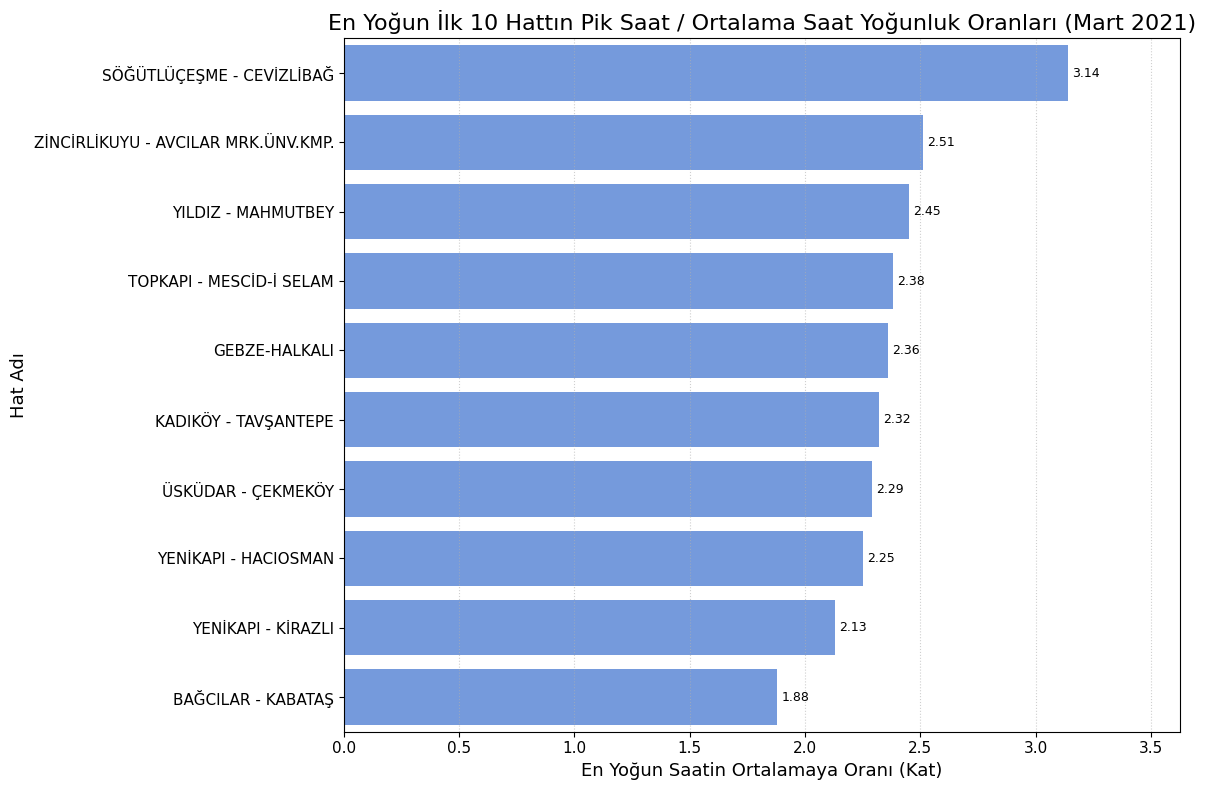

2025-05-21 20:00:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: En Yoğun Hatların Pik Saat / Ortalama Saat Yoğunluk Oranları (Geliştirilmiş) oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: En Yoğun Hatların Pik Saat / Ortalama Saat Yoğunluk Oranları (Geliştirilmiş) oluşturuldu.



2025-05-21 20:00:06 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3.1 (Geliştirilmiş Grafik) TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3.1 (Geliştirilmiş Grafik) TAMAMLANDI =====


In [15]:
# === Hücre 3.3.1: Pik Saat Yoğunluk Oranları Grafiği (Geliştirilmiş) ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 3.3.1 BAŞLATILIYOR: Pik Saat Yoğunluk Oranları Grafiği (Geliştirilmiş) =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_peak_results' not in locals() or df_peak_results is None or df_peak_results.empty:
    logger.error("HATA: 'df_peak_results' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen Hücre 3.3'ü (Pik Saat Yoğunluk ve Frekans Analizi) başarıyla çalıştırdığınızdan emin olun.")
    error_in_plotting_3_3_1_v2 = True
else:
    error_in_plotting_3_3_1_v2 = False
    logger.info("'df_peak_results' DataFrame başarıyla bulundu. Geliştirilmiş grafik oluşturuluyor...")

if not error_in_plotting_3_3_1_v2:
    df_plot_v2 = df_peak_results.copy()

    if 'Pik/Ort. Oranı' in df_plot_v2.columns:
        df_plot_v2['Pik/Ort. Oranı Numerik'] = pd.to_numeric(df_plot_v2['Pik/Ort. Oranı'], errors='coerce')

        # Orana göre AZALAN sırada sırala (en yüksek oran en üstte)
        df_plot_sorted_v2 = df_plot_v2.sort_values(by='Pik/Ort. Oranı Numerik', ascending=False)

        plt.figure(figsize=(12, 8))
        barplot_v2 = sns.barplot(
            x='Pik/Ort. Oranı Numerik', # X eksenine sayısal değer
            y='Hat Adı',                # Y eksenine kategori (Hat Adı)
            data=df_plot_sorted_v2,     # Sıralanmış veriyi kullan
            color='cornflowerblue'      # Tek, hoş bir renk
            # Alternatif olarak sıralı bir palet: palette='mako_r' (koyudan açığa)
        )

        # Barların üzerine değerlerini yazdırma (enumerate ile doğru y pozisyonu)
        for i, (idx, row) in enumerate(df_plot_sorted_v2.iterrows()): # idx DataFrame'in orijinal index'i, i ise barın sırası (0'dan başlar)
            value = row['Pik/Ort. Oranı Numerik']
            if pd.notna(value):
                # Değerin barın ucunun biraz sağına yazılması için küçük bir ofset
                # Ofseti barın genişliğine göre dinamik yapmak yerine sabit bir ofset deneyelim
                # Veya barın kendi değerinin küçük bir yüzdesi kadar ofset
                x_offset = 0.02 # X eksenindeki değere göre küçük bir ofset
                barplot_v2.text(value + x_offset,  # x pozisyonu
                             i,                 # y pozisyonu (barın indeksi)
                             f"{value:.2f}",    # Gösterilecek metin
                             color='black',
                             ha="left",       # Yatayda sola hizalı (değerin sağına)
                             va="center",     # Dikeyde ortaya hizalı
                             fontsize=9)

        plt.title('En Yoğun İlk 10 Hattın Pik Saat / Ortalama Saat Yoğunluk Oranları (Mart 2021)', fontsize=16)
        plt.xlabel('En Yoğun Saatin Ortalamaya Oranı (Kat)', fontsize=13)
        plt.ylabel('Hat Adı', fontsize=13)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11) # Hat isimlerinin okunurluğu için
        plt.grid(axis='x', linestyle=':', alpha=0.6) # X eksenine daha belirgin olmayan bir ızgara

        # X ekseni limitini biraz genişletelim ki değerler tam sığsın
        current_xlim = plt.xlim()
        plt.xlim(current_xlim[0], current_xlim[1] * 1.1) # %10 daha fazla alan sağa doğru

        plt.tight_layout()
        plt.show()
        logger.info("Grafik: En Yoğun Hatların Pik Saat / Ortalama Saat Yoğunluk Oranları (Geliştirilmiş) oluşturuldu.\n")
    else:
        logger.error("'Pik/Ort. Oranı' sütunu df_peak_results içinde bulunamadı. Grafik oluşturulamıyor.")

    logger.info("===== HÜCRE 3.3.1 (Geliştirilmiş Grafik) TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame eksik olduğu için Hücre 3.3.1 (Geliştirilmiş Grafik) çalıştırılamadı.")

2025-05-21 20:05:19 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3.2 BAŞLATILIYOR: Yoğunluk - Frekans İlişkisi Saçılım Grafiği =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3.2 BAŞLATILIYOR: Yoğunluk - Frekans İlişkisi Saçılım Grafiği =====


2025-05-21 20:05:19 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_analysis_mart2021' DataFrame başarıyla bulundu. Saçılım grafiği için veri hazırlanıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_analysis_mart2021' DataFrame başarıyla bulundu. Saçılım grafiği için veri hazırlanıyor...


2025-05-21 20:05:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Frekans bilgisi olan 802,442 kayıt bulundu.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Frekans bilgisi olan 802,442 kayıt bulundu.


2025-05-21 20:05:30 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Saçılım grafiği için 20 hat verisi hazırlandı.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Saçılım grafiği için 20 hat verisi hazırlandı.



Saçılım Grafiği Verisi (İlk 10 Satır):
                                       Hat Adı  Toplam_Geçiş Ort_Headway_dk        Ulaşım_Modu  Pik_Ort_Orani
6                                GEBZE-HALKALI       8021554           15.0   1_Metro/Marmaray       2.357451
14                          YILDIZ - MAHMUTBEY       2485745        6.30673   1_Metro/Marmaray       2.451102
12     MEHMETÇİK SOKAK - EMİNÖNÜ MISIR ÇARŞISI        271018      22.681135  3_Otobus/Metrobus       2.075879
15                         ÇENGELKÖY - İSTİNYE        230924     155.678457            4_Vapur       2.109915
16                             ÜSKÜDAR-EMİNÖNÜ        220032       20.45846            4_Vapur       2.352281
13                          NİŞANGAH - EMİNÖNÜ        183896      22.287647  3_Otobus/Metrobus       2.171290
9                            KARAKÖY - BEYOĞLU        162991            7.0        7_Funikuler       1.687810
2               AYDINLI TOKİ PERONLAR - KARTAL        161204       9.063792  3_O

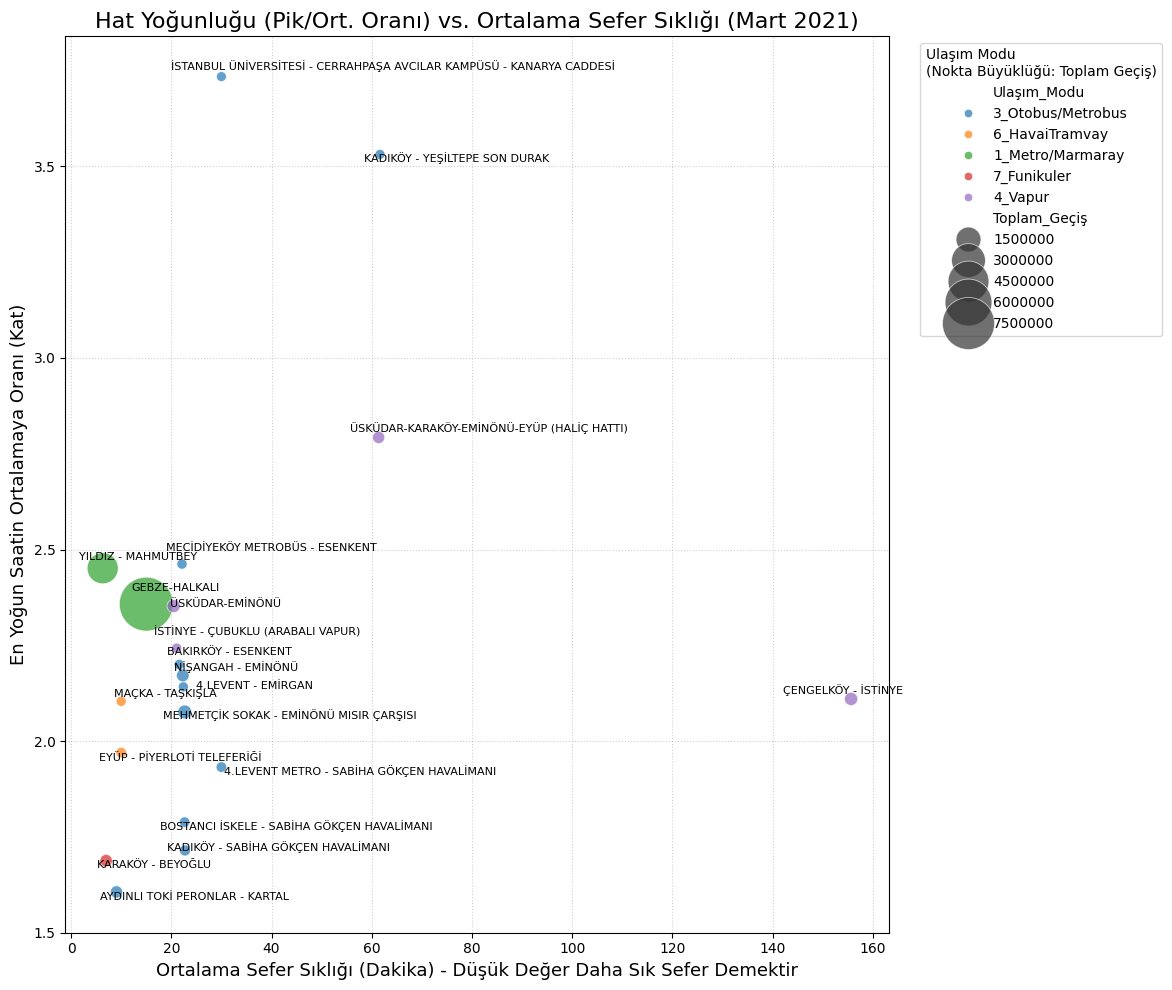

2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Yoğunluk - Frekans İlişkisi Saçılım Grafiği oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Yoğunluk - Frekans İlişkisi Saçılım Grafiği oluşturuldu.



2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik Yorumlama İpuçları:


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik Yorumlama İpuçları:


2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - - Sağ Alt (Düşük Headway, Yüksek Pik Oranı): Sık sefer ama piklerde çok yoğun hatlar.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:- Sağ Alt (Düşük Headway, Yüksek Pik Oranı): Sık sefer ama piklerde çok yoğun hatlar.


2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - - Sol Üst (Yüksek Headway, Düşük Pik Oranı): Seyrek sefer, piklerde de çok yoğun olmayan hatlar.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:- Sol Üst (Yüksek Headway, Düşük Pik Oranı): Seyrek sefer, piklerde de çok yoğun olmayan hatlar.


2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - - Sağ Üst (Düşük Headway, Düşük Pik Oranı): Sık sefer, piklerde de çok yoğun olmayan hatlar (iyi durumda olabilir).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:- Sağ Üst (Düşük Headway, Düşük Pik Oranı): Sık sefer, piklerde de çok yoğun olmayan hatlar (iyi durumda olabilir).


2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - - Sol Alt (Yüksek Headway, Yüksek Pik Oranı): Seyrek sefer ve piklerde çok yoğun hatlar (FREKANS ARTIRIMI ADAYI!).


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:- Sol Alt (Yüksek Headway, Yüksek Pik Oranı): Seyrek sefer ve piklerde çok yoğun hatlar (FREKANS ARTIRIMI ADAYI!).


2025-05-21 20:05:31 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3.2 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3.2 TAMAMLANDI =====


In [18]:
# === Hücre 3.3.2: Yoğunluk - Frekans İlişkisi Saçılım Grafiği ===
# adjustText kütüphanesini yükleyelim (grafikte metinlerin çakışmasını engellemek için)
!pip install adjustText

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from adjustText import adjust_text # Metinlerin üst üste binmesini engellemek için

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 3.3.2 BAŞLATILIYOR: Yoğunluk - Frekans İlişkisi Saçılım Grafiği =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_analysis_mart2021' not in locals() or df_analysis_mart2021 is None or df_analysis_mart2021.empty:
    logger.error("HATA: 'df_analysis_mart2021' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen önceki tüm EDA hücrelerini (3.0, 3.1, 3.2) başarıyla çalıştırdığınızdan emin olun.")
    error_in_eda_3_3_2 = True
else:
    error_in_eda_3_3_2 = False
    logger.info("'df_analysis_mart2021' DataFrame başarıyla bulundu. Saçılım grafiği için veri hazırlanıyor...")

if not error_in_eda_3_3_2:
    # Sadece frekans bilgisi olan kayıtları al
    df_with_freq = df_analysis_mart2021[df_analysis_mart2021['gtfs_headway_secs'].notna()].copy()

    if df_with_freq.empty:
        logger.warning("Frekans bilgisi ('gtfs_headway_secs') olan hiçbir kayıt bulunamadı. Saçılım grafiği oluşturulamıyor.")
    else:
        logger.info(f"Frekans bilgisi olan {len(df_with_freq):,} kayıt bulundu.")

        # Her hat (display_route_name_eda) için gerekli metrikleri hesapla
        # 1. Toplam Geçiş
        # 2. Ortalama Headway (Dakika)
        # 3. Pik Saat / Ortalama Saat Yoğunluk Oranı
        # 4. Ulaşım Modu (final_route_type_desc)

        # Ortalama Headway
        df_with_freq['gtfs_headway_mins'] = df_with_freq['gtfs_headway_secs'] / 60
        line_agg_freq = df_with_freq.groupby('display_route_name_eda').agg(
            Toplam_Geçiş=('number_of_passage', 'sum'),
            Ort_Headway_dk=('gtfs_headway_mins', 'mean'),
            Ulaşım_Modu=('final_route_type_desc', 'first') # Her hattın tek bir modu olmalı
        ).reset_index()

        line_agg_freq.rename(columns={'display_route_name_eda': 'Hat Adı'}, inplace=True)

        # Pik Saat / Ortalama Saat Yoğunluk Oranını Hesapla
        peak_ratios_for_scatter = []
        for line_name in line_agg_freq['Hat Adı']:
            df_line_subset_scatter = df_analysis_mart2021[df_analysis_mart2021['display_route_name_eda'] == line_name]
            hourly_passages_scatter = df_line_subset_scatter.groupby('transition_hour')['number_of_passage'].sum()

            if hourly_passages_scatter.empty or hourly_passages_scatter.sum() == 0:
                peak_ratios_for_scatter.append(np.nan)
                continue

            overall_avg_hourly_scatter = hourly_passages_scatter.mean()
            max_hourly_passage_scatter = hourly_passages_scatter.max()
            ratio = max_hourly_passage_scatter / overall_avg_hourly_scatter if overall_avg_hourly_scatter > 0 else 0
            peak_ratios_for_scatter.append(ratio)

        line_agg_freq['Pik_Ort_Orani'] = peak_ratios_for_scatter

        # Analiz için NaN değerleri olan satırları çıkaralım
        df_scatter_plot_final = line_agg_freq.dropna(subset=['Ort_Headway_dk', 'Pik_Ort_Orani', 'Toplam_Geçiş'])

        if df_scatter_plot_final.empty:
            logger.warning("Saçılım grafiği için yeterli veri bulunamadı (hesaplamalar sonrası).")
        else:
            logger.info(f"Saçılım grafiği için {len(df_scatter_plot_final)} hat verisi hazırlandı.")
            print("\nSaçılım Grafiği Verisi (İlk 10 Satır):")
            print(df_scatter_plot_final.sort_values(by='Toplam_Geçiş', ascending=False).head(10).to_string())

            plt.figure(figsize=(14, 10))
            scatter_plot = sns.scatterplot(
                data=df_scatter_plot_final,
                x='Ort_Headway_dk',
                y='Pik_Ort_Orani',
                size='Toplam_Geçiş',
                hue='Ulaşım_Modu',
                sizes=(50, 1500), # Nokta boyut aralığı
                alpha=0.7,
                palette='tab10' # Farklı bir renk paleti
            )

            plt.title('Hat Yoğunluğu (Pik/Ort. Oranı) vs. Ortalama Sefer Sıklığı (Mart 2021)', fontsize=16)
            plt.xlabel('Ortalama Sefer Sıklığı (Dakika) - Düşük Değer Daha Sık Sefer Demektir', fontsize=13)
            plt.ylabel('En Yoğun Saatin Ortalamaya Oranı (Kat)', fontsize=13)
            plt.grid(True, linestyle=':', alpha=0.6)

            # Efsaneyi grafik dışına taşıma
            plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', title='Ulaşım Modu\n(Nokta Büyüklüğü: Toplam Geçiş)')

            # Her noktaya Hat Adı etiketi ekleme (adjustText ile)
            texts = []
            for i in range(df_scatter_plot_final.shape[0]):
                texts.append(plt.text(df_scatter_plot_final['Ort_Headway_dk'].iloc[i] + 0.5, # X pozisyonuna küçük ofset
                                      df_scatter_plot_final['Pik_Ort_Orani'].iloc[i],
                                      df_scatter_plot_final['Hat Adı'].iloc[i], fontsize=8))

            adjust_text(texts,
                        #arrowprops=dict(arrowstyle='-', color='gray', lw=0.5) # Okları kapatmak için None veya yorum satırı
                       )

            # X eksenini ters çevirebiliriz (daha düşük headway = daha sık = sağda) veya böyle bırakabiliriz.
            # Genellikle düşük headway iyi olduğu için solda olması standarttır.
            # plt.gca().invert_xaxis() # Eğer istenirse açılabilir

            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Legend'a yer açmak için
            plt.show()
            logger.info("Grafik: Yoğunluk - Frekans İlişkisi Saçılım Grafiği oluşturuldu.\n")

            logger.info("Grafik Yorumlama İpuçları:")
            logger.info("- Sağ Alt (Düşük Headway, Yüksek Pik Oranı): Sık sefer ama piklerde çok yoğun hatlar.")
            logger.info("- Sol Üst (Yüksek Headway, Düşük Pik Oranı): Seyrek sefer, piklerde de çok yoğun olmayan hatlar.")
            logger.info("- Sağ Üst (Düşük Headway, Düşük Pik Oranı): Sık sefer, piklerde de çok yoğun olmayan hatlar (iyi durumda olabilir).")
            logger.info("- Sol Alt (Yüksek Headway, Yüksek Pik Oranı): Seyrek sefer ve piklerde çok yoğun hatlar (FREKANS ARTIRIMI ADAYI!).")


    logger.info("===== HÜCRE 3.3.2 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame eksik olduğu için Hücre 3.3.2 çalıştırılamadı.")

2025-05-21 20:09:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3.3 BAŞLATILIYOR: Pik Saatlerde Sefer Başına Düşen Yolcu Sayısı Grafiği =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3.3 BAŞLATILIYOR: Pik Saatlerde Sefer Başına Düşen Yolcu Sayısı Grafiği =====


2025-05-21 20:09:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 'df_peak_results' DataFrame başarıyla bulundu. Grafik için veri hazırlanıyor...


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:'df_peak_results' DataFrame başarıyla bulundu. Grafik için veri hazırlanıyor...


2025-05-21 20:09:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - 2 hat için 'Sefer Başına Düşen Yolcu (Tahmini)' verisi bulundu ve grafiğe dökülecek.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:2 hat için 'Sefer Başına Düşen Yolcu (Tahmini)' verisi bulundu ve grafiğe dökülecek.



Pik Saatlerde Sefer Başına Düşen Yolcu Verisi (Grafik İçin):
              Hat Adı  Sabah_PPT_Numerik  Akşam_PPT_Numerik
1       GEBZE-HALKALI           154816.0           198377.0
8  YILDIZ - MAHMUTBEY            25707.0            25621.0


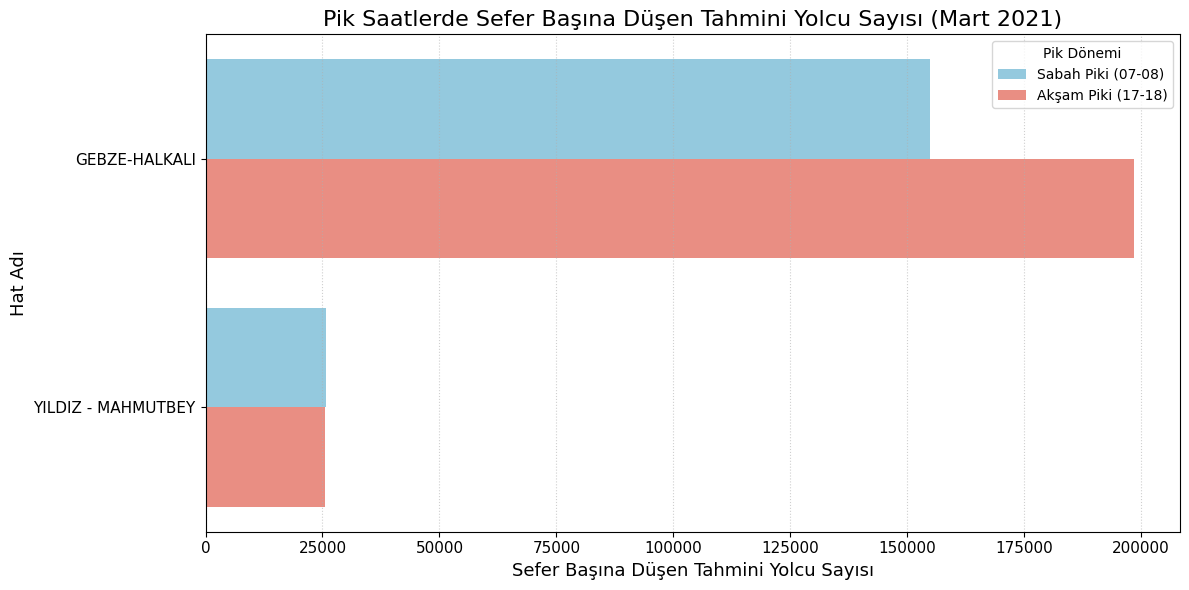

2025-05-21 20:09:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - Grafik: Pik Saatlerde Sefer Başına Düşen Tahmini Yolcu Sayısı oluşturuldu.



INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:Grafik: Pik Saatlerde Sefer Başına Düşen Tahmini Yolcu Sayısı oluşturuldu.



2025-05-21 20:09:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - YORUM NOTU: Bu grafikteki değerler, bir aracın içindeki anlık yolcu sayısını değil, bir seferin o pik periyotta hattaki toplam binişlere ne kadar katkı sağladığını gösteren bir endekstir. Yüksek değerler, her bir seferin yüksek bir yolcu talebini karşıladığını gösterir.


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:YORUM NOTU: Bu grafikteki değerler, bir aracın içindeki anlık yolcu sayısını değil, bir seferin o pik periyotta hattaki toplam binişlere ne kadar katkı sağladığını gösteren bir endekstir. Yüksek değerler, her bir seferin yüksek bir yolcu talebini karşıladığını gösterir.


2025-05-21 20:09:20 - IBB_TopluTasima_Projesi_Yeni_Oturum - INFO - ===== HÜCRE 3.3.3 TAMAMLANDI =====


INFO:IBB_TopluTasima_Projesi_Yeni_Oturum:===== HÜCRE 3.3.3 TAMAMLANDI =====


In [19]:
# === Hücre 3.3.3: Pik Saatlerde Sefer Başına Düşen Yolcu Sayısı Grafiği ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging

logger = logging.getLogger('IBB_TopluTasima_Projesi_Yeni_Oturum')
logger.info("===== HÜCRE 3.3.3 BAŞLATILIYOR: Pik Saatlerde Sefer Başına Düşen Yolcu Sayısı Grafiği =====")

# Gerekli DataFrame'in varlığını kontrol et
if 'df_peak_results' not in locals() or df_peak_results is None or df_peak_results.empty:
    logger.error("HATA: 'df_peak_results' DataFrame'i bellekte bulunamadı.")
    logger.error("Lütfen Hücre 3.3'ü (Pik Saat Yoğunluk ve Frekans Analizi) başarıyla çalıştırdığınızdan emin olun.")
    error_in_plotting_3_3_3 = True
else:
    error_in_plotting_3_3_3 = False
    logger.info("'df_peak_results' DataFrame başarıyla bulundu. Grafik için veri hazırlanıyor...")

if not error_in_plotting_3_3_3:
    df_plot_ppt = df_peak_results.copy()

    # 'Sabah Pik Sefer Başı Yolcu (Tahmini)' ve 'Akşam Pik Sefer Başı Yolcu (Tahmini)' sütunlarını sayısal tipe çevir
    # "Hesaplanamadı" veya boş string gibi değerleri NaN yap
    def convert_ppt_to_numeric(value_str):
        if isinstance(value_str, str):
            # Sayısal olmayan karakterleri temizle (virgül vb.)
            cleaned_str = value_str.replace(',', '')
            if cleaned_str.replace('.', '', 1).isdigit(): # Nokta ondalık olabilir
                return pd.to_numeric(cleaned_str, errors='coerce')
        elif isinstance(value_str, (int, float)):
             return value_str
        return np.nan

    df_plot_ppt['Sabah_PPT_Numerik'] = df_plot_ppt['Sabah Pik Sefer Başı Yolcu (Tahmini)'].apply(convert_ppt_to_numeric)
    df_plot_ppt['Akşam_PPT_Numerik'] = df_plot_ppt['Akşam Pik Sefer Başı Yolcu (Tahmini)'].apply(convert_ppt_to_numeric)

    # Sadece hesaplanabilen (NaN olmayan) değerlere sahip hatları al
    df_plottable_ppt = df_plot_ppt.dropna(subset=['Sabah_PPT_Numerik', 'Akşam_PPT_Numerik'], how='all') # En az biri dolu olanları al
    df_plottable_ppt = df_plottable_ppt[ (df_plottable_ppt['Sabah_PPT_Numerik'] > 0) | (df_plottable_ppt['Akşam_PPT_Numerik'] > 0) ]


    if df_plottable_ppt.empty:
        logger.warning("UYARI: Pik saatlerde sefer başına düşen yolcu sayısı hesaplanabilen hat bulunamadı. Grafik oluşturulamıyor.")
        logger.warning("Bu durum, ilgili hatlar için Kapsamlı GTFS'te frekans bilgisinin olmamasından veya pik saatlerdeki hesaplama için veri yetersizliğinden kaynaklanabilir.")
    else:
        logger.info(f"{len(df_plottable_ppt)} hat için 'Sefer Başına Düşen Yolcu (Tahmini)' verisi bulundu ve grafiğe dökülecek.")
        print("\nPik Saatlerde Sefer Başına Düşen Yolcu Verisi (Grafik İçin):")
        print(df_plottable_ppt[['Hat Adı', 'Sabah_PPT_Numerik', 'Akşam_PPT_Numerik']].to_string())

        # Grafiği oluşturmak için veriyi "melt" edelim (uzun formata getirelim)
        df_melted_ppt = df_plottable_ppt.melt(
            id_vars=['Hat Adı'],
            value_vars=['Sabah_PPT_Numerik', 'Akşam_PPT_Numerik'],
            var_name='Pik Dönemi',
            value_name='Sefer Başı Yolcu (Tahmini)'
        )
        # 'Pik Dönemi' sütununu daha okunaklı yapalım
        df_melted_ppt['Pik Dönemi'] = df_melted_ppt['Pik Dönemi'].replace({
            'Sabah_PPT_Numerik': 'Sabah Piki (07-08)',
            'Akşam_PPT_Numerik': 'Akşam Piki (17-18)'
        })

        # NaN değerleri filtrele (eğer bir dönem hesaplanamadıysa)
        df_melted_ppt.dropna(subset=['Sefer Başı Yolcu (Tahmini)'], inplace=True)


        if df_melted_ppt.empty:
            logger.warning("Grafik için uygun formatta veri bulunamadı (melt sonrası).")
        else:
            plt.figure(figsize=(12, max(6, len(df_plottable_ppt) * 1.5))) # Grafik boyutu hat sayısına göre ayarlanabilir
            barplot_ppt = sns.barplot(
                x='Sefer Başı Yolcu (Tahmini)',
                y='Hat Adı',
                hue='Pik Dönemi',
                data=df_melted_ppt,
                palette={'Sabah Piki (07-08)': 'skyblue', 'Akşam Piki (17-18)': 'salmon'}
            )

            plt.title('Pik Saatlerde Sefer Başına Düşen Tahmini Yolcu Sayısı (Mart 2021)', fontsize=16)
            plt.xlabel('Sefer Başına Düşen Tahmini Yolcu Sayısı', fontsize=13)
            plt.ylabel('Hat Adı', fontsize=13)
            plt.xticks(fontsize=11)
            plt.yticks(fontsize=11)
            plt.legend(title='Pik Dönemi')
            plt.grid(axis='x', linestyle=':', alpha=0.6)
            plt.tight_layout()
            plt.show()
            logger.info("Grafik: Pik Saatlerde Sefer Başına Düşen Tahmini Yolcu Sayısı oluşturuldu.\n")
            logger.info("YORUM NOTU: Bu grafikteki değerler, bir aracın içindeki anlık yolcu sayısını değil, bir seferin o pik periyotta hattaki toplam binişlere ne kadar katkı sağladığını gösteren bir endekstir. Yüksek değerler, her bir seferin yüksek bir yolcu talebini karşıladığını gösterir.")

    logger.info("===== HÜCRE 3.3.3 TAMAMLANDI =====")
else:
    logger.error("Önkoşul DataFrame eksik olduğu için Hücre 3.3.3 çalıştırılamadı.")